In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
from datetime import datetime
from fbprophet.make_holidays import make_holidays_df
import category_encoders as ce
os.chdir(r"C:\Users\Admin\Documents\O9_GSK\GSK\Sprint 1\AUG\\multivariate\promo")
import pycountry
import gsk_feature_eng
from tqdm import tqdm
from dateutil.relativedelta import relativedelta
%matplotlib inline
np.random.seed(123)
pd.options.display.max_rows = 999
pd.options.display.max_columns = 999
pd.set_option('display.float_format', lambda x: "%3.f" % x)


from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import KFold, cross_val_score
import joblib
import category_encoders as ce
from xgboost import XGBRegressor
# import seaborn as sns
from datetime import datetime as dt
import numpy as np
import pandas as pd
# from statsmodels.tsa.stattools import adfuller
# from scipy.stats import mode
from tqdm import tqdm as tqdm
import glob
import datetime
import os
from datetime import timedelta
# from pmdarima.arima.utils import nsdiffs
# import pymannkendall as mk
from dateutil.relativedelta import relativedelta
import datetime as dt

# Sales Monthly Data

In [2]:
# Sales data at monthly level
sku1_data = pd.read_csv("C:/Users/Admin/Documents/O9_GSK/GSK/Sprint 1/AUG/data/raw_data/SalesData_1Sep2020 (1).csv")

sales_data=sku1_data[['Sales Domain.[Channel]','Item.[L5]', 'Item.[L4]','Item.[Transition Item]','o9 Grouping','Sales Domain.[Ship To]','Time.[Planning Month]', 'Actual', 'Sell Out Actual']]

sales_data.head(3)

,Sales Domain.[Channel],Item.[L5],Item.[L4],Item.[Transition Item],o9 Grouping,Sales Domain.[Ship To],Time.[Planning Month],Actual,Sell Out Actual
0,Australia,360,231,60000000109576,PANADOL (Fever),8300001929,Jan-16,4248,nan
1,Australia,360,231,60000000109576,PANADOL (Fever),8300001937,Jan-16,34632,nan
2,Australia,360,231,60000000109576,PANADOL (Fever),8300001938,Jan-16,16560,nan


In [3]:

sales_data.rename(columns = {"Time.[Planning Month]": "month"
                             , "Item.[L4]": "sub_brand"
                             , "Sales Domain.[Channel]": "country"
                             , "Sales Domain.[Ship To]": "Customer Banner_No" #banner
                             , "Actual": "actuals"
                             , "Item.[Transition Item]": "Product_ID"}, inplace=True)


print(sales_data.shape, sales_data.drop_duplicates().shape)
dataset = sales_data
dataset["actuals"] = np.where((dataset["country"]=="Malaysia") & (dataset["actuals"].isnull())
                              , dataset["Sell Out Actual"]
                              , dataset["actuals"])

dataset.drop(["Sell Out Actual"], axis=1, inplace=True)
print(dataset.isnull().sum())
dataset.head(3)

(40196, 9) (40196, 9)
country               0
Item.[L5]             0
sub_brand             0
Product_ID            0
o9 Grouping           0
Customer Banner_No    0
month                 0
actuals               0
dtype: int64


,country,Item.[L5],sub_brand,Product_ID,o9 Grouping,Customer Banner_No,month,actuals
0,Australia,360,231,60000000109576,PANADOL (Fever),8300001929,Jan-16,4248
1,Australia,360,231,60000000109576,PANADOL (Fever),8300001937,Jan-16,34632
2,Australia,360,231,60000000109576,PANADOL (Fever),8300001938,Jan-16,16560


In [4]:
dataset['Product_ID'].nunique()

132

In [5]:
dataset1=dataset[dataset["country"]=='Germany']
dataset1['Product_ID'].nunique()

38

In [6]:
dataset12=dataset.copy()
#dataset=dataset12.copy()

# Filtering Valid SKU



In [7]:
Valid_Scope_sku=pd.read_csv("C:/Users/Admin/Documents/O9_GSK/GSK/Sprint 1/AUG/multivariate/transtion sku/Valid_Scope_sku.csv")

dataset1=pd.merge(dataset,Valid_Scope_sku,how="left",on=['Product_ID'])
#dataset1=dataset[dataset["Valid_flag"]==1]
print(dataset1.head(2))
#dataset1["month"] = pd.to_datetime(dataset1["month"])
dataset1["month"] = pd.to_datetime(dataset1["month"], format='%b-%y')

dataset1


     country Item.[L5] sub_brand      Product_ID      o9 Grouping  \
0  Australia       360       231  60000000109576  PANADOL (Fever)   
1  Australia       360       231  60000000109576  PANADOL (Fever)   

  Customer Banner_No   month  actuals  Valid_flag  
0         8300001929  Jan-16     4248           1  
1         8300001937  Jan-16    34632           1  


,country,Item.[L5],sub_brand,Product_ID,o9 Grouping,Customer Banner_No,month,actuals,Valid_flag
0,Australia,360,231,60000000109576,PANADOL (Fever),8300001929,2016-01-01,4248,1
1,Australia,360,231,60000000109576,PANADOL (Fever),8300001937,2016-01-01,34632,1
2,Australia,360,231,60000000109576,PANADOL (Fever),8300001938,2016-01-01,16560,1
3,Australia,360,231,60000000119082,PANADOL (Fever),8300001917,2016-01-01,14256,1
4,Australia,360,231,60000000119082,PANADOL (Fever),8300001918,2016-01-01,6552,1
...,...,...,...,...,...,...,...,...,...
40191,Germany,AF3505F,AF3505F242,60000000121945,SENSODYNE CORE PASTE,8300000365,2020-04-01,14208,nan
40192,Germany,AF3505F,AF3505F242,60000000121945,SENSODYNE CORE PASTE,8300000372,2020-04-01,888,nan
40193,Germany,AF3505F,AF3505F242,60000000121945,SENSODYNE CORE PASTE,8300000298,2020-04-01,21312,nan
40194,Germany,AF3505F,AF3505F242,60000000121945,SENSODYNE CORE PASTE,8300000341,2020-04-01,118824,nan


In [8]:
dataset1=dataset1[dataset1["country"]=='Germany']
dataset1['Product_ID'].nunique()

38

In [9]:
dataset2=dataset1[['sub_brand','Product_ID','o9 Grouping','country','Customer Banner_No','month','actuals']]

print(dataset2.info())
dataset2["Key1"]=dataset2['Product_ID'].astype(str)+"_"+dataset2['Customer Banner_No'].astype(str)+"_"+dataset2['sub_brand'].astype(str)+"_"+dataset2['country'].astype(str)+"_"+dataset2['o9 Grouping'].astype(str)

print(dataset2["Product_ID"].nunique())
dataset2.head(2)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 26145 entries, 107 to 40195
Data columns (total 7 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   sub_brand           26145 non-null  object        
 1   Product_ID          26145 non-null  object        
 2   o9 Grouping         26145 non-null  object        
 3   country             26145 non-null  object        
 4   Customer Banner_No  26145 non-null  object        
 5   month               26145 non-null  datetime64[ns]
 6   actuals             26145 non-null  float64       
dtypes: datetime64[ns](1), float64(1), object(5)
memory usage: 1.6+ MB
None
38


,sub_brand,Product_ID,o9 Grouping,country,Customer Banner_No,month,actuals,Key1
107,AF3505E244,60000000100565,SENSODYNE CORE MOUTHWASH,Germany,8300000333,2016-01-01,32,60000000100565_8300000333_AF3505E244_Germany_S...
108,AF3505E244,60000000100565,SENSODYNE CORE MOUTHWASH,Germany,8300000276,2016-01-01,2880,60000000100565_8300000276_AF3505E244_Germany_S...


In [10]:
# filling missing months with 0 value
dataset2_pvt = dataset2.pivot_table(index="Key1", columns="month", values="actuals", aggfunc="sum").fillna(0)
dataset2_pvt.sample(2)


month,2016-01-01,2016-02-01,2016-03-01,2016-04-01,2016-05-01,2016-06-01,2016-07-01,2016-08-01,2016-09-01,2016-10-01,2016-11-01,2016-12-01,2017-01-01,2017-02-01,2017-03-01,2017-04-01,2017-05-01,2017-06-01,2017-07-01,2017-08-01,2017-09-01,2017-10-01,2017-11-01,2017-12-01,2018-01-01,2018-02-01,2018-03-01,2018-04-01,2018-05-01,2018-06-01,2018-07-01,2018-08-01,2018-09-01,2018-10-01,2018-11-01,2018-12-01,2019-01-01,2019-02-01,2019-03-01,2019-04-01,2019-05-01,2019-06-01,2019-07-01,2019-08-01,2019-09-01,2019-10-01,2019-11-01,2019-12-01,2020-01-01,2020-02-01,2020-03-01,2020-04-01
Key1,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
530644_8300002368_AIFG02M05D_Germany_Fenistil Hydrocort,0,0,0,0,64,210,234,202,268,98,162,228,46,120,70,216,12,400,150,530,80,10,166,220,130,210,160,930,720,900,630,0,240,0,10,20,170,310,280,410,400,480,1610,1860,0,1100,0,0,0,0,0,120
60000000116746_8300000030_AF3505D247_Germany_SENSODYNE CORE BRUSHES,0,0,12,12,24,12,36,84,12,36,12,36,24,24,60,12,60,36,48,36,24,72,24,24,84,36,24,36,36,12,108,24,36,24,24,0,24,0,48,12,0,0,24,0,0,0,0,0,0,0,0,0


In [11]:
dataset2_pvt = dataset2_pvt.reset_index().melt(id_vars="Key1").sort_values(by=["Key1", "month"], ascending=[True, True]).reset_index(drop=True)
dataset2_pvt.head(2)

,Key1,month,value
0,514194_8300000160_AIFG02M05C_Germany_Fenistil ...,2016-01-01,0
1,514194_8300000160_AIFG02M05C_Germany_Fenistil ...,2016-02-01,0


In [12]:
dataset2_pvt["Product_ID"] = dataset2_pvt["Key1"].astype(str).str.split("_").str[0]
dataset2_pvt["Customer Banner_No"] = dataset2_pvt["Key1"].astype(str).str.split("_").str[1]
dataset2_pvt["sub_brand"] = dataset2_pvt["Key1"].astype(str).str.split("_").str[2]
dataset2_pvt["country"] = dataset2_pvt["Key1"].astype(str).str.split("_").str[3]
dataset2_pvt["o9 Grouping"] = dataset2_pvt["Key1"].astype(str).str.split("_").str[4]


dataset3=dataset2_pvt[['Product_ID','Customer Banner_No','sub_brand','country','o9 Grouping','month','value']]

dataset3.rename(columns={'value':'actuals'},inplace= True)
dataset3["month"] = pd.to_datetime(dataset3["month"])
dataset3['Month'] = dataset3['month'].dt.month
dataset3['Year'] = dataset3['month'].dt.year

dataset3.head(3)

,Product_ID,Customer Banner_No,sub_brand,country,o9 Grouping,month,actuals,Month,Year
0,514194,8300000160,AIFG02M05C,Germany,Fenistil Dragees,2016-01-01,0,1,2016
1,514194,8300000160,AIFG02M05C,Germany,Fenistil Dragees,2016-02-01,0,2,2016
2,514194,8300000160,AIFG02M05C,Germany,Fenistil Dragees,2016-03-01,0,3,2016


In [13]:
#QC
print(dataset2_pvt["Key1"].nunique())
print(dataset2_pvt.shape)
1270*52

982
(51064, 8)


66040

In [14]:
dataset2_pvt["Product_ID"].nunique()

38

# max and min data analysis for SKU - Banner combination

In [15]:
sells_range_SKu_max=dataset2.groupby(['Product_ID','Customer Banner_No','country'])['month'].max().reset_index()
sells_range_SKu_max

sells_range_SKu_max.rename(columns = {'month':'month_max'}, inplace=True)


sells_range_SKu_min=dataset2.groupby(['Product_ID','Customer Banner_No','country'])['month'].min().reset_index()
sells_range_SKu_min.rename(columns = {'month':'month_min'}, inplace=True)                                      

sells_range_SKu_Overall=pd.merge(sells_range_SKu_max,sells_range_SKu_min,how='left',on=['Product_ID','Customer Banner_No','country'])

print(sells_range_SKu_Overall["Product_ID"].nunique())
sells_range_SKu_Overall.head(2)

38


,Product_ID,Customer Banner_No,country,month_max,month_min
0,514194,8300000160,Germany,2020-04-01,2016-04-01
1,514194,8300000162,Germany,2020-04-01,2016-04-01


# filter consolidated data from first sale in history

In [16]:

sales_dataset=pd.merge(dataset3,sells_range_SKu_Overall,how='left',on=['Product_ID','Customer Banner_No','country'])
sales_dataset["valid_data_his_flag"]=np.where(sales_dataset["month_min"]<=sales_dataset["month"],1,0)
print(sales_dataset.shape)
sales_dataset=sales_dataset[sales_dataset["valid_data_his_flag"]==1]
print(sales_dataset.shape)
sales_dataset.head()


(51064, 12)
(42259, 12)


,Product_ID,Customer Banner_No,sub_brand,country,o9 Grouping,month,actuals,Month,Year,month_max,month_min,valid_data_his_flag
3,514194,8300000160,AIFG02M05C,Germany,Fenistil Dragees,2016-04-01,80,4,2016,2020-04-01,2016-04-01,1
4,514194,8300000160,AIFG02M05C,Germany,Fenistil Dragees,2016-05-01,70,5,2016,2020-04-01,2016-04-01,1
5,514194,8300000160,AIFG02M05C,Germany,Fenistil Dragees,2016-06-01,0,6,2016,2020-04-01,2016-04-01,1
6,514194,8300000160,AIFG02M05C,Germany,Fenistil Dragees,2016-07-01,440,7,2016,2020-04-01,2016-04-01,1
7,514194,8300000160,AIFG02M05C,Germany,Fenistil Dragees,2016-08-01,500,8,2016,2020-04-01,2016-04-01,1


In [17]:
# EDA

selldddddd=sales_dataset.groupby(['Product_ID','Customer Banner_No','country'])['month'].min().reset_index()
selldddddd.sample(3)

,Product_ID,Customer Banner_No,country,month
817,60000000118297,8300000160,Germany,2016-01-01
222,526077,8300002358,Germany,2016-08-01
142,515774,8300000344,Germany,2016-04-01


# create lags variables

In [18]:
# lag_df = gsk_feature_eng.create_lag_variables(sales_dataset, date_column="month", grouped_on =['Product_ID','Customer Banner_No'], shifting_var = "actuals", lag_vars_range = [1,2,3,4])
# #lag_df=lag_df[['Product_ID','Customer Banner_No','country',"month","actuals","lag_1","lag_2","lag_3","lag_4"]]
# lag_df
sales_dataset2 = gsk_feature_eng.create_lag_variables(sales_dataset, date_column="month", grouped_on =['Product_ID','Customer Banner_No'], shifting_var = "actuals", lag_vars_range = [3,4,5,6])
sales_dataset2.head(3)

,Product_ID,Customer Banner_No,sub_brand,country,o9 Grouping,month,actuals,Month,Year,month_max,month_min,valid_data_his_flag,lag_3,lag_4,lag_5,lag_6
3,514194,8300000160,AIFG02M05C,Germany,Fenistil Dragees,2016-04-01,80,4,2016,2020-04-01,2016-04-01,1,0,0,0,0
4,514194,8300000160,AIFG02M05C,Germany,Fenistil Dragees,2016-05-01,70,5,2016,2020-04-01,2016-04-01,1,0,0,0,0
5,514194,8300000160,AIFG02M05C,Germany,Fenistil Dragees,2016-06-01,0,6,2016,2020-04-01,2016-04-01,1,0,0,0,0


In [19]:
sales_dataset2["Product_ID"].nunique()

38

# making year month and year quarter lag mean values for combinations of last year

In [20]:

sales_dataset2["quarter"] = sales_dataset2["month"].dt.quarter

last_year_month = sales_dataset2.groupby(["Product_ID", "Customer Banner_No", "Month","Year"])["actuals"].mean().reset_index()
last_year_quarterly = sales_dataset2.groupby(["Product_ID", "Customer Banner_No", "quarter","Year"])["actuals"].mean().reset_index()


last_year_month = last_year_month.rename(columns={'actuals':'actuals_Qty_lastyear_Monthly'})
last_year_quarterly = last_year_quarterly.rename(columns={'actuals':'actuals_Qty_lastyear_quarterly'})

sales_dataset21=sales_dataset2[["Product_ID", "Customer Banner_No","month" ,"Month","quarter","Year"]]


final_dataframe_merged_1 = pd.merge(sales_dataset21, last_year_month, how = "left", on = ["Product_ID", "Customer Banner_No", "Month","Year"])
final_dataframe_merged_2 = pd.merge(final_dataframe_merged_1, last_year_quarterly, how = "left", on = ["Product_ID", "Customer Banner_No", "quarter","Year"])

final_dataframe_merged_2["Date_Year_lagged"] = final_dataframe_merged_2["month"].dt.date + relativedelta(months = 12)

final_dataframe_merged_2["Date_Year_lagged"] = pd.to_datetime(final_dataframe_merged_2["Date_Year_lagged"], format = "%Y-%m-%d")


#Date_Year_lagged contains 12 month ahead date for actuals , so will be considered a year back value for actuals of next year

final_dataframe_merged_2_filtered = final_dataframe_merged_2[['Product_ID', 'Customer Banner_No','actuals_Qty_lastyear_Monthly','actuals_Qty_lastyear_quarterly','Date_Year_lagged']]


sales_dataset3=pd.merge(sales_dataset2,final_dataframe_merged_2_filtered, how = "left", left_on = ['Product_ID', 'Customer Banner_No',"month"], right_on = ['Product_ID', 'Customer Banner_No',"Date_Year_lagged"])
sales_dataset3.sample(3)

,Product_ID,Customer Banner_No,sub_brand,country,o9 Grouping,month,actuals,Month,Year,month_max,month_min,valid_data_his_flag,lag_3,lag_4,lag_5,lag_6,quarter,actuals_Qty_lastyear_Monthly,actuals_Qty_lastyear_quarterly,Date_Year_lagged
11028,530643,8300000345,AIFG02M05D,Germany,Fenistil Hydrocort,2018-03-01,0,3,2018,2020-04-01,2016-04-01,1,2590,0,0,20,1,1220,1600,2018-03-01
12935,530644,8300000398,AIFG02M05D,Germany,Fenistil Hydrocort,2018-02-01,20,2,2018,2018-12-01,2016-06-01,1,40,30,20,60,1,80,53,2018-02-01
29471,60000000105747,8300000307,AF3505F242,Germany,SENSODYNE CORE PASTE,2019-04-01,3600,4,2019,2020-04-01,2017-08-01,1,5760,7200,10800,7200,2,7200,9600,2019-04-01


In [21]:
sales_dataset3.columns

Index(['Product_ID', 'Customer Banner_No', 'sub_brand', 'country',
       'o9 Grouping', 'month', 'actuals', 'Month', 'Year', 'month_max',
       'month_min', 'valid_data_his_flag', 'lag_3', 'lag_4', 'lag_5', 'lag_6',
       'quarter', 'actuals_Qty_lastyear_Monthly',
       'actuals_Qty_lastyear_quarterly', 'Date_Year_lagged'],
      dtype='object')

In [22]:
sales_dataset_final=sales_dataset3[['Product_ID','Customer Banner_No','sub_brand','country','o9 Grouping','month','actuals','Month','Year','quarter','actuals_Qty_lastyear_Monthly','actuals_Qty_lastyear_quarterly','lag_3', 'lag_4', 'lag_5', 'lag_6']]
print(sales_dataset_final.shape)
sales_dataset_final.head(2)

(42259, 16)


,Product_ID,Customer Banner_No,sub_brand,country,o9 Grouping,month,actuals,Month,Year,quarter,actuals_Qty_lastyear_Monthly,actuals_Qty_lastyear_quarterly,lag_3,lag_4,lag_5,lag_6
0,514194,8300000160,AIFG02M05C,Germany,Fenistil Dragees,2016-04-01,80,4,2016,2,nan,nan,0,0,0,0
1,514194,8300000160,AIFG02M05C,Germany,Fenistil Dragees,2016-05-01,70,5,2016,2,nan,nan,0,0,0,0


In [23]:
sales_dataset_final["Product_ID"].nunique()

sales_data4=sales_dataset_final.copy()


In [24]:
# expanding mean 

sales_data_exp=sales_data4.groupby(['Product_ID', 'Customer Banner_No'])['actuals'].apply(lambda x: x.expanding().mean().shift(3))


sales_data41 = sales_data_exp.to_frame()
sales_data41.rename(columns = {"actuals": "exp_mean"}, inplace = True)
sales_data_expading_mean= pd.concat([sales_data4,sales_data41], axis = 1)
sales_data_expading_mean.head(2)

,Product_ID,Customer Banner_No,sub_brand,country,o9 Grouping,month,actuals,Month,Year,quarter,actuals_Qty_lastyear_Monthly,actuals_Qty_lastyear_quarterly,lag_3,lag_4,lag_5,lag_6,exp_mean
0,514194,8300000160,AIFG02M05C,Germany,Fenistil Dragees,2016-04-01,80,4,2016,2,nan,nan,0,0,0,0,nan
1,514194,8300000160,AIFG02M05C,Germany,Fenistil Dragees,2016-05-01,70,5,2016,2,nan,nan,0,0,0,0,nan


In [25]:
# rolling mean

sales_data_roll3=sales_data4.groupby(['Product_ID', 'Customer Banner_No'])['actuals'].apply(lambda x: x.rolling(window=3).mean().shift(3))
sales_data_roll4=sales_data4.groupby(['Product_ID', 'Customer Banner_No'])['actuals'].apply(lambda x: x.rolling(window=4).mean().shift(3))

sales_data_roll5=sales_data4.groupby(['Product_ID', 'Customer Banner_No'])['actuals'].apply(lambda x: x.rolling(window=5).mean().shift(3))




sales_data_roll3 = sales_data_roll3.to_frame()
sales_data_roll3.rename(columns = {"actuals": "roll_mean3"}, inplace = True)

sales_data_roll4 = sales_data_roll4.to_frame()
sales_data_roll4.rename(columns = {"actuals": "roll_mean4"}, inplace = True)

sales_data_roll5 = sales_data_roll5.to_frame()
sales_data_roll5.rename(columns = {"actuals": "roll_mean5"}, inplace = True)




sales_data_mergeroll3= pd.concat([sales_data_expading_mean,sales_data_roll3], axis = 1)
sales_data_mergeroll4= pd.concat([sales_data_mergeroll3,sales_data_roll4], axis = 1)
sales_data_mergeroll5= pd.concat([sales_data_mergeroll4,sales_data_roll5], axis = 1)
sales_data_mergeroll5.head(8)

,Product_ID,Customer Banner_No,sub_brand,country,o9 Grouping,month,actuals,Month,Year,quarter,actuals_Qty_lastyear_Monthly,actuals_Qty_lastyear_quarterly,lag_3,lag_4,lag_5,lag_6,exp_mean,roll_mean3,roll_mean4,roll_mean5
0,514194,8300000160,AIFG02M05C,Germany,Fenistil Dragees,2016-04-01,80,4,2016,2,nan,nan,0,0,0,0,nan,nan,nan,nan
1,514194,8300000160,AIFG02M05C,Germany,Fenistil Dragees,2016-05-01,70,5,2016,2,nan,nan,0,0,0,0,nan,nan,nan,nan
2,514194,8300000160,AIFG02M05C,Germany,Fenistil Dragees,2016-06-01,0,6,2016,2,nan,nan,0,0,0,0,nan,nan,nan,nan
3,514194,8300000160,AIFG02M05C,Germany,Fenistil Dragees,2016-07-01,440,7,2016,3,nan,nan,80,0,0,0,80,nan,nan,nan
4,514194,8300000160,AIFG02M05C,Germany,Fenistil Dragees,2016-08-01,500,8,2016,3,nan,nan,70,80,0,0,75,nan,nan,nan
5,514194,8300000160,AIFG02M05C,Germany,Fenistil Dragees,2016-09-01,140,9,2016,3,nan,nan,0,70,80,0,50,50,nan,nan
6,514194,8300000160,AIFG02M05C,Germany,Fenistil Dragees,2016-10-01,0,10,2016,4,nan,nan,440,0,70,80,148,170,148,nan
7,514194,8300000160,AIFG02M05C,Germany,Fenistil Dragees,2016-11-01,617,11,2016,4,nan,nan,500,440,0,70,218,313,252,218


In [26]:
# standarise the series with  mean and use segment as feature after pred * by mean

cut_off_date_lag2_oct='2019-07-01'
sales_mean_octlag2=sales_data_mergeroll5[sales_data_mergeroll5.month <= cut_off_date_lag2_oct]
sales_data_std_mean_octlag2=sales_mean_octlag2.groupby(['Product_ID'])['actuals'].mean().reset_index()

cut_off_date_lag2_nov='2019-08-01'
sales_mean_novlag2=sales_data_mergeroll5[sales_data_mergeroll5.month <= cut_off_date_lag2_nov]
sales_data_std_mean_novlag2=sales_mean_novlag2.groupby(['Product_ID'])['actuals'].mean().reset_index()
sales_data_std_mean_novlag2.head(3)
cut_off_date_lag2_dec='2019-09-01'
sales_mean_declag2=sales_data_mergeroll5[sales_data_mergeroll5.month <= cut_off_date_lag2_dec]
sales_data_std_mean_declag2=sales_mean_declag2.groupby(['Product_ID'])['actuals'].mean().reset_index()
sales_data_std_mean_declag2.head(3)
sales_data_std_mean_octlag2.rename(columns={'actuals':'sum_octlag2'},inplace=True)
sales_data_std_mean_novlag2.rename(columns={'actuals':'sum_novlag2'},inplace=True)
sales_data_std_mean_declag2.rename(columns={'actuals':'sum_declag2'},inplace=True)

merged_df_final=pd.merge(sales_data_mergeroll5,sales_data_std_mean_octlag2,how='left',on=['Product_ID'])
print(merged_df_final.shape)
merged_df_final=pd.merge(merged_df_final,sales_data_std_mean_novlag2,how='left',on=['Product_ID'])
print(merged_df_final.shape)
merged_df_final=pd.merge(merged_df_final,sales_data_std_mean_declag2,how='left',on=['Product_ID'])
print(merged_df_final.shape)
merged_df_final.head(3)

# merged_df_final["mean_octlag2"]=merged_df_final['actuals']/merged_df_final['sum_octlag2']
# merged_df_final["mean_novlag2"]=merged_df_final['actuals']/merged_df_final['sum_novlag2']
# merged_df_final["mean_declag2"]=merged_df_final['actuals']/merged_df_final['sum_declag2']

#Qc
merged_df_final[merged_df_final.duplicated(['Product_ID','Customer Banner_No','month'],keep=False)]

(42259, 21)
(42259, 22)
(42259, 23)


,Product_ID,Customer Banner_No,sub_brand,country,o9 Grouping,month,actuals,Month,Year,quarter,actuals_Qty_lastyear_Monthly,actuals_Qty_lastyear_quarterly,lag_3,lag_4,lag_5,lag_6,exp_mean,roll_mean3,roll_mean4,roll_mean5,sum_octlag2,sum_novlag2,sum_declag2


In [27]:
# Cyclic Features

def encode(data, col, max_val):
    data[col + '_sin'] = np.sin(2 * np.pi * data[col] / max_val)
    data[col + '_cos'] = np.cos(2 * np.pi * data[col] / max_val)
    data[col + '_fourier'] = data[col + '_cos'] + data[col + '_sin']
    return data

# Convert this feature to its sin and cos components to represent cyclical behavior
for n in ('Month', 'quarter'):
    print("Adding cyclic features for ", n)
    max_val = max(merged_df_final.loc[:, n])
    merged_df_final = encode(merged_df_final, n , max_val)
merged_df_final.head(3)   

merged_df=merged_df_final.copy()

#merged_df.to_csv("merged_df.csv")

merged_df.head(2)

Adding cyclic features for  Month
Adding cyclic features for  quarter


,Product_ID,Customer Banner_No,sub_brand,country,o9 Grouping,month,actuals,Month,Year,quarter,actuals_Qty_lastyear_Monthly,actuals_Qty_lastyear_quarterly,lag_3,lag_4,lag_5,lag_6,exp_mean,roll_mean3,roll_mean4,roll_mean5,sum_octlag2,sum_novlag2,sum_declag2,Month_sin,Month_cos,Month_fourier,quarter_sin,quarter_cos,quarter_fourier
0,514194,8300000160,AIFG02M05C,Germany,Fenistil Dragees,2016-04-01,80,4,2016,2,nan,nan,0,0,0,0,nan,nan,nan,nan,111,109,109,1,-0,0,0,-1,-1
1,514194,8300000160,AIFG02M05C,Germany,Fenistil Dragees,2016-05-01,70,5,2016,2,nan,nan,0,0,0,0,nan,nan,nan,nan,111,109,109,0,-1,-0,0,-1,-1


# Promo Germany Sensodyne

In [28]:
#promo_sensodyne_2016 file
promo_senso_2016=pd.read_excel("2016 DE Sensosdyne Core Promo Data TSM304.xlsx",sheet_name="Y0ANALYSIS_PATTERN1", skiprows=0)
promo_senso_2017=pd.read_excel("2017 DE Sensosdyne Core Promo Data TSM304.xlsx",sheet_name="Y0ANALYSIS_PATTERN1", skiprows=0)
promo_senso_2018=pd.read_excel("2018 DE Sensosdyne Core Promo Data TSM304.xlsx",sheet_name="Y0ANALYSIS_PATTERN1", skiprows=0)
promo_senso_2019=pd.read_excel("2019 DE Sensosdyne Core Promo Data TSM304.xlsx",sheet_name="Y0ANALYSIS_PATTERN1", skiprows=0)
promo_senso_2020=pd.read_excel("2020 DE Sensosdyne Core Promo Data TSM304.xlsx",sheet_name="Y0ANALYSIS_PATTERN1", skiprows=0)

promo_senso_2020.head(2)


,Activity Type,Customer Banner,Customer Banner desc,Trade Activity ID/Name,Trade Activity desc,Product,Product desc,Start Date,End Date,Workflow Status,G2N Level 1,G2N Level 2,Spend Category,Version,Uplift %,Uplift Quantity SUoM,Total Volume\n(Inc Dip),Total Volume\n(Exc Dip),Total Promo\nBaseline Volume\n(Buying weeks),Spend/Sales \nUoM,Total\nWorking\nSpend
0,Trade Promotion,8300000276,Edeka GHB,T-00290811,KW09 SK SSD Basis,60000000121945,SENSODYNE DAILY PROTECTION TP 1X75ML,2020-02-03,2020-02-28,Draft In Forecast,Business Execution,Price / M'buy Promos,Rebate_% Contract Price,Latest Estimate (LE),164,72623,116920,116920,44297,0,34
1,Trade Promotion,8300000276,Edeka GHB,T-00290811,KW09 SK SSD Basis,60000000121947,SENSODYNE COOL MINT TOOTHPASTE 1X75ML,2020-02-03,2020-02-28,Draft In Forecast,Business Execution,Price / M'buy Promos,Rebate_% Contract Price,Latest Estimate (LE),559,69682,82140,82140,12458,0,24


In [29]:
# renaming of promo feilds 
promo_senso_2016.rename(columns={'Unnamed: 4':'Trade_Activity_Name',
                                'Trade Activity ID/Name':'Trade_Activity_ID',
                                'Customer Banner':'Customer Banner_No',
                                'Unnamed: 2':'Customer Banner_Name',
                                'Product':'Product_ID',
                                'Unnamed: 6':'Product_Description',
                                'Uplift Quantity SUoM':'Uplift_Quantity_SUoM_EA',
                                'Total Volume\n(Inc Dip)':'Total_Volume_Inc_Dip_EA',
                                'Total Volume\n(Exc Dip)':'Total Volume_Exc_Dip_EA',
                                'Total Promo\nBaseline Volume\n(Buying weeks)':'Total_Promo_Baseline_Volume_Buying_weeks_EA',
                                'Spend/Sales \nUoM':'Spend_by_Sales_UoM_EUR_EA',
                                'Total\nWorking\nSpend':'Total_Working_Spend_EUR'}, inplace=True)
print(promo_senso_2016.head(2))


promo_senso_2017.rename(columns={'Unnamed: 4':'Trade_Activity_Name',
                                'Trade Activity ID/Name':'Trade_Activity_ID',
                                'Customer Banner':'Customer Banner_No',
                                'Unnamed: 2':'Customer Banner_Name',
                                'Product':'Product_ID',
                                'Unnamed: 6':'Product_Description',
                                'Uplift Quantity SUoM':'Uplift_Quantity_SUoM_EA',
                                'Total Volume\n(Inc Dip)':'Total_Volume_Inc_Dip_EA',
                                'Total Volume\n(Exc Dip)':'Total Volume_Exc_Dip_EA',
                                'Total Promo\nBaseline Volume\n(Buying weeks)':'Total_Promo_Baseline_Volume_Buying_weeks_EA',
                                'Spend/Sales \nUoM':'Spend_by_Sales_UoM_EUR_EA',
                                'Total\nWorking\nSpend':'Total_Working_Spend_EUR'}, inplace=True)
promo_senso_2017.head(2)

promo_senso_2018.rename(columns={'Unnamed: 4':'Trade_Activity_Name',
                                'Trade Activity ID/Name':'Trade_Activity_ID',
                                'Customer Banner':'Customer Banner_No',
                                'Unnamed: 2':'Customer Banner_Name',
                                'Product':'Product_ID',
                                'Unnamed: 6':'Product_Description',
                                'Uplift Quantity SUoM':'Uplift_Quantity_SUoM_EA',
                                'Total Volume\n(Inc Dip)':'Total_Volume_Inc_Dip_EA',
                                'Total Volume\n(Exc Dip)':'Total Volume_Exc_Dip_EA',
                                'Total Promo\nBaseline Volume\n(Buying weeks)':'Total_Promo_Baseline_Volume_Buying_weeks_EA',
                                'Spend/Sales \nUoM':'Spend_by_Sales_UoM_EUR_EA',
                                'Total\nWorking\nSpend':'Total_Working_Spend_EUR'}, inplace=True)
promo_senso_2018.head(2)


promo_senso_2019.rename(columns={'Unnamed: 4':'Trade_Activity_Name',
                                'Trade Activity ID/Name':'Trade_Activity_ID',
                                'Customer Banner':'Customer Banner_No',
                                'Unnamed: 2':'Customer Banner_Name',
                                'Product':'Product_ID',
                                'Unnamed: 6':'Product_Description',
                                'Uplift Quantity SUoM':'Uplift_Quantity_SUoM_EA',
                                'Total Volume\n(Inc Dip)':'Total_Volume_Inc_Dip_EA',
                                'Total Volume\n(Exc Dip)':'Total Volume_Exc_Dip_EA',
                                'Total Promo\nBaseline Volume\n(Buying weeks)':'Total_Promo_Baseline_Volume_Buying_weeks_EA',
                                'Spend/Sales \nUoM':'Spend_by_Sales_UoM_EUR_EA',
                                'Total\nWorking\nSpend':'Total_Working_Spend_EUR'}, inplace=True)
promo_senso_2019.head(2)


promo_senso_2020.rename(columns={'Unnamed: 4':'Trade_Activity_Name',
                                'Trade Activity ID/Name':'Trade_Activity_ID',
                                'Customer Banner':'Customer Banner_No',
                                'Unnamed: 2':'Customer Banner_Name',
                                'Product':'Product_ID',
                                'Unnamed: 6':'Product_Description',
                                'Uplift Quantity SUoM':'Uplift_Quantity_SUoM_EA',
                                'Total Volume\n(Inc Dip)':'Total_Volume_Inc_Dip_EA',
                                'Total Volume\n(Exc Dip)':'Total Volume_Exc_Dip_EA',
                                'Total Promo\nBaseline Volume\n(Buying weeks)':'Total_Promo_Baseline_Volume_Buying_weeks_EA',
                                'Spend/Sales \nUoM':'Spend_by_Sales_UoM_EUR_EA',
                                'Total\nWorking\nSpend':'Total_Working_Spend_EUR'}, inplace=True)
promo_senso_2020.head(2)


     Activity Type  Customer Banner_No Customer Banner desc Trade_Activity_ID  \
0  Trade Promotion          8300000276            Edeka GHB        T-00051336   
1  Trade Promotion          8300000276            Edeka GHB        T-00051344   

  Trade Activity desc      Product_ID                         Product desc  \
0   EDEKA Januar 2016  60000000008945      SENSODYNE TP BASIS TWIN 72X75ML   
1     EDEKA März 2016  60000000008433  SENSODYNE TP CLASSIC TWIN 2X75ML 12   

  Start Date   End Date    Workflow Status         G2N Level 1  \
0 2016-01-04 2016-01-16  Draft In Forecast  Business Execution   
1 2016-03-01 2016-03-31           Released  Business Execution   

            G2N Level 2           Spend Category               Version  \
0  Price / M'buy Promos  Rebate_% Contract Price  Latest Estimate (LE)   
1  Price / M'buy Promos  Rebate_% Contract Price  Latest Estimate (LE)   

   Uplift %  Uplift_Quantity_SUoM_EA  Total_Volume_Inc_Dip_EA  \
0         0                       

,Activity Type,Customer Banner_No,Customer Banner desc,Trade_Activity_ID,Trade Activity desc,Product_ID,Product desc,Start Date,End Date,Workflow Status,G2N Level 1,G2N Level 2,Spend Category,Version,Uplift %,Uplift_Quantity_SUoM_EA,Total_Volume_Inc_Dip_EA,Total Volume_Exc_Dip_EA,Total_Promo_Baseline_Volume_Buying_weeks_EA,Spend_by_Sales_UoM_EUR_EA,Total_Working_Spend_EUR
0,Trade Promotion,8300000276,Edeka GHB,T-00290811,KW09 SK SSD Basis,60000000121945,SENSODYNE DAILY PROTECTION TP 1X75ML,2020-02-03,2020-02-28,Draft In Forecast,Business Execution,Price / M'buy Promos,Rebate_% Contract Price,Latest Estimate (LE),164,72623,116920,116920,44297,0,34
1,Trade Promotion,8300000276,Edeka GHB,T-00290811,KW09 SK SSD Basis,60000000121947,SENSODYNE COOL MINT TOOTHPASTE 1X75ML,2020-02-03,2020-02-28,Draft In Forecast,Business Execution,Price / M'buy Promos,Rebate_% Contract Price,Latest Estimate (LE),559,69682,82140,82140,12458,0,24


In [30]:
# concating 2016 onwards years of promo data
promo_agg=pd.concat([promo_senso_2020,promo_senso_2019,promo_senso_2018,promo_senso_2017,promo_senso_2016])
print(promo_senso_2016.shape)
print(promo_senso_2017.shape)
print(promo_senso_2018.shape)
print(promo_senso_2019.shape)
print(promo_senso_2020.shape)


print(promo_agg.shape)

promo_agg=promo_agg.reset_index(drop=True)

promo_agg.head(2)

(846, 21)
(1070, 21)
(816, 21)
(623, 21)
(598, 21)
(3953, 21)


,Activity Type,Customer Banner_No,Customer Banner desc,Trade_Activity_ID,Trade Activity desc,Product_ID,Product desc,Start Date,End Date,Workflow Status,G2N Level 1,G2N Level 2,Spend Category,Version,Uplift %,Uplift_Quantity_SUoM_EA,Total_Volume_Inc_Dip_EA,Total Volume_Exc_Dip_EA,Total_Promo_Baseline_Volume_Buying_weeks_EA,Spend_by_Sales_UoM_EUR_EA,Total_Working_Spend_EUR
0,Trade Promotion,8300000276,Edeka GHB,T-00290811,KW09 SK SSD Basis,60000000121945,SENSODYNE DAILY PROTECTION TP 1X75ML,2020-02-03,2020-02-28,Draft In Forecast,Business Execution,Price / M'buy Promos,Rebate_% Contract Price,Latest Estimate (LE),164,72623,116920,116920,44297,0,34
1,Trade Promotion,8300000276,Edeka GHB,T-00290811,KW09 SK SSD Basis,60000000121947,SENSODYNE COOL MINT TOOTHPASTE 1X75ML,2020-02-03,2020-02-28,Draft In Forecast,Business Execution,Price / M'buy Promos,Rebate_% Contract Price,Latest Estimate (LE),559,69682,82140,82140,12458,0,24


In [31]:
# Converting to daily level

promo_agg_1=promo_agg.copy()

# converting to daily level
promo_agg_1['DATE'] = [pd.date_range(s, e, freq='d') for s, e in
              zip(pd.to_datetime(promo_agg_1['Start Date']), pd.to_datetime(promo_agg_1['End Date']))]

promo_agg_1 = promo_agg_1.explode('DATE').drop(['Start Date', 'End Date'], axis=1)
promo_agg_daily_level=promo_agg_1.reset_index(drop=True)

print(promo_agg_daily_level.head(4))
print(promo_agg_daily_level.shape)
promo_agg_daily_level.columns

     Activity Type  Customer Banner_No Customer Banner desc Trade_Activity_ID  \
0  Trade Promotion          8300000276            Edeka GHB        T-00290811   
1  Trade Promotion          8300000276            Edeka GHB        T-00290811   
2  Trade Promotion          8300000276            Edeka GHB        T-00290811   
3  Trade Promotion          8300000276            Edeka GHB        T-00290811   

  Trade Activity desc      Product_ID                          Product desc  \
0   KW09 SK SSD Basis  60000000121945  SENSODYNE DAILY PROTECTION TP 1X75ML   
1   KW09 SK SSD Basis  60000000121945  SENSODYNE DAILY PROTECTION TP 1X75ML   
2   KW09 SK SSD Basis  60000000121945  SENSODYNE DAILY PROTECTION TP 1X75ML   
3   KW09 SK SSD Basis  60000000121945  SENSODYNE DAILY PROTECTION TP 1X75ML   

     Workflow Status         G2N Level 1           G2N Level 2  \
0  Draft In Forecast  Business Execution  Price / M'buy Promos   
1  Draft In Forecast  Business Execution  Price / M'buy Promos   


Index(['Activity Type', 'Customer Banner_No', 'Customer Banner desc',
       'Trade_Activity_ID', 'Trade Activity desc', 'Product_ID',
       'Product desc', 'Workflow Status', 'G2N Level 1', 'G2N Level 2',
       'Spend Category', 'Version', 'Uplift %', 'Uplift_Quantity_SUoM_EA',
       'Total_Volume_Inc_Dip_EA', 'Total Volume_Exc_Dip_EA',
       'Total_Promo_Baseline_Volume_Buying_weeks_EA',
       'Spend_by_Sales_UoM_EUR_EA', 'Total_Working_Spend_EUR', 'DATE'],
      dtype='object')

In [32]:
#transition SKU handling in promo data 

trans_SKU=pd.read_csv("C:/Users/Admin/Documents/O9_GSK/GSK/Sprint 1/AUG/multivariate/transtion sku/Trans_Sku.csv")
trans_SKU["Trasnition Flag"]=1

trans_SKU.rename(columns={'Old_sku':'Product_ID'
                           }, inplace=True)

# promo data on for transition SKu -handling
promo_agg_daily_level=pd.merge(promo_agg_daily_level,trans_SKU,how="left",on=['Product_ID'])

promo_agg_daily_level["Product_ID"]=np.where(promo_agg_daily_level["Trasnition Flag"]==1,promo_agg_daily_level["New Sku"],promo_agg_daily_level["Product_ID"])
promo_agg_daily_level.head(3)

,Activity Type,Customer Banner_No,Customer Banner desc,Trade_Activity_ID,Trade Activity desc,Product_ID,Product desc,Workflow Status,G2N Level 1,G2N Level 2,Spend Category,Version,Uplift %,Uplift_Quantity_SUoM_EA,Total_Volume_Inc_Dip_EA,Total Volume_Exc_Dip_EA,Total_Promo_Baseline_Volume_Buying_weeks_EA,Spend_by_Sales_UoM_EUR_EA,Total_Working_Spend_EUR,DATE,New Sku,Trasnition Flag
0,Trade Promotion,8300000276,Edeka GHB,T-00290811,KW09 SK SSD Basis,60000000121945,SENSODYNE DAILY PROTECTION TP 1X75ML,Draft In Forecast,Business Execution,Price / M'buy Promos,Rebate_% Contract Price,Latest Estimate (LE),164,72623,116920,116920,44297,0,34,2020-02-03,nan,nan
1,Trade Promotion,8300000276,Edeka GHB,T-00290811,KW09 SK SSD Basis,60000000121945,SENSODYNE DAILY PROTECTION TP 1X75ML,Draft In Forecast,Business Execution,Price / M'buy Promos,Rebate_% Contract Price,Latest Estimate (LE),164,72623,116920,116920,44297,0,34,2020-02-04,nan,nan
2,Trade Promotion,8300000276,Edeka GHB,T-00290811,KW09 SK SSD Basis,60000000121945,SENSODYNE DAILY PROTECTION TP 1X75ML,Draft In Forecast,Business Execution,Price / M'buy Promos,Rebate_% Contract Price,Latest Estimate (LE),164,72623,116920,116920,44297,0,34,2020-02-05,nan,nan


In [33]:
# removing duplicate promo id #T-00217629
promo_agg_no_days=promo_agg_daily_level[promo_agg_daily_level["Trade_Activity_ID"]!="T-00217629"]


#Extracting month from Date

promo_agg_no_days['Month'] = promo_agg_no_days['DATE'].dt.month
promo_agg_no_days['Month-str'] = promo_agg_no_days['DATE'].dt.strftime('%b')
promo_agg_no_days['Year'] = promo_agg_no_days['DATE'].dt.year

# creating promo days counting flag at day level
promo_agg_no_days["no_of_days"]=1
promo_agg_no_days.head(2)

,Activity Type,Customer Banner_No,Customer Banner desc,Trade_Activity_ID,Trade Activity desc,Product_ID,Product desc,Workflow Status,G2N Level 1,G2N Level 2,Spend Category,Version,Uplift %,Uplift_Quantity_SUoM_EA,Total_Volume_Inc_Dip_EA,Total Volume_Exc_Dip_EA,Total_Promo_Baseline_Volume_Buying_weeks_EA,Spend_by_Sales_UoM_EUR_EA,Total_Working_Spend_EUR,DATE,New Sku,Trasnition Flag,Month,Month-str,Year,no_of_days
0,Trade Promotion,8300000276,Edeka GHB,T-00290811,KW09 SK SSD Basis,60000000121945,SENSODYNE DAILY PROTECTION TP 1X75ML,Draft In Forecast,Business Execution,Price / M'buy Promos,Rebate_% Contract Price,Latest Estimate (LE),164,72623,116920,116920,44297,0,34,2020-02-03,nan,nan,2,Feb,2020,1
1,Trade Promotion,8300000276,Edeka GHB,T-00290811,KW09 SK SSD Basis,60000000121945,SENSODYNE DAILY PROTECTION TP 1X75ML,Draft In Forecast,Business Execution,Price / M'buy Promos,Rebate_% Contract Price,Latest Estimate (LE),164,72623,116920,116920,44297,0,34,2020-02-04,nan,nan,2,Feb,2020,1


In [34]:
promo_agg_no_days_monthly=promo_agg_no_days.groupby(["Product_ID","Customer Banner_No","Trade_Activity_ID","Spend Category","Month","Month-str","Year"])["no_of_days"].count().reset_index()

promo_flag=promo_agg_no_days_monthly[["Product_ID","Customer Banner_No"]].drop_duplicates()

promo_flag["promo_flag_sensodyne"]=1
promo_flag["Product_ID"] = promo_flag["Product_ID"].astype(str)
promo_flag["Customer Banner_No"] = promo_flag["Customer Banner_No"].astype(str)

print(promo_flag.info())
promo_flag["Product_ID"] = promo_flag["Product_ID"].astype(str).replace('\.0', '', regex=True)
promo_agg_no_days_monthly.head(2)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 777 entries, 0 to 4524
Data columns (total 3 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   Product_ID            777 non-null    object
 1   Customer Banner_No    777 non-null    object
 2   promo_flag_sensodyne  777 non-null    int64 
dtypes: int64(1), object(2)
memory usage: 24.3+ KB
None


,Product_ID,Customer Banner_No,Trade_Activity_ID,Spend Category,Month,Month-str,Year,no_of_days
0,89033,8300000276,T-00051344,Rebate_% Contract Price,3,Mar,2016,31
1,89033,8300000276,T-00067490,Rebate_% Contract Price,10,Oct,2016,5


In [35]:
# one hot encoding for Sensodyne Germany
print(promo_agg_no_days_monthly["Spend Category"].unique())
promo_agg_no_days_monthly['Rebate%ContractPrice']=np.where(promo_agg_no_days_monthly["Spend Category"]=='Rebate_% Contract Price',1,0)
promo_agg_no_days_monthly['Rebate_LumpSum_FlatPhased']=np.where(promo_agg_no_days_monthly["Spend Category"]=='Rebate_Lump Sum_Flat Phased',1,0)
promo_agg_no_days_monthly['Rebate_LumpSum_SalesPhased']=np.where(promo_agg_no_days_monthly["Spend Category"]=='Rebate_Lump Sum_Sales Phased',1,0)
promo_agg_no_days_monthly['Rebate_AmountperUnit']=np.where(promo_agg_no_days_monthly["Spend Category"]=='Rebate_Amount per Unit',1,0)


promo_agg_no_days_monthly_unique=promo_agg_no_days_monthly.groupby(['Product_ID','Customer Banner_No','Month','Year'])['Rebate%ContractPrice','Rebate_LumpSum_FlatPhased','Rebate_LumpSum_SalesPhased','Rebate_AmountperUnit','no_of_days'].sum().reset_index()
promo_agg_no_days_monthly_unique['Rebate%ContractPrice']=np.where(promo_agg_no_days_monthly_unique['Rebate%ContractPrice']>0,1,0)
promo_agg_no_days_monthly_unique['Rebate_LumpSum_FlatPhased']=np.where(promo_agg_no_days_monthly_unique['Rebate_LumpSum_FlatPhased']>0,1,0)

promo_agg_no_days_monthly_unique['Rebate_LumpSum_SalesPhased']=np.where(promo_agg_no_days_monthly_unique['Rebate_LumpSum_SalesPhased']>0,1,0)
promo_agg_no_days_monthly_unique['Rebate_AmountperUnit']=np.where(promo_agg_no_days_monthly_unique['Rebate_AmountperUnit']>0,1,0)



#final promo sensodyne germany dataframe
promo_agg_no_days_monthly_unique.head(2)

['Rebate_% Contract Price' 'Rebate_Lump Sum_Flat Phased'
 'Rebate_Lump Sum_Sales Phased' 'Rebate_Amount per Unit'
 'Rebate_% Invoice Price']


,Product_ID,Customer Banner_No,Month,Year,Rebate%ContractPrice,Rebate_LumpSum_FlatPhased,Rebate_LumpSum_SalesPhased,Rebate_AmountperUnit,no_of_days
0,89033,8300000276,1,2017,1,0,0,0,2
1,89033,8300000276,2,2017,1,0,0,0,25


In [36]:
# valid SKU handling in promo sendoyne

Valid_Scope_sku=pd.read_csv("C:/Users/Admin/Documents/O9_GSK/GSK/Sprint 1/AUG/multivariate/transtion sku/Valid_Scope_sku.csv")
Valid_Scope_sku

promo_agg_no_days_monthly_unique["Product_ID"] = promo_agg_no_days_monthly_unique["Product_ID"].astype(str)
# promo_agg_no_days_monthly_unique.rename(columns={'Product':'Product_ID',
#                          'Customer Banner':'Customer Banner_No',
#                            }, inplace=True)
promo_agg_no_days_monthly_unique["Product_ID"] = promo_agg_no_days_monthly_unique["Product_ID"].astype(str).replace('\.0', '', regex=True)
promo_agg_no_days_monthly_unique1=pd.merge(promo_agg_no_days_monthly_unique,Valid_Scope_sku,how="left",on=['Product_ID'])
print(promo_agg_no_days_monthly_unique1["Valid_flag"].unique())

promo_agg_no_days_monthly_unique1=promo_agg_no_days_monthly_unique1[promo_agg_no_days_monthly_unique1["Valid_flag"]==1].reset_index(drop=True)
promo_agg_no_days_monthly_unique1.head(2)

[nan  1.]


,Product_ID,Customer Banner_No,Month,Year,Rebate%ContractPrice,Rebate_LumpSum_FlatPhased,Rebate_LumpSum_SalesPhased,Rebate_AmountperUnit,no_of_days,Valid_flag
0,89455,8300000276,10,2018,1,0,0,0,5,1
1,89455,8300000298,1,2018,1,0,0,0,5,1


In [37]:
#QC
print(promo_agg_no_days_monthly_unique1["Product_ID"].nunique())
promo_agg_no_days_monthly_unique1[promo_agg_no_days_monthly_unique1.duplicated(['Product_ID','Customer Banner_No','Month','Year'],keep=False)]

22


,Product_ID,Customer Banner_No,Month,Year,Rebate%ContractPrice,Rebate_LumpSum_FlatPhased,Rebate_LumpSum_SalesPhased,Rebate_AmountperUnit,no_of_days,Valid_flag


In [38]:
# flag datframe for germany sensodyne promo combinations
promo_sens_flag_df=promo_agg_no_days_monthly_unique1.groupby(["Product_ID","Customer Banner_No"])["no_of_days"].first().reset_index()
promo_sens_flag_df.rename(columns={"no_of_days":"promo_sensodyne_flag",}, inplace=True)
promo_sens_flag_df["promo_sensodyne_flag"]=1
print(promo_sens_flag_df.shape)
promo_sens_flag_df.head(2)

(116, 3)


,Product_ID,Customer Banner_No,promo_sensodyne_flag
0,60000000008417,8300000331,1
1,60000000008417,8300001910,1


# PnL data

In [39]:
#2016

pnl_2016=pd.read_excel("C:/Users/Admin/Documents/O9_GSK/GSK/Sprint 1/AUG/multivariate/PnL files/2016PnL.xlsx",sheet_name="Y0ANALYSIS_PATTERN (4)", skiprows=4)
pnl_2016.head(2)

,KPI,Unison Brand,Brand Name,Product,Product Name,Customer Banner,Customer Banner Name,Cal. year / month,01.2016,02.2016,03.2016,04.2016,05.2016,06.2016,07.2016,08.2016,09.2016,10.2016,11.2016,12.2016
0,Total Sales Volume (Each),758,Sensodyne Core Mouthwash,60000000008401,SENSODYNE MSP 300ML 6ER,8300000266,Independent Pharmacies with PTO,EA,0,nan,0,nan,nan,0,0,0,nan,0,0,0
1,Total Sales Volume (Each),758,Sensodyne Core Mouthwash,60000000008401,SENSODYNE MSP 300ML 6ER,8300000278,Easy Cooperation,NaN,0,0,0,0,0,0,0,0,0,0,0,0


In [40]:
pnl_2016.rename(columns={'Product Name':'Product Desc',
                         'Customer Banner Name':'Customer Banner Desc',}, inplace=True)

#eda no ###

pnl_2016sample=pnl_2016.groupby(["KPI"])["Product"].count()
print(pnl_2016sample)

# creating for trnspose with respect to key of mutiples dates columns in rows
pnl_2016["Key"]=pnl_2016['KPI'].astype(str)+"_"+pnl_2016['Unison Brand'].astype(str)+"_"+pnl_2016['Product'].astype(str)+"_"+pnl_2016['Customer Banner'].astype(str)
pnl_2016_v1=pnl_2016[['Key','01.2016','02.2016','03.2016','04.2016','05.2016','06.2016','07.2016','08.2016','09.2016','10.2016','11.2016','12.2016']]


#filling NA values with 0
pnl_2016_v1.fillna(0, inplace = True)



# transposing monthly index to columns standard format
df=pnl_2016_v1.copy()

df = df.set_index(['Key'])
df.columns = df.columns.str.extract('(\d+)', expand=False)
df = df.stack().reset_index(name='R').rename(columns={'level_3':'R_no'})
print (df)

pnl_2016_v2=df.copy()

print(12530*12)
pnl_2016_v2["KPI"] = pnl_2016_v2["Key"].astype(str).str.split("_").str[0]
pnl_2016_v2["Unison Brand"] = pnl_2016_v2["Key"].astype(str).str.split("_").str[1]
pnl_2016_v2["Product"] = pnl_2016_v2["Key"].astype(str).str.split("_").str[2]
pnl_2016_v2["Customer Banner"] = pnl_2016_v2["Key"].astype(str).str.split("_").str[3]

print(pnl_2016_v2["KPI"].unique())

KPI
Contract Sales               1253
Discounts                    1253
Gross Sales                  1253
Invoice Sales                1253
Net Sales                    1253
Non Working Spend            1253
Rebates                      1253
Returns & Allowances         1253
Total Sales Deduction        1253
Total Sales Volume (Each)    1253
Name: Product, dtype: int64
                                                      Key level_1   R
0       Total Sales Volume (Each)_758_60000000008401_8...      01   0
1       Total Sales Volume (Each)_758_60000000008401_8...      02   0
2       Total Sales Volume (Each)_758_60000000008401_8...      03   0
3       Total Sales Volume (Each)_758_60000000008401_8...      04   0
4       Total Sales Volume (Each)_758_60000000008401_8...      05   0
...                                                   ...     ...  ..
150355            Net Sales_754_69000000001178_8300000403      08   0
150356            Net Sales_754_69000000001178_8300000403      09   

In [41]:
# resetting KPI dfs
pnl_2016_Total_Sales_Volume=pnl_2016_v2[pnl_2016_v2["KPI"]=='Total Sales Volume (Each)']
pnl_2016_Total_Sales_Volume.reset_index(drop = True,inplace=True)
print(pnl_2016_Total_Sales_Volume.shape)


pnl_2016_Gross_Sales=pnl_2016_v2[pnl_2016_v2["KPI"]=='Gross Sales']
pnl_2016_Gross_Sales=pnl_2016_Gross_Sales.drop_duplicates()
pnl_2016_Gross_Sales.reset_index(drop = True,inplace=True)
print(pnl_2016_Gross_Sales.shape)

pnl_2016_Non_Working_Spend=pnl_2016_v2[pnl_2016_v2["KPI"]=='Non Working Spend']
pnl_2016_Non_Working_Spend=pnl_2016_Non_Working_Spend.drop_duplicates()
pnl_2016_Non_Working_Spend.reset_index(drop = True,inplace=True)
print(pnl_2016_Non_Working_Spend.shape)

pnl_2016_Contract_Sales=pnl_2016_v2[pnl_2016_v2["KPI"]=='Contract Sales']
pnl_2016_Contract_Sales=pnl_2016_Contract_Sales.drop_duplicates()
pnl_2016_Contract_Sales.reset_index(drop = True,inplace=True)
print(pnl_2016_Contract_Sales.shape)

pnl_2016_Discounts=pnl_2016_v2[pnl_2016_v2["KPI"]=='Discounts']
pnl_2016_Discounts=pnl_2016_Discounts.drop_duplicates()
pnl_2016_Discounts.reset_index(drop = True,inplace=True)
print(pnl_2016_Discounts.shape)

pnl_2016_InvoiceSales=pnl_2016_v2[pnl_2016_v2["KPI"]=='Invoice Sales']
pnl_2016_InvoiceSales=pnl_2016_InvoiceSales.drop_duplicates()
pnl_2016_InvoiceSales.reset_index(drop = True,inplace=True)
print(pnl_2016_InvoiceSales.shape)

pnl_2016_Rebates=pnl_2016_v2[pnl_2016_v2["KPI"]=='Rebates']
pnl_2016_Rebates=pnl_2016_Rebates.drop_duplicates()
pnl_2016_Rebates.reset_index(drop = True,inplace=True)
print(pnl_2016_Rebates.shape)

pnl_2016_Returns_Allowances=pnl_2016_v2[pnl_2016_v2["KPI"]=='Returns & Allowances']
pnl_2016_Returns_Allowances=pnl_2016_Returns_Allowances.drop_duplicates()
pnl_2016_Returns_Allowances.reset_index(drop = True,inplace=True)
print(pnl_2016_Returns_Allowances.shape)

pnl_2016_TotalSalesDeduction=pnl_2016_v2[pnl_2016_v2["KPI"]=='Total Sales Deduction']
pnl_2016_TotalSalesDeduction=pnl_2016_TotalSalesDeduction.drop_duplicates()
pnl_2016_TotalSalesDeduction.reset_index(drop = True,inplace=True)
print(pnl_2016_TotalSalesDeduction.shape)

pnl_2016_Net_Sales=pnl_2016_v2[pnl_2016_v2["KPI"]=='Net Sales']
pnl_2016_Net_Sales=pnl_2016_Net_Sales.drop_duplicates()
pnl_2016_Net_Sales.reset_index(drop = True,inplace=True)
print(pnl_2016_Net_Sales.shape)


pnl_2016_Net_Sales.head(2)

(15036, 7)
(15036, 7)
(15036, 7)
(15036, 7)
(15036, 7)
(15036, 7)
(15036, 7)
(15036, 7)
(15036, 7)
(15036, 7)


,Key,level_1,R,KPI,Unison Brand,Product,Customer Banner
0,Net Sales_758_60000000008401_8300000266,01,-10,Net Sales,758,60000000008401,8300000266
1,Net Sales_758_60000000008401_8300000266,02,0,Net Sales,758,60000000008401,8300000266


In [42]:
pnl_2016_v3=pnl_2016_Total_Sales_Volume.copy()
pnl_2016_v3.rename(columns={'level_1':"Month",
                            'R':"Total_sales_volume"}, inplace=True)
pnl_2016_v3=pnl_2016_v3[['Unison Brand','Product','Customer Banner','Month','Total_sales_volume']]


pnl_2016_v3["Year"]='2016'
#eda steps for no match
pnl_2016_v31=pnl_2016_v3.groupby(['Unison Brand','Product','Customer Banner','Month'])['Total_sales_volume'].first().reset_index()
print(pnl_2016_v31.shape)

pnl_2016_Gross_Sales.rename(columns={'level_1':"Month",
                            'R':"Gross_Sales"}, inplace=True)

pnl_2016_Gross_Sales1=pnl_2016_Gross_Sales[['Unison Brand','Product','Customer Banner','Month','Gross_Sales']]

pnl_2016_Gross_Sales1.reset_index(drop=True,inplace=True)
print(pnl_2016_Gross_Sales1.shape)


pnl_2016_v4=pd.merge(pnl_2016_v3,pnl_2016_Gross_Sales1,how='left',on=['Unison Brand','Product','Customer Banner','Month'])

# pnl_2018_v4=pnl_2018_v4.drop_duplicates()
pnl_2016_v4.reset_index(drop=True,inplace=True)

print(pnl_2016_v4.shape)
print(pnl_2016_v4.head(2))



pnl_2016_Non_Working_Spend=pnl_2016_v2[pnl_2016_v2["KPI"]=='Non Working Spend']

pnl_2016_Non_Working_Spend.rename(columns={'level_1':"Month",
                            'R':"Non Working Spend"}, inplace=True)

pnl_2016_Non_Working_Spend1=pnl_2016_Non_Working_Spend[['Unison Brand','Product','Customer Banner','Month','Non Working Spend']]

pnl_2016_Non_Working_Spend1


pnl_2016_v5=pd.merge(pnl_2016_v4,pnl_2016_Non_Working_Spend1,how='left',on=['Unison Brand','Product','Customer Banner','Month'])


pnl_2016_v5=pnl_2016_v5.drop_duplicates()
pnl_2016_v5.reset_index(drop=True,inplace=True)

print(pnl_2016_v5.shape)

pnl_2016_Contract_Sales=pnl_2016_v2[pnl_2016_v2["KPI"]=='Contract Sales']
pnl_2016_Contract_Sales.rename(columns={'level_1':"Month",
                            'R':"Contract Sales"}, inplace=True)

pnl_2016_Contract_Sales1=pnl_2016_Contract_Sales[['Unison Brand','Product','Customer Banner','Month','Contract Sales']]

pnl_2016_Contract_Sales1

pnl_2016_v6=pd.merge(pnl_2016_v5,pnl_2016_Contract_Sales1,how='left',on=['Unison Brand','Product','Customer Banner','Month'])

pnl_2016_v6=pnl_2016_v6.drop_duplicates()
pnl_2016_v6.reset_index(drop=True,inplace=True)


print(pnl_2016_v6.shape)


pnl_2016_Discounts=pnl_2016_v2[pnl_2016_v2["KPI"]=='Discounts']
pnl_2016_Discounts.rename(columns={'level_1':"Month",
                            'R':"Discounts"}, inplace=True)

pnl_2016_Discounts1=pnl_2016_Discounts[['Unison Brand','Product','Customer Banner','Month','Discounts']]

pnl_2016_Discounts1


pnl_2016_v7=pd.merge(pnl_2016_v6,pnl_2016_Discounts1,how='left',on=['Unison Brand','Product','Customer Banner','Month'])

print(pnl_2016_v7.shape)
pnl_2016_Rebates=pnl_2016_v2[pnl_2016_v2["KPI"]=='Rebates']
pnl_2016_Rebates.rename(columns={'level_1':"Month",
                            'R':"Rebates"}, inplace=True)

pnl_2016_Rebates1=pnl_2016_Rebates[['Unison Brand','Product','Customer Banner','Month','Rebates']]

pnl_2016_Rebates1



pnl_2016_v8=pd.merge(pnl_2016_v7,pnl_2016_Rebates1,how='left',on=['Unison Brand','Product','Customer Banner','Month'])

pnl_2016_v8


pnl_2016_TotalSalesDeduction=pnl_2016_v2[pnl_2016_v2["KPI"]=='Total Sales Deduction']
pnl_2016_TotalSalesDeduction.rename(columns={'level_1':"Month",
                            'R':"Total Sales Deduction"}, inplace=True)

pnl_2016_TotalSalesDeduction1=pnl_2016_TotalSalesDeduction[['Unison Brand','Product','Customer Banner','Month','Total Sales Deduction']]

pnl_2016_TotalSalesDeduction1


pnl_2016_v9=pd.merge(pnl_2016_v8,pnl_2016_TotalSalesDeduction1,how='left',on=['Unison Brand','Product','Customer Banner','Month'])

pnl_2016_v9




pnl_2016_Net_Sales=pnl_2016_v2[pnl_2016_v2["KPI"]=='Net Sales']
pnl_2016_Net_Sales.rename(columns={'level_1':"Month",
                            'R':"Net Sales"}, inplace=True)
pnl_2016_Net_Sales1=pnl_2016_Net_Sales[['Unison Brand','Product','Customer Banner','Month','Net Sales']]
pnl_2016_Net_Sales1

pnl_2016_v10=pd.merge(pnl_2016_v9,pnl_2016_Net_Sales1,how='left',on=['Unison Brand','Product','Customer Banner','Month'])

pnl_2016_v10







pnl_2016_InvoiceSales=pnl_2016_v2[pnl_2016_v2["KPI"]=='Invoice Sales']
pnl_2016_InvoiceSales.rename(columns={'level_1':"Month",
                            'R':"Invoice Sales"}, inplace=True)
pnl_2016_InvoiceSales1=pnl_2016_InvoiceSales[['Unison Brand','Product','Customer Banner','Month','Invoice Sales']]
pnl_2016_InvoiceSales1


pnl_2016_v11=pd.merge(pnl_2016_v10,pnl_2016_InvoiceSales1,how='left',on=['Unison Brand','Product','Customer Banner','Month'])

pnl_2016_v11



pnl_2016_Returns_Allowances=pnl_2016_v2[pnl_2016_v2["KPI"]=='Returns & Allowances']
pnl_2016_Returns_Allowances.rename(columns={'level_1':"Month",
                            'R':"Returns & Allowances"}, inplace=True)
pnl_2016_Returns_Allowances1=pnl_2016_Returns_Allowances[['Unison Brand','Product','Customer Banner','Month','Returns & Allowances']]
pnl_2016_Returns_Allowances1

pnl_2016_v12=pd.merge(pnl_2016_v11,pnl_2016_Returns_Allowances1,how='left',on=['Unison Brand','Product','Customer Banner','Month'])


pnl_2016_v12.head(2)


(15036, 5)
(15036, 5)
(15036, 7)
  Unison Brand         Product Customer Banner Month  Total_sales_volume  \
0          758  60000000008401      8300000266    01                   0   
1          758  60000000008401      8300000266    02                   0   

   Year  Gross_Sales  
0  2016          -13  
1  2016            0  
(15036, 8)
(15036, 9)
(15036, 10)


,Unison Brand,Product,Customer Banner,Month,Total_sales_volume,Year,Gross_Sales,Non Working Spend,Contract Sales,Discounts,Rebates,Total Sales Deduction,Net Sales,Invoice Sales,Returns & Allowances
0,758,60000000008401,8300000266,01,0,2016,-13,0,-13,-3,0,-3,-10,-10,0
1,758,60000000008401,8300000266,02,0,2016,0,0,0,0,0,0,0,0,0


In [43]:
#2017
pnl_2017=pd.read_excel("C:/Users/Admin/Documents/O9_GSK/GSK/Sprint 1/AUG/multivariate/PnL files/2017PnL.xlsx",sheet_name="Y0ANALYSIS_PATTERN (4)", skiprows=4)
pnl_2017.head(3)

,KPI,Unison Brand,Brand Name,Product,Product Name,Customer Banner,Customer Banner Name,Cal. year / month,01.2017,02.2017,03.2017,04.2017,05.2017,06.2017,07.2017,08.2017,09.2017,10.2017,11.2017,12.2017
0,Total Sales Volume (Each),758,Sensodyne Core Mouthwash,60000000008401,SENSODYNE MSP 300ML 6ER,8300000160,Gehe,NaN,nan,nan,nan,nan,nan,nan,nan,nan,0,0,0,0
1,Total Sales Volume (Each),758,Sensodyne Core Mouthwash,60000000008401,SENSODYNE MSP 300ML 6ER,8300000266,Independent Pharmacies with PTO,EA,0,0,0,nan,0,0,0,0,nan,nan,nan,nan
2,Total Sales Volume (Each),758,Sensodyne Core Mouthwash,60000000100565,SENS COOL & FRESH MW 500ML,8300000030,Dentists,EA,16,32,8,nan,8,nan,8,8,16,0,16,16


In [44]:
pnl_2017.rename(columns={'Product Name':'Product Desc',
                         'Customer Banner Name':'Customer Banner Desc',}, inplace=True)

#eda no ###

pnl_2017sample=pnl_2017.groupby(["KPI"])["Product"].count()
print(pnl_2017sample)

# creating for trnspose with respect to key of mutiples dates columns in rows
pnl_2017["Key"]=pnl_2017['KPI'].astype(str)+"_"+pnl_2017['Unison Brand'].astype(str)+"_"+pnl_2017['Product'].astype(str)+"_"+pnl_2017['Customer Banner'].astype(str)
pnl_2017_v1=pnl_2017[['Key','01.2017','02.2017','03.2017','04.2017','05.2017','06.2017','07.2017','08.2017','09.2017','10.2017','11.2017','12.2017']]


#filling NA values with 0
pnl_2017_v1.fillna(0, inplace = True)



# transposing monthly index to columns standard format
df=pnl_2017_v1.copy()

df = df.set_index(['Key'])
df.columns = df.columns.str.extract('(\d+)', expand=False)
df = df.stack().reset_index(name='R').rename(columns={'level_3':'R_no'})
print (df)

pnl_2017_v2=df.copy()

print(12530*12)
pnl_2017_v2["KPI"] = pnl_2017_v2["Key"].astype(str).str.split("_").str[0]
pnl_2017_v2["Unison Brand"] = pnl_2017_v2["Key"].astype(str).str.split("_").str[1]
pnl_2017_v2["Product"] = pnl_2017_v2["Key"].astype(str).str.split("_").str[2]
pnl_2017_v2["Customer Banner"] = pnl_2017_v2["Key"].astype(str).str.split("_").str[3]

print(pnl_2017_v2["KPI"].unique())

KPI
Contract Sales               1792
Discounts                    1792
Gross Sales                  1792
Invoice Sales                1792
Net Sales                    1792
Non Working Spend            1792
Rebates                      1792
Returns & Allowances         1792
Total Sales Deduction        1792
Total Sales Volume (Each)    1792
Name: Product, dtype: int64
                                                      Key level_1   R
0       Total Sales Volume (Each)_758_60000000008401_8...      01   0
1       Total Sales Volume (Each)_758_60000000008401_8...      02   0
2       Total Sales Volume (Each)_758_60000000008401_8...      03   0
3       Total Sales Volume (Each)_758_60000000008401_8...      04   0
4       Total Sales Volume (Each)_758_60000000008401_8...      05   0
...                                                   ...     ...  ..
215035                     Net Sales_754_69000000001178_#      08   0
215036                     Net Sales_754_69000000001178_#      09   

In [45]:
# resetting KPI dfs
pnl_2017_Total_Sales_Volume=pnl_2017_v2[pnl_2017_v2["KPI"]=='Total Sales Volume (Each)']
pnl_2017_Total_Sales_Volume.reset_index(drop = True,inplace=True)
print(pnl_2017_Total_Sales_Volume.shape)


pnl_2017_Gross_Sales=pnl_2017_v2[pnl_2017_v2["KPI"]=='Gross Sales']
pnl_2017_Gross_Sales=pnl_2017_Gross_Sales.drop_duplicates()
pnl_2017_Gross_Sales.reset_index(drop = True,inplace=True)
print(pnl_2017_Gross_Sales.shape)

pnl_2017_Non_Working_Spend=pnl_2017_v2[pnl_2017_v2["KPI"]=='Non Working Spend']
pnl_2017_Non_Working_Spend=pnl_2017_Non_Working_Spend.drop_duplicates()
pnl_2017_Non_Working_Spend.reset_index(drop = True,inplace=True)
print(pnl_2017_Non_Working_Spend.shape)

pnl_2017_Contract_Sales=pnl_2017_v2[pnl_2017_v2["KPI"]=='Contract Sales']
pnl_2017_Contract_Sales=pnl_2017_Contract_Sales.drop_duplicates()
pnl_2017_Contract_Sales.reset_index(drop = True,inplace=True)
print(pnl_2017_Contract_Sales.shape)

pnl_2017_Discounts=pnl_2017_v2[pnl_2017_v2["KPI"]=='Discounts']
pnl_2017_Discounts=pnl_2017_Discounts.drop_duplicates()
pnl_2017_Discounts.reset_index(drop = True,inplace=True)
print(pnl_2017_Discounts.shape)

pnl_2017_InvoiceSales=pnl_2017_v2[pnl_2017_v2["KPI"]=='Invoice Sales']
pnl_2017_InvoiceSales=pnl_2017_InvoiceSales.drop_duplicates()
pnl_2017_InvoiceSales.reset_index(drop = True,inplace=True)
print(pnl_2017_InvoiceSales.shape)

pnl_2017_Rebates=pnl_2017_v2[pnl_2017_v2["KPI"]=='Rebates']
pnl_2017_Rebates=pnl_2017_Rebates.drop_duplicates()
pnl_2017_Rebates.reset_index(drop = True,inplace=True)
print(pnl_2017_Rebates.shape)

pnl_2017_Returns_Allowances=pnl_2017_v2[pnl_2017_v2["KPI"]=='Returns & Allowances']
pnl_2017_Returns_Allowances=pnl_2017_Returns_Allowances.drop_duplicates()
pnl_2017_Returns_Allowances.reset_index(drop = True,inplace=True)
print(pnl_2017_Returns_Allowances.shape)

pnl_2017_TotalSalesDeduction=pnl_2017_v2[pnl_2017_v2["KPI"]=='Total Sales Deduction']
pnl_2017_TotalSalesDeduction=pnl_2017_TotalSalesDeduction.drop_duplicates()
pnl_2017_TotalSalesDeduction.reset_index(drop = True,inplace=True)
print(pnl_2017_TotalSalesDeduction.shape)

pnl_2017_Net_Sales=pnl_2017_v2[pnl_2017_v2["KPI"]=='Net Sales']
pnl_2017_Net_Sales=pnl_2017_Net_Sales.drop_duplicates()
pnl_2017_Net_Sales.reset_index(drop = True,inplace=True)
print(pnl_2017_Net_Sales.shape)


pnl_2017_Net_Sales.head(2)


(21504, 7)
(21504, 7)
(21504, 7)
(21504, 7)
(21504, 7)
(21504, 7)
(21504, 7)
(21504, 7)
(21504, 7)
(21504, 7)


,Key,level_1,R,KPI,Unison Brand,Product,Customer Banner
0,Net Sales_758_60000000008401_8300000160,01,0,Net Sales,758,60000000008401,8300000160
1,Net Sales_758_60000000008401_8300000160,02,0,Net Sales,758,60000000008401,8300000160


In [46]:
pnl_2017_v3=pnl_2017_Total_Sales_Volume.copy()
pnl_2017_v3.rename(columns={'level_1':"Month",
                            'R':"Total_sales_volume"}, inplace=True)
pnl_2017_v3=pnl_2017_v3[['Unison Brand','Product','Customer Banner','Month','Total_sales_volume']]


pnl_2017_v3["Year"]='2017'
#eda steps for no match
pnl_2017_v31=pnl_2017_v3.groupby(['Unison Brand','Product','Customer Banner','Month'])['Total_sales_volume'].first().reset_index()
print(pnl_2017_v31.shape)

pnl_2017_Gross_Sales.rename(columns={'level_1':"Month",
                            'R':"Gross_Sales"}, inplace=True)

pnl_2017_Gross_Sales1=pnl_2017_Gross_Sales[['Unison Brand','Product','Customer Banner','Month','Gross_Sales']]

pnl_2017_Gross_Sales1.reset_index(drop=True,inplace=True)
print(pnl_2017_Gross_Sales1.shape)


pnl_2017_v4=pd.merge(pnl_2017_v3,pnl_2017_Gross_Sales1,how='left',on=['Unison Brand','Product','Customer Banner','Month'])

# pnl_2018_v4=pnl_2018_v4.drop_duplicates()
pnl_2017_v4.reset_index(drop=True,inplace=True)

print(pnl_2017_v4.shape)
print(pnl_2017_v4.head(2))



pnl_2017_Non_Working_Spend=pnl_2017_v2[pnl_2017_v2["KPI"]=='Non Working Spend']

pnl_2017_Non_Working_Spend.rename(columns={'level_1':"Month",
                            'R':"Non Working Spend"}, inplace=True)

pnl_2017_Non_Working_Spend1=pnl_2017_Non_Working_Spend[['Unison Brand','Product','Customer Banner','Month','Non Working Spend']]

pnl_2017_Non_Working_Spend1


pnl_2017_v5=pd.merge(pnl_2017_v4,pnl_2017_Non_Working_Spend1,how='left',on=['Unison Brand','Product','Customer Banner','Month'])


pnl_2017_v5=pnl_2017_v5.drop_duplicates()
pnl_2017_v5.reset_index(drop=True,inplace=True)

print(pnl_2017_v5.shape)

pnl_2017_Contract_Sales=pnl_2017_v2[pnl_2017_v2["KPI"]=='Contract Sales']
pnl_2017_Contract_Sales.rename(columns={'level_1':"Month",
                            'R':"Contract Sales"}, inplace=True)

pnl_2017_Contract_Sales1=pnl_2017_Contract_Sales[['Unison Brand','Product','Customer Banner','Month','Contract Sales']]

pnl_2017_Contract_Sales1

pnl_2017_v6=pd.merge(pnl_2017_v5,pnl_2017_Contract_Sales1,how='left',on=['Unison Brand','Product','Customer Banner','Month'])

pnl_2017_v6=pnl_2017_v6.drop_duplicates()
pnl_2017_v6.reset_index(drop=True,inplace=True)


print(pnl_2017_v6.shape)


pnl_2017_Discounts=pnl_2017_v2[pnl_2017_v2["KPI"]=='Discounts']
pnl_2017_Discounts.rename(columns={'level_1':"Month",
                            'R':"Discounts"}, inplace=True)

pnl_2017_Discounts1=pnl_2017_Discounts[['Unison Brand','Product','Customer Banner','Month','Discounts']]

pnl_2017_Discounts1


pnl_2017_v7=pd.merge(pnl_2017_v6,pnl_2017_Discounts1,how='left',on=['Unison Brand','Product','Customer Banner','Month'])

print(pnl_2017_v7.shape)
pnl_2017_Rebates=pnl_2017_v2[pnl_2017_v2["KPI"]=='Rebates']
pnl_2017_Rebates.rename(columns={'level_1':"Month",
                            'R':"Rebates"}, inplace=True)

pnl_2017_Rebates1=pnl_2017_Rebates[['Unison Brand','Product','Customer Banner','Month','Rebates']]

pnl_2017_Rebates1



pnl_2017_v8=pd.merge(pnl_2017_v7,pnl_2017_Rebates1,how='left',on=['Unison Brand','Product','Customer Banner','Month'])

pnl_2017_v8


pnl_2017_TotalSalesDeduction=pnl_2017_v2[pnl_2017_v2["KPI"]=='Total Sales Deduction']
pnl_2017_TotalSalesDeduction.rename(columns={'level_1':"Month",
                            'R':"Total Sales Deduction"}, inplace=True)

pnl_2017_TotalSalesDeduction1=pnl_2017_TotalSalesDeduction[['Unison Brand','Product','Customer Banner','Month','Total Sales Deduction']]

pnl_2017_TotalSalesDeduction1


pnl_2017_v9=pd.merge(pnl_2017_v8,pnl_2017_TotalSalesDeduction1,how='left',on=['Unison Brand','Product','Customer Banner','Month'])

pnl_2017_v9




pnl_2017_Net_Sales=pnl_2017_v2[pnl_2017_v2["KPI"]=='Net Sales']
pnl_2017_Net_Sales.rename(columns={'level_1':"Month",
                            'R':"Net Sales"}, inplace=True)
pnl_2017_Net_Sales1=pnl_2017_Net_Sales[['Unison Brand','Product','Customer Banner','Month','Net Sales']]
pnl_2017_Net_Sales1

pnl_2017_v10=pd.merge(pnl_2017_v9,pnl_2017_Net_Sales1,how='left',on=['Unison Brand','Product','Customer Banner','Month'])

pnl_2017_v10







pnl_2017_InvoiceSales=pnl_2017_v2[pnl_2017_v2["KPI"]=='Invoice Sales']
pnl_2017_InvoiceSales.rename(columns={'level_1':"Month",
                            'R':"Invoice Sales"}, inplace=True)
pnl_2017_InvoiceSales1=pnl_2017_InvoiceSales[['Unison Brand','Product','Customer Banner','Month','Invoice Sales']]
pnl_2017_InvoiceSales1


pnl_2017_v11=pd.merge(pnl_2017_v10,pnl_2017_InvoiceSales1,how='left',on=['Unison Brand','Product','Customer Banner','Month'])

pnl_2017_v11



pnl_2017_Returns_Allowances=pnl_2017_v2[pnl_2017_v2["KPI"]=='Returns & Allowances']
pnl_2017_Returns_Allowances.rename(columns={'level_1':"Month",
                            'R':"Returns & Allowances"}, inplace=True)
pnl_2017_Returns_Allowances1=pnl_2017_Returns_Allowances[['Unison Brand','Product','Customer Banner','Month','Returns & Allowances']]
pnl_2017_Returns_Allowances1

pnl_2017_v12=pd.merge(pnl_2017_v11,pnl_2017_Returns_Allowances1,how='left',on=['Unison Brand','Product','Customer Banner','Month'])


pnl_2017_v12.head(2)


(21504, 5)
(21504, 5)
(21504, 7)
  Unison Brand         Product Customer Banner Month  Total_sales_volume  \
0          758  60000000008401      8300000160    01                   0   
1          758  60000000008401      8300000160    02                   0   

   Year  Gross_Sales  
0  2017            0  
1  2017            0  
(21504, 8)
(21504, 9)
(21504, 10)


,Unison Brand,Product,Customer Banner,Month,Total_sales_volume,Year,Gross_Sales,Non Working Spend,Contract Sales,Discounts,Rebates,Total Sales Deduction,Net Sales,Invoice Sales,Returns & Allowances
0,758,60000000008401,8300000160,01,0,2017,0,0,0,0,0,0,0,0,0
1,758,60000000008401,8300000160,02,0,2017,0,0,0,0,0,0,0,0,0


In [47]:
#2018
pnl_2018=pd.read_excel("C:/Users/Admin/Documents/O9_GSK/GSK/Sprint 1/AUG/multivariate/PnL files/2018PnL.xlsx",sheet_name="Y0ANALYSIS_PATTERN (2)", skiprows=4)
pnl_2018.head(3)

,KPI,Unison Brand,Brand Name,Product,Product Name,Customer Banner,Customer Banner Name,Cal. year / month,01.2018,02.2018,03.2018,04.2018,05.2018,06.2018,07.2018,08.2018,09.2018,10.2018,11.2018,12.2018
0,Total Sales Volume (Each),758,Sensodyne Core Mouthwash,60000000100565,SENS COOL & FRESH MW 500ML,8300000030,Dentists,EA,8,16,nan,16,24,nan,8,60,0,nan,nan,nan
1,Total Sales Volume (Each),758,Sensodyne Core Mouthwash,60000000100565,SENS COOL & FRESH MW 500ML,8300000160,Gehe,EA,32,0,16,8,72,24,40,96,40,64,56,8
2,Total Sales Volume (Each),758,Sensodyne Core Mouthwash,60000000100565,SENS COOL & FRESH MW 500ML,8300000162,Sanacorp,EA,32,16,8,16,16,16,24,8,16,0,0,0


In [48]:
pnl_2018.rename(columns={'Product Name':'Product Desc',
                         'Customer Banner Name':'Customer Banner Desc',}, inplace=True)

#eda no ###

pnl_2018sample=pnl_2018.groupby(["KPI"])["Product"].count()
print(pnl_2018sample)

# creating for trnspose with respect to key of mutiples dates columns in rows
pnl_2018["Key"]=pnl_2018['KPI'].astype(str)+"_"+pnl_2018['Unison Brand'].astype(str)+"_"+pnl_2018['Product'].astype(str)+"_"+pnl_2018['Customer Banner'].astype(str)
pnl_2018_v1=pnl_2018[['Key','01.2018','02.2018','03.2018','04.2018','05.2018','06.2018','07.2018','08.2018','09.2018','10.2018','11.2018','12.2018']]


#filling NA values with 0
pnl_2018_v1.fillna(0, inplace = True)



# transposing monthly index to columns standard format
df=pnl_2018_v1.copy()

df = df.set_index(['Key'])
df.columns = df.columns.str.extract('(\d+)', expand=False)
df = df.stack().reset_index(name='R').rename(columns={'level_3':'R_no'})
print (df)

pnl_2018_v2=df.copy()

print(12530*12)
pnl_2018_v2["KPI"] = pnl_2018_v2["Key"].astype(str).str.split("_").str[0]
pnl_2018_v2["Unison Brand"] = pnl_2018_v2["Key"].astype(str).str.split("_").str[1]
pnl_2018_v2["Product"] = pnl_2018_v2["Key"].astype(str).str.split("_").str[2]
pnl_2018_v2["Customer Banner"] = pnl_2018_v2["Key"].astype(str).str.split("_").str[3]

print(pnl_2018_v2["KPI"].unique())

KPI
Contract Sales               1217
Discounts                    1217
Gross Sales                  1217
Invoice Sales                1217
Net Sales                    1217
Non Working Spend            1217
Rebates                      1217
Returns & Allowances         1217
Total Sales Deduction        1217
Total Sales Volume (Each)    1217
Name: Product, dtype: int64
                                                      Key level_1   R
0       Total Sales Volume (Each)_758_60000000100565_8...      01   8
1       Total Sales Volume (Each)_758_60000000100565_8...      02  16
2       Total Sales Volume (Each)_758_60000000100565_8...      03   0
3       Total Sales Volume (Each)_758_60000000100565_8...      04  16
4       Total Sales Volume (Each)_758_60000000100565_8...      05  24
...                                                   ...     ...  ..
146035            Net Sales_754_69000000001178_8300001910      08   0
146036            Net Sales_754_69000000001178_8300001910      09   

In [49]:
# resetting KPI dfs
pnl_2018_Total_Sales_Volume=pnl_2018_v2[pnl_2018_v2["KPI"]=='Total Sales Volume (Each)']
pnl_2018_Total_Sales_Volume.reset_index(drop = True,inplace=True)
print(pnl_2018_Total_Sales_Volume.shape)


pnl_2018_Gross_Sales=pnl_2018_v2[pnl_2018_v2["KPI"]=='Gross Sales']
pnl_2018_Gross_Sales=pnl_2018_Gross_Sales.drop_duplicates()
pnl_2018_Gross_Sales.reset_index(drop = True,inplace=True)
print(pnl_2018_Gross_Sales.shape)

pnl_2018_Non_Working_Spend=pnl_2018_v2[pnl_2018_v2["KPI"]=='Non Working Spend']
pnl_2018_Non_Working_Spend=pnl_2018_Non_Working_Spend.drop_duplicates()
pnl_2018_Non_Working_Spend.reset_index(drop = True,inplace=True)
print(pnl_2018_Non_Working_Spend.shape)

pnl_2018_Contract_Sales=pnl_2018_v2[pnl_2018_v2["KPI"]=='Contract Sales']
pnl_2018_Contract_Sales=pnl_2018_Contract_Sales.drop_duplicates()
pnl_2018_Contract_Sales.reset_index(drop = True,inplace=True)
print(pnl_2018_Contract_Sales.shape)

pnl_2018_Discounts=pnl_2018_v2[pnl_2018_v2["KPI"]=='Discounts']
pnl_2018_Discounts=pnl_2018_Discounts.drop_duplicates()
pnl_2018_Discounts.reset_index(drop = True,inplace=True)
print(pnl_2018_Discounts.shape)

pnl_2018_InvoiceSales=pnl_2018_v2[pnl_2018_v2["KPI"]=='Invoice Sales']
pnl_2018_InvoiceSales=pnl_2018_InvoiceSales.drop_duplicates()
pnl_2018_InvoiceSales.reset_index(drop = True,inplace=True)
print(pnl_2018_InvoiceSales.shape)

pnl_2018_Rebates=pnl_2018_v2[pnl_2018_v2["KPI"]=='Rebates']
pnl_2018_Rebates=pnl_2018_Rebates.drop_duplicates()
pnl_2018_Rebates.reset_index(drop = True,inplace=True)
print(pnl_2018_Rebates.shape)

pnl_2018_Returns_Allowances=pnl_2018_v2[pnl_2018_v2["KPI"]=='Returns & Allowances']
pnl_2018_Returns_Allowances=pnl_2018_Returns_Allowances.drop_duplicates()
pnl_2018_Returns_Allowances.reset_index(drop = True,inplace=True)
print(pnl_2018_Returns_Allowances.shape)

pnl_2018_TotalSalesDeduction=pnl_2018_v2[pnl_2018_v2["KPI"]=='Total Sales Deduction']
pnl_2018_TotalSalesDeduction=pnl_2018_TotalSalesDeduction.drop_duplicates()
pnl_2018_TotalSalesDeduction.reset_index(drop = True,inplace=True)
print(pnl_2018_TotalSalesDeduction.shape)

pnl_2018_Net_Sales=pnl_2018_v2[pnl_2018_v2["KPI"]=='Net Sales']
pnl_2018_Net_Sales=pnl_2018_Net_Sales.drop_duplicates()
pnl_2018_Net_Sales.reset_index(drop = True,inplace=True)
print(pnl_2018_Net_Sales.shape)


pnl_2018_Net_Sales.head(2)


(14604, 7)
(14604, 7)
(14604, 7)
(14604, 7)
(14604, 7)
(14604, 7)
(14604, 7)
(14604, 7)
(14604, 7)
(14604, 7)


,Key,level_1,R,KPI,Unison Brand,Product,Customer Banner
0,Net Sales_758_60000000100565_8300000030,01,29,Net Sales,758,60000000100565,8300000030
1,Net Sales_758_60000000100565_8300000030,02,58,Net Sales,758,60000000100565,8300000030


In [50]:

pnl_2018_v3=pnl_2018_Total_Sales_Volume.copy()
pnl_2018_v3.rename(columns={'level_1':"Month",
                            'R':"Total_sales_volume"}, inplace=True)
pnl_2018_v3=pnl_2018_v3[['Unison Brand','Product','Customer Banner','Month','Total_sales_volume']]


pnl_2018_v3["Year"]='2018'
#eda steps for no match
pnl_2018_v31=pnl_2018_v3.groupby(['Unison Brand','Product','Customer Banner','Month'])['Total_sales_volume'].first().reset_index()
print(pnl_2018_v31.shape)

pnl_2018_Gross_Sales.rename(columns={'level_1':"Month",
                            'R':"Gross_Sales"}, inplace=True)

pnl_2018_Gross_Sales1=pnl_2018_Gross_Sales[['Unison Brand','Product','Customer Banner','Month','Gross_Sales']]

pnl_2018_Gross_Sales1.reset_index(drop=True,inplace=True)
print(pnl_2018_Gross_Sales1.shape)


pnl_2018_v4=pd.merge(pnl_2018_v3,pnl_2018_Gross_Sales1,how='left',on=['Unison Brand','Product','Customer Banner','Month'])

# pnl_2018_v4=pnl_2018_v4.drop_duplicates()
pnl_2018_v4.reset_index(drop=True,inplace=True)

print(pnl_2018_v4.shape)
print(pnl_2018_v4.head(2))



pnl_2018_Non_Working_Spend=pnl_2018_v2[pnl_2018_v2["KPI"]=='Non Working Spend']

pnl_2018_Non_Working_Spend.rename(columns={'level_1':"Month",
                            'R':"Non Working Spend"}, inplace=True)

pnl_2018_Non_Working_Spend1=pnl_2018_Non_Working_Spend[['Unison Brand','Product','Customer Banner','Month','Non Working Spend']]

pnl_2018_Non_Working_Spend1


pnl_2018_v5=pd.merge(pnl_2018_v4,pnl_2018_Non_Working_Spend1,how='left',on=['Unison Brand','Product','Customer Banner','Month'])


pnl_2018_v5=pnl_2018_v5.drop_duplicates()
pnl_2018_v5.reset_index(drop=True,inplace=True)

print(pnl_2018_v5.shape)

pnl_2018_Contract_Sales=pnl_2018_v2[pnl_2018_v2["KPI"]=='Contract Sales']
pnl_2018_Contract_Sales.rename(columns={'level_1':"Month",
                            'R':"Contract Sales"}, inplace=True)

pnl_2018_Contract_Sales1=pnl_2018_Contract_Sales[['Unison Brand','Product','Customer Banner','Month','Contract Sales']]

pnl_2018_Contract_Sales1

pnl_2018_v6=pd.merge(pnl_2018_v5,pnl_2018_Contract_Sales1,how='left',on=['Unison Brand','Product','Customer Banner','Month'])

pnl_2018_v6=pnl_2018_v6.drop_duplicates()
pnl_2018_v6.reset_index(drop=True,inplace=True)


print(pnl_2018_v6.shape)


pnl_2018_Discounts=pnl_2018_v2[pnl_2018_v2["KPI"]=='Discounts']
pnl_2018_Discounts.rename(columns={'level_1':"Month",
                            'R':"Discounts"}, inplace=True)

pnl_2018_Discounts1=pnl_2018_Discounts[['Unison Brand','Product','Customer Banner','Month','Discounts']]

pnl_2018_Discounts1


pnl_2018_v7=pd.merge(pnl_2018_v6,pnl_2018_Discounts1,how='left',on=['Unison Brand','Product','Customer Banner','Month'])

print(pnl_2018_v7.shape)
pnl_2018_Rebates=pnl_2018_v2[pnl_2018_v2["KPI"]=='Rebates']
pnl_2018_Rebates.rename(columns={'level_1':"Month",
                            'R':"Rebates"}, inplace=True)

pnl_2018_Rebates1=pnl_2018_Rebates[['Unison Brand','Product','Customer Banner','Month','Rebates']]

pnl_2018_Rebates1



pnl_2018_v8=pd.merge(pnl_2018_v7,pnl_2018_Rebates1,how='left',on=['Unison Brand','Product','Customer Banner','Month'])

pnl_2018_v8


pnl_2018_TotalSalesDeduction=pnl_2018_v2[pnl_2018_v2["KPI"]=='Total Sales Deduction']
pnl_2018_TotalSalesDeduction.rename(columns={'level_1':"Month",
                            'R':"Total Sales Deduction"}, inplace=True)

pnl_2018_TotalSalesDeduction1=pnl_2018_TotalSalesDeduction[['Unison Brand','Product','Customer Banner','Month','Total Sales Deduction']]

pnl_2018_TotalSalesDeduction1


pnl_2018_v9=pd.merge(pnl_2018_v8,pnl_2018_TotalSalesDeduction1,how='left',on=['Unison Brand','Product','Customer Banner','Month'])

pnl_2018_v9




pnl_2018_Net_Sales=pnl_2018_v2[pnl_2018_v2["KPI"]=='Net Sales']
pnl_2018_Net_Sales.rename(columns={'level_1':"Month",
                            'R':"Net Sales"}, inplace=True)
pnl_2018_Net_Sales1=pnl_2018_Net_Sales[['Unison Brand','Product','Customer Banner','Month','Net Sales']]
pnl_2018_Net_Sales1

pnl_2018_v10=pd.merge(pnl_2018_v9,pnl_2018_Net_Sales1,how='left',on=['Unison Brand','Product','Customer Banner','Month'])

pnl_2018_v10







pnl_2018_InvoiceSales=pnl_2018_v2[pnl_2018_v2["KPI"]=='Invoice Sales']
pnl_2018_InvoiceSales.rename(columns={'level_1':"Month",
                            'R':"Invoice Sales"}, inplace=True)
pnl_2018_InvoiceSales1=pnl_2018_InvoiceSales[['Unison Brand','Product','Customer Banner','Month','Invoice Sales']]
pnl_2018_InvoiceSales1


pnl_2018_v11=pd.merge(pnl_2018_v10,pnl_2018_InvoiceSales1,how='left',on=['Unison Brand','Product','Customer Banner','Month'])

pnl_2018_v11



pnl_2018_Returns_Allowances=pnl_2018_v2[pnl_2018_v2["KPI"]=='Returns & Allowances']
pnl_2018_Returns_Allowances.rename(columns={'level_1':"Month",
                            'R':"Returns & Allowances"}, inplace=True)
pnl_2018_Returns_Allowances1=pnl_2018_Returns_Allowances[['Unison Brand','Product','Customer Banner','Month','Returns & Allowances']]
pnl_2018_Returns_Allowances1

pnl_2018_v12=pd.merge(pnl_2018_v11,pnl_2018_Returns_Allowances1,how='left',on=['Unison Brand','Product','Customer Banner','Month'])


pnl_2018_v12.head(2)


(14604, 5)
(14604, 5)
(14604, 7)
  Unison Brand         Product Customer Banner Month  Total_sales_volume  \
0          758  60000000100565      8300000030    01                   8   
1          758  60000000100565      8300000030    02                  16   

   Year  Gross_Sales  
0  2018           29  
1  2018           58  
(14604, 8)
(14604, 9)
(14604, 10)


,Unison Brand,Product,Customer Banner,Month,Total_sales_volume,Year,Gross_Sales,Non Working Spend,Contract Sales,Discounts,Rebates,Total Sales Deduction,Net Sales,Invoice Sales,Returns & Allowances
0,758,60000000100565,8300000030,01,8,2018,29,0,29,0,0,0,29,29,0
1,758,60000000100565,8300000030,02,16,2018,58,0,58,0,0,0,58,58,0


In [51]:
#QC
pnl_2018_v12[pnl_2018_v12.duplicated(['Product','Customer Banner','Month','Year'],keep=False)]

,Unison Brand,Product,Customer Banner,Month,Total_sales_volume,Year,Gross_Sales,Non Working Spend,Contract Sales,Discounts,Rebates,Total Sales Deduction,Net Sales,Invoice Sales,Returns & Allowances


In [52]:

#2019
pnl_2019=pd.read_excel("C:/Users/Admin/Documents/O9_GSK/GSK/Sprint 1/AUG/multivariate/PnL files/2019PnL.xlsx",sheet_name="Y0ANALYSIS_PATTERN (3)", skiprows=4)
pnl_2019.head(3)

,KPI,Unison Brand,Brand Name,Product,Product Name,Customer Banner,Customer Banner Name,Cal. year / month,01.2019,02.2019,03.2019,04.2019,05.2019,06.2019,07.2019,08.2019,09.2019,10.2019,11.2019,12.2019
0,Total Sales Volume (Each),758,Sensodyne Core Mouthwash,2001000956,A101 SENSODYNE MW 1+1 DISPLAY 1X1,#,Not assigned,EA,nan,nan,nan,nan,0,0,0,0,0,0,nan,0
1,Total Sales Volume (Each),758,Sensodyne Core Mouthwash,60000000007454,SENSODYNE MSP 18X100ML,8300002355,aponeo.de,NaN,nan,0,0,0,0,0,0,0,0,0,0,0
2,Total Sales Volume (Each),758,Sensodyne Core Mouthwash,60000000007454,SENSODYNE MSP 18X100ML,8300002356,apo-rot.de,NaN,nan,0,0,0,0,0,0,0,0,0,0,nan


In [53]:

pnl_2019.rename(columns={'Product Name':'Product Desc',
                         'Customer Banner Name':'Customer Banner Desc',}, inplace=True)

#eda no ###

pnl_2019sample=pnl_2019.groupby(["KPI"])["Product"].count()
print(pnl_2019sample)

# creating for trnspose with respect to key of mutiples dates columns in rows
pnl_2019["Key"]=pnl_2019['KPI'].astype(str)+"_"+pnl_2019['Unison Brand'].astype(str)+"_"+pnl_2019['Product'].astype(str)+"_"+pnl_2019['Customer Banner'].astype(str)
pnl_2019_v1=pnl_2019[['Key','01.2019','02.2019','03.2019','04.2019','05.2019','06.2019','07.2019','08.2019','09.2019','10.2019','11.2019','12.2019']]


#filling NA values with 0
pnl_2019_v1.fillna(0, inplace = True)



# transposing monthly index to columns standard format
df=pnl_2019_v1.copy()

df = df.set_index(['Key'])
df.columns = df.columns.str.extract('(\d+)', expand=False)
df = df.stack().reset_index(name='R').rename(columns={'level_3':'R_no'})
print (df)

pnl_2019_v2=df.copy()

print(12530*12)
pnl_2019_v2["KPI"] = pnl_2019_v2["Key"].astype(str).str.split("_").str[0]
pnl_2019_v2["Unison Brand"] = pnl_2019_v2["Key"].astype(str).str.split("_").str[1]
pnl_2019_v2["Product"] = pnl_2019_v2["Key"].astype(str).str.split("_").str[2]
pnl_2019_v2["Customer Banner"] = pnl_2019_v2["Key"].astype(str).str.split("_").str[3]

print(pnl_2019_v2["KPI"].unique())

KPI
Contract Sales               2699
Discounts                    2699
Gross Sales                  2699
Invoice Sales                2699
Net Sales                    2699
Non Working Spend            2699
Rebates                      2699
Returns & Allowances         2699
Total Sales Deduction        2699
Total Sales Volume (Each)    2699
Name: Product, dtype: int64
                                               Key level_1   R
0       Total Sales Volume (Each)_758_2001000956_#      01   0
1       Total Sales Volume (Each)_758_2001000956_#      02   0
2       Total Sales Volume (Each)_758_2001000956_#      03   0
3       Total Sales Volume (Each)_758_2001000956_#      04   0
4       Total Sales Volume (Each)_758_2001000956_#      05   0
...                                            ...     ...  ..
323875     Net Sales_754_69000000001178_8300001910      08   0
323876     Net Sales_754_69000000001178_8300001910      09   0
323877     Net Sales_754_69000000001178_8300001910      10   

In [54]:

# resetting KPI dfs
pnl_2019_Total_Sales_Volume=pnl_2019_v2[pnl_2019_v2["KPI"]=='Total Sales Volume (Each)']
pnl_2019_Total_Sales_Volume.reset_index(drop = True,inplace=True)
print(pnl_2019_Total_Sales_Volume.shape)


pnl_2019_Gross_Sales=pnl_2019_v2[pnl_2019_v2["KPI"]=='Gross Sales']
pnl_2019_Gross_Sales=pnl_2019_Gross_Sales.drop_duplicates()
pnl_2019_Gross_Sales.reset_index(drop = True,inplace=True)
print(pnl_2019_Gross_Sales.shape)

pnl_2019_Non_Working_Spend=pnl_2019_v2[pnl_2019_v2["KPI"]=='Non Working Spend']
pnl_2019_Non_Working_Spend=pnl_2019_Non_Working_Spend.drop_duplicates()
pnl_2019_Non_Working_Spend.reset_index(drop = True,inplace=True)
print(pnl_2019_Non_Working_Spend.shape)

pnl_2019_Contract_Sales=pnl_2019_v2[pnl_2019_v2["KPI"]=='Contract Sales']
pnl_2019_Contract_Sales=pnl_2019_Contract_Sales.drop_duplicates()
pnl_2019_Contract_Sales.reset_index(drop = True,inplace=True)
print(pnl_2019_Contract_Sales.shape)

pnl_2019_Discounts=pnl_2019_v2[pnl_2019_v2["KPI"]=='Discounts']
pnl_2019_Discounts=pnl_2019_Discounts.drop_duplicates()
pnl_2019_Discounts.reset_index(drop = True,inplace=True)
print(pnl_2019_Discounts.shape)

pnl_2019_InvoiceSales=pnl_2019_v2[pnl_2019_v2["KPI"]=='Invoice Sales']
pnl_2019_InvoiceSales=pnl_2019_InvoiceSales.drop_duplicates()
pnl_2019_InvoiceSales.reset_index(drop = True,inplace=True)
print(pnl_2019_InvoiceSales.shape)

pnl_2019_Rebates=pnl_2019_v2[pnl_2019_v2["KPI"]=='Rebates']
pnl_2019_Rebates=pnl_2019_Rebates.drop_duplicates()
pnl_2019_Rebates.reset_index(drop = True,inplace=True)
print(pnl_2019_Rebates.shape)

pnl_2019_Returns_Allowances=pnl_2019_v2[pnl_2019_v2["KPI"]=='Returns & Allowances']
pnl_2019_Returns_Allowances=pnl_2019_Returns_Allowances.drop_duplicates()
pnl_2019_Returns_Allowances.reset_index(drop = True,inplace=True)
print(pnl_2019_Returns_Allowances.shape)

pnl_2019_TotalSalesDeduction=pnl_2019_v2[pnl_2019_v2["KPI"]=='Total Sales Deduction']
pnl_2019_TotalSalesDeduction=pnl_2019_TotalSalesDeduction.drop_duplicates()
pnl_2019_TotalSalesDeduction.reset_index(drop = True,inplace=True)
print(pnl_2019_TotalSalesDeduction.shape)

pnl_2019_Net_Sales=pnl_2019_v2[pnl_2019_v2["KPI"]=='Net Sales']
pnl_2019_Net_Sales=pnl_2019_Net_Sales.drop_duplicates()
pnl_2019_Net_Sales.reset_index(drop = True,inplace=True)
print(pnl_2019_Net_Sales.shape)


pnl_2019_Net_Sales.head(2)


(32388, 7)
(32388, 7)
(32388, 7)
(32388, 7)
(32388, 7)
(32388, 7)
(32388, 7)
(32388, 7)
(32388, 7)
(32388, 7)


,Key,level_1,R,KPI,Unison Brand,Product,Customer Banner
0,Net Sales_758_2001000956_#,01,0,Net Sales,758,2001000956,#
1,Net Sales_758_2001000956_#,02,0,Net Sales,758,2001000956,#


In [55]:

pnl_2019_v3=pnl_2019_Total_Sales_Volume.copy()
pnl_2019_v3.rename(columns={'level_1':"Month",
                            'R':"Total_sales_volume"}, inplace=True)
pnl_2019_v3=pnl_2019_v3[['Unison Brand','Product','Customer Banner','Month','Total_sales_volume']]


pnl_2019_v3["Year"]='2019'
#eda steps for no match
pnl_2019_v31=pnl_2019_v3.groupby(['Unison Brand','Product','Customer Banner','Month'])['Total_sales_volume'].first().reset_index()
print(pnl_2019_v31.shape)

pnl_2019_Gross_Sales.rename(columns={'level_1':"Month",
                            'R':"Gross_Sales"}, inplace=True)

pnl_2019_Gross_Sales1=pnl_2019_Gross_Sales[['Unison Brand','Product','Customer Banner','Month','Gross_Sales']]

pnl_2019_Gross_Sales1.reset_index(drop=True,inplace=True)
print(pnl_2019_Gross_Sales1.shape)


pnl_2019_v4=pd.merge(pnl_2019_v3,pnl_2019_Gross_Sales1,how='left',on=['Unison Brand','Product','Customer Banner','Month'])

# pnl_2019_v4=pnl_2019_v4.drop_duplicates()
pnl_2019_v4.reset_index(drop=True,inplace=True)

print(pnl_2019_v4.shape)
print(pnl_2019_v4.head(2))



pnl_2019_Non_Working_Spend=pnl_2019_v2[pnl_2019_v2["KPI"]=='Non Working Spend']

pnl_2019_Non_Working_Spend.rename(columns={'level_1':"Month",
                            'R':"Non Working Spend"}, inplace=True)

pnl_2019_Non_Working_Spend1=pnl_2019_Non_Working_Spend[['Unison Brand','Product','Customer Banner','Month','Non Working Spend']]

pnl_2019_Non_Working_Spend1


pnl_2019_v5=pd.merge(pnl_2019_v4,pnl_2019_Non_Working_Spend1,how='left',on=['Unison Brand','Product','Customer Banner','Month'])


pnl_2019_v5=pnl_2019_v5.drop_duplicates()
pnl_2019_v5.reset_index(drop=True,inplace=True)

print(pnl_2019_v5.shape)

pnl_2019_Contract_Sales=pnl_2019_v2[pnl_2019_v2["KPI"]=='Contract Sales']
pnl_2019_Contract_Sales.rename(columns={'level_1':"Month",
                            'R':"Contract Sales"}, inplace=True)

pnl_2019_Contract_Sales1=pnl_2019_Contract_Sales[['Unison Brand','Product','Customer Banner','Month','Contract Sales']]

pnl_2019_Contract_Sales1

pnl_2019_v6=pd.merge(pnl_2019_v5,pnl_2019_Contract_Sales1,how='left',on=['Unison Brand','Product','Customer Banner','Month'])

pnl_2019_v6=pnl_2019_v6.drop_duplicates()
pnl_2019_v6.reset_index(drop=True,inplace=True)


print(pnl_2019_v6.shape)


pnl_2019_Discounts=pnl_2019_v2[pnl_2019_v2["KPI"]=='Discounts']
pnl_2019_Discounts.rename(columns={'level_1':"Month",
                            'R':"Discounts"}, inplace=True)

pnl_2019_Discounts1=pnl_2019_Discounts[['Unison Brand','Product','Customer Banner','Month','Discounts']]

pnl_2019_Discounts1


pnl_2019_v7=pd.merge(pnl_2019_v6,pnl_2019_Discounts1,how='left',on=['Unison Brand','Product','Customer Banner','Month'])

print(pnl_2019_v7.shape)
pnl_2019_Rebates=pnl_2019_v2[pnl_2019_v2["KPI"]=='Rebates']
pnl_2019_Rebates.rename(columns={'level_1':"Month",
                            'R':"Rebates"}, inplace=True)

pnl_2019_Rebates1=pnl_2019_Rebates[['Unison Brand','Product','Customer Banner','Month','Rebates']]

pnl_2019_Rebates1



pnl_2019_v8=pd.merge(pnl_2019_v7,pnl_2019_Rebates1,how='left',on=['Unison Brand','Product','Customer Banner','Month'])

pnl_2019_v8


pnl_2019_TotalSalesDeduction=pnl_2019_v2[pnl_2019_v2["KPI"]=='Total Sales Deduction']
pnl_2019_TotalSalesDeduction.rename(columns={'level_1':"Month",
                            'R':"Total Sales Deduction"}, inplace=True)

pnl_2019_TotalSalesDeduction1=pnl_2019_TotalSalesDeduction[['Unison Brand','Product','Customer Banner','Month','Total Sales Deduction']]

pnl_2019_TotalSalesDeduction1


pnl_2019_v9=pd.merge(pnl_2019_v8,pnl_2019_TotalSalesDeduction1,how='left',on=['Unison Brand','Product','Customer Banner','Month'])

pnl_2019_v9




pnl_2019_Net_Sales=pnl_2019_v2[pnl_2019_v2["KPI"]=='Net Sales']
pnl_2019_Net_Sales.rename(columns={'level_1':"Month",
                            'R':"Net Sales"}, inplace=True)
pnl_2019_Net_Sales1=pnl_2019_Net_Sales[['Unison Brand','Product','Customer Banner','Month','Net Sales']]
pnl_2019_Net_Sales1

pnl_2019_v10=pd.merge(pnl_2019_v9,pnl_2019_Net_Sales1,how='left',on=['Unison Brand','Product','Customer Banner','Month'])

pnl_2019_v10







pnl_2019_InvoiceSales=pnl_2019_v2[pnl_2019_v2["KPI"]=='Invoice Sales']
pnl_2019_InvoiceSales.rename(columns={'level_1':"Month",
                            'R':"Invoice Sales"}, inplace=True)
pnl_2019_InvoiceSales1=pnl_2019_InvoiceSales[['Unison Brand','Product','Customer Banner','Month','Invoice Sales']]
pnl_2019_InvoiceSales1


pnl_2019_v11=pd.merge(pnl_2019_v10,pnl_2019_InvoiceSales1,how='left',on=['Unison Brand','Product','Customer Banner','Month'])

pnl_2019_v11



pnl_2019_Returns_Allowances=pnl_2019_v2[pnl_2019_v2["KPI"]=='Returns & Allowances']
pnl_2019_Returns_Allowances.rename(columns={'level_1':"Month",
                            'R':"Returns & Allowances"}, inplace=True)
pnl_2019_Returns_Allowances1=pnl_2019_Returns_Allowances[['Unison Brand','Product','Customer Banner','Month','Returns & Allowances']]
pnl_2019_Returns_Allowances1

pnl_2019_v12=pd.merge(pnl_2019_v11,pnl_2019_Returns_Allowances1,how='left',on=['Unison Brand','Product','Customer Banner','Month'])


pnl_2019_v12.head(2)


(32388, 5)
(32388, 5)
(32388, 7)
  Unison Brand     Product Customer Banner Month  Total_sales_volume  Year  \
0          758  2001000956               #    01                   0  2019   
1          758  2001000956               #    02                   0  2019   

   Gross_Sales  
0            0  
1            0  
(32388, 8)
(32388, 9)
(32388, 10)


,Unison Brand,Product,Customer Banner,Month,Total_sales_volume,Year,Gross_Sales,Non Working Spend,Contract Sales,Discounts,Rebates,Total Sales Deduction,Net Sales,Invoice Sales,Returns & Allowances
0,758,2001000956,#,01,0,2019,0,0,0,0,0,0,0,0,0
1,758,2001000956,#,02,0,2019,0,0,0,0,0,0,0,0,0


In [56]:
#PNl

#2020
pnl_2020=pd.read_excel("C:/Users/Admin/Documents/O9_GSK/GSK/Sprint 1/AUG/multivariate/PnL files/2020PnL.xlsx",sheet_name="Y0ANALYSIS_PATTERN (1)", skiprows=4)
pnl_2020.head(3)

,KPI,Unison Brand,Brand Name,Product,Product Name,Customer Banner,Customer Banner Name,Cal. year / month,01.2020,02.2020,03.2020,04.2020,05.2020,06.2020,07.2020,08.2020,09.2020,10.2020,11.2020,12.2020
0,Total Sales Volume (Each),754,Sensodyne Core Brushes,60000000101121,SENSODYNE EXPERT TB SOFT 12X1,8300000160,Gehe,NaN,0,0,0,0,0,0,0,0,0,0,0,0
1,Total Sales Volume (Each),754,Sensodyne Core Brushes,60000000101121,SENSODYNE EXPERT TB SOFT 12X1,8300000162,Sanacorp,NaN,0,0,0,0,0,0,0,0,0,0,0,0
2,Total Sales Volume (Each),754,Sensodyne Core Brushes,60000000101121,SENSODYNE EXPERT TB SOFT 12X1,8300000168,Noweda,NaN,0,0,0,0,0,0,0,0,0,0,0,0


In [57]:
pnl_2020.rename(columns={'Product Name':'Product Desc',
                         'Customer Banner Name':'Customer Banner Desc',}, inplace=True)

#eda no ###

pnl_2020sample=pnl_2020.groupby(["KPI"])["Product"].count()
print(pnl_2020sample)

# creating for trnspose with respect to key of mutiples dates columns in rows
pnl_2020["Key"]=pnl_2020['KPI'].astype(str)+"_"+pnl_2020['Unison Brand'].astype(str)+"_"+pnl_2020['Product'].astype(str)+"_"+pnl_2020['Customer Banner'].astype(str)
pnl_2020_v1=pnl_2020[['Key','01.2020','02.2020','03.2020','04.2020','05.2020','06.2020','07.2020','08.2020','09.2020','10.2020','11.2020','12.2020']]


#filling NA values with 0
pnl_2020_v1.fillna(0, inplace = True)



# transposing monthly index to columns standard format
df=pnl_2020_v1.copy()

df = df.set_index(['Key'])
df.columns = df.columns.str.extract('(\d+)', expand=False)
df = df.stack().reset_index(name='R').rename(columns={'level_3':'R_no'})
print (df)

pnl_2020_v2=df.copy()

print(12530*12)
pnl_2020_v2["KPI"] = pnl_2020_v2["Key"].astype(str).str.split("_").str[0]
pnl_2020_v2["Unison Brand"] = pnl_2020_v2["Key"].astype(str).str.split("_").str[1]
pnl_2020_v2["Product"] = pnl_2020_v2["Key"].astype(str).str.split("_").str[2]
pnl_2020_v2["Customer Banner"] = pnl_2020_v2["Key"].astype(str).str.split("_").str[3]

print(pnl_2020_v2["KPI"].unique())




# resetting KPI dfs
pnl_2020_Total_Sales_Volume=pnl_2020_v2[pnl_2020_v2["KPI"]=='Total Sales Volume (Each)']
pnl_2020_Total_Sales_Volume.reset_index(drop = True,inplace=True)
print(pnl_2020_Total_Sales_Volume.shape)


pnl_2020_Gross_Sales=pnl_2020_v2[pnl_2020_v2["KPI"]=='Gross Sales']
pnl_2020_Gross_Sales=pnl_2020_Gross_Sales.drop_duplicates()
pnl_2020_Gross_Sales.reset_index(drop = True,inplace=True)
print(pnl_2020_Gross_Sales.shape)

pnl_2020_Non_Working_Spend=pnl_2020_v2[pnl_2020_v2["KPI"]=='Non Working Spend']
pnl_2020_Non_Working_Spend=pnl_2020_Non_Working_Spend.drop_duplicates()
pnl_2020_Non_Working_Spend.reset_index(drop = True,inplace=True)
print(pnl_2020_Non_Working_Spend.shape)

pnl_2020_Contract_Sales=pnl_2020_v2[pnl_2020_v2["KPI"]=='Contract Sales']
pnl_2020_Contract_Sales=pnl_2020_Contract_Sales.drop_duplicates()
pnl_2020_Contract_Sales.reset_index(drop = True,inplace=True)
print(pnl_2020_Contract_Sales.shape)

pnl_2020_Discounts=pnl_2020_v2[pnl_2020_v2["KPI"]=='Discounts']
pnl_2020_Discounts=pnl_2020_Discounts.drop_duplicates()
pnl_2020_Discounts.reset_index(drop = True,inplace=True)
print(pnl_2020_Discounts.shape)

pnl_2020_InvoiceSales=pnl_2020_v2[pnl_2020_v2["KPI"]=='Invoice Sales']
pnl_2020_InvoiceSales=pnl_2020_InvoiceSales.drop_duplicates()
pnl_2020_InvoiceSales.reset_index(drop = True,inplace=True)
print(pnl_2020_InvoiceSales.shape)

pnl_2020_Rebates=pnl_2020_v2[pnl_2020_v2["KPI"]=='Rebates']
pnl_2020_Rebates=pnl_2020_Rebates.drop_duplicates()
pnl_2020_Rebates.reset_index(drop = True,inplace=True)
print(pnl_2020_Rebates.shape)

pnl_2020_Returns_Allowances=pnl_2020_v2[pnl_2020_v2["KPI"]=='Returns & Allowances']
pnl_2020_Returns_Allowances=pnl_2020_Returns_Allowances.drop_duplicates()
pnl_2020_Returns_Allowances.reset_index(drop = True,inplace=True)
print(pnl_2020_Returns_Allowances.shape)

pnl_2020_TotalSalesDeduction=pnl_2020_v2[pnl_2020_v2["KPI"]=='Total Sales Deduction']
pnl_2020_TotalSalesDeduction=pnl_2020_TotalSalesDeduction.drop_duplicates()
pnl_2020_TotalSalesDeduction.reset_index(drop = True,inplace=True)
print(pnl_2020_TotalSalesDeduction.shape)

pnl_2020_Net_Sales=pnl_2020_v2[pnl_2020_v2["KPI"]=='Net Sales']
pnl_2020_Net_Sales=pnl_2020_Net_Sales.drop_duplicates()
pnl_2020_Net_Sales.reset_index(drop = True,inplace=True)
print(pnl_2020_Net_Sales.shape)


pnl_2020_Net_Sales.head(2)














pnl_2020_v3=pnl_2020_Total_Sales_Volume.copy()
pnl_2020_v3.rename(columns={'level_1':"Month",
                            'R':"Total_sales_volume"}, inplace=True)
pnl_2020_v3=pnl_2020_v3[['Unison Brand','Product','Customer Banner','Month','Total_sales_volume']]


pnl_2020_v3["Year"]='2020'
#eda steps for no match
pnl_2020_v31=pnl_2020_v3.groupby(['Unison Brand','Product','Customer Banner','Month'])['Total_sales_volume'].first().reset_index()
print(pnl_2020_v31.shape)

pnl_2020_Gross_Sales.rename(columns={'level_1':"Month",
                            'R':"Gross_Sales"}, inplace=True)

pnl_2020_Gross_Sales1=pnl_2020_Gross_Sales[['Unison Brand','Product','Customer Banner','Month','Gross_Sales']]

pnl_2020_Gross_Sales1.reset_index(drop=True,inplace=True)
print(pnl_2020_Gross_Sales1.shape)


pnl_2020_v4=pd.merge(pnl_2020_v3,pnl_2020_Gross_Sales1,how='left',on=['Unison Brand','Product','Customer Banner','Month'])

# pnl_2020_v4=pnl_2020_v4.drop_duplicates()
pnl_2020_v4.reset_index(drop=True,inplace=True)

print(pnl_2020_v4.shape)
print(pnl_2020_v4.head(2))



pnl_2020_Non_Working_Spend=pnl_2020_v2[pnl_2020_v2["KPI"]=='Non Working Spend']

pnl_2020_Non_Working_Spend.rename(columns={'level_1':"Month",
                            'R':"Non Working Spend"}, inplace=True)

pnl_2020_Non_Working_Spend1=pnl_2020_Non_Working_Spend[['Unison Brand','Product','Customer Banner','Month','Non Working Spend']]

pnl_2020_Non_Working_Spend1


pnl_2020_v5=pd.merge(pnl_2020_v4,pnl_2020_Non_Working_Spend1,how='left',on=['Unison Brand','Product','Customer Banner','Month'])


pnl_2020_v5=pnl_2020_v5.drop_duplicates()
pnl_2020_v5.reset_index(drop=True,inplace=True)

print(pnl_2020_v5.shape)

pnl_2020_Contract_Sales=pnl_2020_v2[pnl_2020_v2["KPI"]=='Contract Sales']
pnl_2020_Contract_Sales.rename(columns={'level_1':"Month",
                            'R':"Contract Sales"}, inplace=True)

pnl_2020_Contract_Sales1=pnl_2020_Contract_Sales[['Unison Brand','Product','Customer Banner','Month','Contract Sales']]

pnl_2020_Contract_Sales1

pnl_2020_v6=pd.merge(pnl_2020_v5,pnl_2020_Contract_Sales1,how='left',on=['Unison Brand','Product','Customer Banner','Month'])

pnl_2020_v6=pnl_2020_v6.drop_duplicates()
pnl_2020_v6.reset_index(drop=True,inplace=True)


print(pnl_2020_v6.shape)


pnl_2020_Discounts=pnl_2020_v2[pnl_2020_v2["KPI"]=='Discounts']
pnl_2020_Discounts.rename(columns={'level_1':"Month",
                            'R':"Discounts"}, inplace=True)

pnl_2020_Discounts1=pnl_2020_Discounts[['Unison Brand','Product','Customer Banner','Month','Discounts']]

pnl_2020_Discounts1


pnl_2020_v7=pd.merge(pnl_2020_v6,pnl_2020_Discounts1,how='left',on=['Unison Brand','Product','Customer Banner','Month'])

print(pnl_2020_v7.shape)
pnl_2020_Rebates=pnl_2020_v2[pnl_2020_v2["KPI"]=='Rebates']
pnl_2020_Rebates.rename(columns={'level_1':"Month",
                            'R':"Rebates"}, inplace=True)

pnl_2020_Rebates1=pnl_2020_Rebates[['Unison Brand','Product','Customer Banner','Month','Rebates']]

pnl_2020_Rebates1



pnl_2020_v8=pd.merge(pnl_2020_v7,pnl_2020_Rebates1,how='left',on=['Unison Brand','Product','Customer Banner','Month'])

pnl_2020_v8


pnl_2020_TotalSalesDeduction=pnl_2020_v2[pnl_2020_v2["KPI"]=='Total Sales Deduction']
pnl_2020_TotalSalesDeduction.rename(columns={'level_1':"Month",
                            'R':"Total Sales Deduction"}, inplace=True)

pnl_2020_TotalSalesDeduction1=pnl_2020_TotalSalesDeduction[['Unison Brand','Product','Customer Banner','Month','Total Sales Deduction']]

pnl_2020_TotalSalesDeduction1


pnl_2020_v9=pd.merge(pnl_2020_v8,pnl_2020_TotalSalesDeduction1,how='left',on=['Unison Brand','Product','Customer Banner','Month'])

pnl_2020_v9




pnl_2020_Net_Sales=pnl_2020_v2[pnl_2020_v2["KPI"]=='Net Sales']
pnl_2020_Net_Sales.rename(columns={'level_1':"Month",
                            'R':"Net Sales"}, inplace=True)
pnl_2020_Net_Sales1=pnl_2020_Net_Sales[['Unison Brand','Product','Customer Banner','Month','Net Sales']]
pnl_2020_Net_Sales1

pnl_2020_v10=pd.merge(pnl_2020_v9,pnl_2020_Net_Sales1,how='left',on=['Unison Brand','Product','Customer Banner','Month'])

pnl_2020_v10







pnl_2020_InvoiceSales=pnl_2020_v2[pnl_2020_v2["KPI"]=='Invoice Sales']
pnl_2020_InvoiceSales.rename(columns={'level_1':"Month",
                            'R':"Invoice Sales"}, inplace=True)
pnl_2020_InvoiceSales1=pnl_2020_InvoiceSales[['Unison Brand','Product','Customer Banner','Month','Invoice Sales']]
pnl_2020_InvoiceSales1


pnl_2020_v11=pd.merge(pnl_2020_v10,pnl_2020_InvoiceSales1,how='left',on=['Unison Brand','Product','Customer Banner','Month'])

pnl_2020_v11



pnl_2020_Returns_Allowances=pnl_2020_v2[pnl_2020_v2["KPI"]=='Returns & Allowances']
pnl_2020_Returns_Allowances.rename(columns={'level_1':"Month",
                            'R':"Returns & Allowances"}, inplace=True)
pnl_2020_Returns_Allowances1=pnl_2020_Returns_Allowances[['Unison Brand','Product','Customer Banner','Month','Returns & Allowances']]
pnl_2020_Returns_Allowances1

pnl_2020_v12=pd.merge(pnl_2020_v11,pnl_2020_Returns_Allowances1,how='left',on=['Unison Brand','Product','Customer Banner','Month'])


pnl_2020_v12.head(2)

KPI
Contract Sales               1264
Discounts                    1264
Gross Sales                  1264
Invoice Sales                1264
Net Sales                    1264
Non Working Spend            1264
Rebates                      1264
Returns & Allowances         1264
Total Sales Deduction        1264
Total Sales Volume (Each)    1264
Name: Product, dtype: int64
                                                      Key level_1      R
0       Total Sales Volume (Each)_754_60000000101121_8...      01      0
1       Total Sales Volume (Each)_754_60000000101121_8...      02      0
2       Total Sales Volume (Each)_754_60000000101121_8...      03      0
3       Total Sales Volume (Each)_754_60000000101121_8...      04      0
4       Total Sales Volume (Each)_754_60000000101121_8...      05      0
...                                                   ...     ...    ...
151675                     Net Sales_760_89651_8300000391      08      0
151676                     Net Sales_760_896

,Unison Brand,Product,Customer Banner,Month,Total_sales_volume,Year,Gross_Sales,Non Working Spend,Contract Sales,Discounts,Rebates,Total Sales Deduction,Net Sales,Invoice Sales,Returns & Allowances
0,754,60000000101121,8300000160,01,0,2020,0,0,0,0,2,2,-2,0,0
1,754,60000000101121,8300000160,02,0,2020,0,0,0,0,3,3,-3,0,0


In [58]:

# aggregated PnL data for 2016-2020 combined

#PnL_agg=pd.concat([pnl_2019_v12,pnl_2018_v12,pnl_2017_v12,pnl_2016_v12])
PnL_agg=pd.concat([pnl_2020_v12,pnl_2019_v12,pnl_2018_v12,pnl_2017_v12,pnl_2016_v12])

PnL_agg.reset_index(drop=True,inplace=True)
print(PnL_agg.head(3))

#transition SKU handling in PnL
trans_SKU=pd.read_csv("C:/Users/Admin/Documents/O9_GSK/GSK/Sprint 1/AUG/multivariate/transtion sku/Trans_Sku.csv")
trans_SKU["Trasnition Flag"]=1

trans_SKU.rename(columns={'Old_sku':'Product'
                           }, inplace=True)

trans_SKU["Product"] = trans_SKU["Product"].astype(str)
trans_SKU["New Sku"] = trans_SKU["New Sku"].astype(str)

PnL_agg1=pd.merge(PnL_agg,trans_SKU,how="left",on=['Product'])
PnL_agg1["Product"]=np.where(PnL_agg1["Trasnition Flag"]==1,PnL_agg1["New Sku"],PnL_agg1["Product"])

PnL_agg11=PnL_agg1.groupby(['Unison Brand','Product','Customer Banner','Month','Year'])['Total_sales_volume','Gross_Sales','Non Working Spend','Contract Sales','Discounts','Rebates','Total Sales Deduction','Net Sales','Invoice Sales','Returns & Allowances'].sum().reset_index()

print("PnL_agg11.shape",PnL_agg11.shape)
PnL_agg11.head(3)

  Unison Brand         Product Customer Banner Month  Total_sales_volume  \
0          754  60000000101121      8300000160    01                   0   
1          754  60000000101121      8300000160    02                   0   
2          754  60000000101121      8300000160    03                   0   

   Year  Gross_Sales  Non Working Spend  Contract Sales  Discounts  Rebates  \
0  2020            0                  0               0          0        2   
1  2020            0                  0               0          0        3   
2  2020            0                  0               0          0        3   

   Total Sales Deduction  Net Sales  Invoice Sales  Returns & Allowances  
0                      2         -2              0                     0  
1                      3         -3              0                     0  
2                      3         -3              0                     0  
PnL_agg11.shape (94308, 15)


,Unison Brand,Product,Customer Banner,Month,Year,Total_sales_volume,Gross_Sales,Non Working Spend,Contract Sales,Discounts,Rebates,Total Sales Deduction,Net Sales,Invoice Sales,Returns & Allowances
0,754,60000000008471,8300000160,01,2017,0,0,0,0,0,0,0,0,0,0
1,754,60000000008471,8300000160,01,2019,0,0,0,0,0,0,0,0,0,0
2,754,60000000008471,8300000160,02,2017,0,0,0,0,0,0,0,0,0,0


In [59]:
# valid SKU handling in PnL

Valid_Scope_sku=pd.read_csv("C:/Users/Admin/Documents/O9_GSK/GSK/Sprint 1/AUG/multivariate/transtion sku/Valid_Scope_sku.csv")
Valid_Scope_sku


PnL_agg11.rename(columns={'Product':'Product_ID',
                         'Customer Banner':'Customer Banner_No',
                           }, inplace=True)

PnL_agg2=pd.merge(PnL_agg11,Valid_Scope_sku,how="left",on=['Product_ID'])

PnL_agg2=PnL_agg2[PnL_agg2["Valid_flag"]==1]
print("PnL_agg2 shape1",PnL_agg2.shape)
#PnL_agg2.to_csv("PnL_agg2_valid2016-2018.csv")


#PnL_agg2.drop(['New Sku','Trasnition Flag','Valid_flag'], axis = 1, inplace=True)
print("PnL_agg2 shape2",PnL_agg2.shape)
PnL_agg2=PnL_agg2.drop_duplicates()
print("PnL_agg2 shape3",PnL_agg2.shape)
PnL_agg2["Month"] = PnL_agg2["Month"].astype(int)
PnL_agg2.head(2)
PnL_agg3=PnL_agg2.reset_index(drop=True)
PnL_agg3


PnL_agg2 shape1 (37680, 16)
PnL_agg2 shape2 (37680, 16)
PnL_agg2 shape3 (37680, 16)


,Unison Brand,Product_ID,Customer Banner_No,Month,Year,Total_sales_volume,Gross_Sales,Non Working Spend,Contract Sales,Discounts,Rebates,Total Sales Deduction,Net Sales,Invoice Sales,Returns & Allowances,Valid_flag
0,754,60000000107023,#,1,2016,0,0,0,0,0,0,0,0,0,0,1
1,754,60000000107023,#,1,2017,0,0,0,0,0,0,0,0,0,0,1
2,754,60000000107023,#,1,2018,0,0,0,0,0,0,0,0,0,0,1
3,754,60000000107023,#,1,2019,0,0,0,0,0,0,0,0,0,0,1
4,754,60000000107023,#,2,2016,0,0,0,0,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
37675,760,89455,8300005135,10,2020,1000,3890,0,3890,0,545,545,3345,3890,0,1
37676,760,89455,8300005135,11,2019,0,0,0,0,0,3,3,-3,0,0,1
37677,760,89455,8300005135,11,2020,1000,3890,0,3890,0,539,539,3351,3890,0,1
37678,760,89455,8300005135,12,2019,0,0,0,0,0,6,6,-6,0,0,1


In [60]:
# Pnl QC
print(PnL_agg3["Product_ID"].nunique())
# duplication check
print(PnL_agg3.shape)

PnL_agg3[PnL_agg3.duplicated(['Product_ID','Customer Banner_No','Month','Year'],keep=False)]

23
(37680, 16)


,Unison Brand,Product_ID,Customer Banner_No,Month,Year,Total_sales_volume,Gross_Sales,Non Working Spend,Contract Sales,Discounts,Rebates,Total Sales Deduction,Net Sales,Invoice Sales,Returns & Allowances,Valid_flag


# Brand _ fenstil stock data

In [61]:
fenstil_data=pd.read_excel("Input_Data_Fenistil.xlsx",sheet_name="Sheet1", skiprows=7)
fenstil_data.head(3)

,Wholesaler,NoCutomer banner No,Brand Group,Segment,Brand,Sub-Brand,Core,Item,Total,Item.1,pzn,Art. Nr.,Werte,201601,201602,201603,201604,201605,201606,201607,201608,201609,201610,201611,201612,201701,201702,201703,201704,201705,201706,201707,201708,201709,201710,201711,201712,201801,201802,201803,201804,201805,201806,201807,201808,201809,201810,201811,201812,201901,201902,201903,201904,201905,201906,201907,201908,201909,201910,201911,201912,202001,202002,202003,202004
0,Gehe,8300000160,Skin Irritation,Topical Steroids,Fenistil,FeniHydrocort,A,"FENIHYDROCORT CREME 0,5VH 15 GR/CRE",Total,"FENIHYDROCORT CREME 0,5VH 15 GR/CRE",10796968,530644,Stock,0,0,0,0,18206,10814,4385,14676,12204,9133,8056,8487,6373,5319,9706,11187,4984,8865,9616,34181,16453,20778,19615,19674,15363,10010,9886,12944,9059,9854,11833,36,146,451,537,5984,8986,7419,6436,73643,75788,50612,42027,30879,32905,33711,31804,28860,23256,15549,15444,13915
1,Gehe,8300000160,Skin Irritation,Topical Steroids,Fenistil,FeniHydrocort,A,"FENIHYDROCORT CREME 0,5VH 15 GR/CRE",Total,"FENIHYDROCORT CREME 0,5VH 15 GR/CRE",10796968,530644,Unit Sales,5975,7076,7299,19062,4411,10680,33987,13714,12169,4566,3932,5112,6833,8314,12470,3114,7134,10318,31132,30385,4933,17900,2192,2878,4900,8799,7152,5519,7439,13875,32514,13382,8196,13012,693,6705,7826,7916,7916,3888,4067,34525,19216,15663,6322,10349,2782,3275,5693,7426,8158,5465
2,Gehe,8300000160,Skin Irritation,Topical Steroids,Fenistil,FeniHydrocort,A,"FENIHYDROCORT CREME 0,5VH 15 GR/CRE",Total,"FENIHYDROCORT CREME 0,5VH 15 GR/CRE",10796968,530644,Min Stock Days,0,0,0,0,67,38,13,46,36,26,23,24,18,15,26,34,15,26,29,91,46,53,50,51,41,26,27,35,24,26,31,0,0,1,2,18,26,21,19,215,227,130,119,86,93,97,90,84,69,754,682,917


In [62]:
pnl_2020_Stock=fenstil_data.copy()
pnl_2020_Stock["Key"] = pnl_2020_Stock['Wholesaler'].astype(str)+"_"+pnl_2020_Stock['NoCutomer banner No'].astype(str)+"_"+pnl_2020_Stock['Brand Group'].astype(str)+"_"+pnl_2020_Stock['Segment'].astype(str) +"_"+pnl_2020_Stock['Brand'].astype(str)+"_"+pnl_2020_Stock['Sub-Brand'].astype(str)+"_"+pnl_2020_Stock['Core'].astype(str)+"_"+pnl_2020_Stock['Item'].astype(str)+"_"+pnl_2020_Stock['Total'].astype(str)+"_"+pnl_2020_Stock['Core'].astype(str)+"_"+pnl_2020_Stock['Item.1'].astype(str)+"_"+pnl_2020_Stock['pzn'].astype(str)+"_"+pnl_2020_Stock['Art. Nr.'].astype(str)+"_"+pnl_2020_Stock['Werte'].astype(str)


pnl_2020_Stock1= pnl_2020_Stock[["Key",201601,201602, 201603, 201604, 201605,201606, 201607, 201608, 201609, 201610, 201611,201612, 201701, 201702, 201703, 201704, 201705,201706, 201707, 201708, 201709, 201710, 201711,201712, 201801, 201802, 201803, 201804, 201805,201806, 201807, 201808, 201809, 201810, 201811,201812, 201901, 201902, 201903, 201904, 201905,201906, 201907, 201908, 201909, 201910, 201911,201912, 202001, 202002, 202003, 202004]]

pnl_2020_Stock1.fillna(0, inplace = True)
pnl_2020_Stock1.columns = pnl_2020_Stock1.columns.astype(str)    
df=pnl_2020_Stock1.copy()
df = df.set_index(['Key'])
df.columns = df.columns.str.extract('(\d+)', expand=False)
df = df.stack().reset_index(name='R').rename(columns={'level_3':'R_no'})
print (df)
pnl_2020_v2=df.copy()
pnl_2020_v2["Wholesaler"] = pnl_2020_v2["Key"].astype(str).str.split("_").str[0]
pnl_2020_v2["Banner"] = pnl_2020_v2["Key"].astype(str).str.split("_").str[1]
pnl_2020_v2["Brand Group"] = pnl_2020_v2["Key"].astype(str).str.split("_").str[2]
pnl_2020_v2["Segment"] = pnl_2020_v2["Key"].astype(str).str.split("_").str[3]
pnl_2020_v2["Brand"] = pnl_2020_v2["Key"].astype(str).str.split("_").str[4]
pnl_2020_v2["Sub-Brand"] = pnl_2020_v2["Key"].astype(str).str.split("_").str[5]
pnl_2020_v2["Core"] = pnl_2020_v2["Key"].astype(str).str.split("_").str[6]
pnl_2020_v2["Item"] = pnl_2020_v2["Key"].astype(str).str.split("_").str[7]
pnl_2020_v2["Total"] = pnl_2020_v2["Key"].astype(str).str.split("_").str[8]
pnl_2020_v2["Item.1"] = pnl_2020_v2["Key"].astype(str).str.split("_").str[10]
pnl_2020_v2["pzn"] = pnl_2020_v2["Key"].astype(str).str.split("_").str[11]
pnl_2020_v2["Art. Nr."] = pnl_2020_v2["Key"].astype(str).str.split("_").str[12]
pnl_2020_v2["Werte"] = pnl_2020_v2["Key"].astype(str).str.split("_").str[13]

                                                     Key level_1     R
0      Gehe_8300000160_Skin Irritation_Topical Steroi...  201601     0
1      Gehe_8300000160_Skin Irritation_Topical Steroi...  201602     0
2      Gehe_8300000160_Skin Irritation_Topical Steroi...  201603     0
3      Gehe_8300000160_Skin Irritation_Topical Steroi...  201604     0
4      Gehe_8300000160_Skin Irritation_Topical Steroi...  201605 18206
...                                                  ...     ...   ...
42895  Phoenix_8300000313_Systemic Allergy_Tablets_Fe...  201912  9880
42896  Phoenix_8300000313_Systemic Allergy_Tablets_Fe...  202001  7050
42897  Phoenix_8300000313_Systemic Allergy_Tablets_Fe...  202002 20590
42898  Phoenix_8300000313_Systemic Allergy_Tablets_Fe...  202003 16346
42899  Phoenix_8300000313_Systemic Allergy_Tablets_Fe...  202004 14303

[42900 rows x 3 columns]


In [63]:
#Stock_quantity
pnl_2020_Stock=pnl_2020_v2[pnl_2020_v2["Werte"]=='Stock']
pnl_2020_Stock1=pnl_2020_Stock[["Banner","Segment","Brand Group","Core","Item","Art. Nr.","R",'level_1']]
pnl_2020_Stock1.rename(columns={'R':'Stock_quantity',
                                 'Art. Nr.':'Product_ID',
                                  'level_1':"month"},inplace=True)
pnl_2020_Stock1.reset_index(drop = True,inplace=True)
print(pnl_2020_Stock1.shape)
pnl_2020_Stock1


#Unit_Sales
pnl_2020_Unit_Sales=pnl_2020_v2[pnl_2020_v2["Werte"]=='Unit Sales']
pnl_2020_Unit_Sales1=pnl_2020_Unit_Sales[["Banner","Segment","Brand Group","Core","Item","Art. Nr.","R",'level_1']]
pnl_2020_Unit_Sales1.rename(columns={'R':'Unit_Sales',
                                 'Art. Nr.':'Product_ID',
                                    'level_1':'month'},inplace=True)
pnl_2020_Unit_Sales1.reset_index(drop = True,inplace=True)
print(pnl_2020_Unit_Sales1.shape)
pnl_2020_Unit_Sales1


#Min_Stock_Days
pnl_2020_Min_Stock_Days=pnl_2020_v2[pnl_2020_v2["Werte"]=='Min Stock Days']
pnl_2020_Min_Stock_Days1=pnl_2020_Min_Stock_Days[["Banner","Segment","Brand Group","Core","Item","Art. Nr.","R",'level_1']]
pnl_2020_Min_Stock_Days1.rename(columns={'R':'Min_Stock_Days',
                                 'Art. Nr.':'Product_ID',
                                    'level_1':'month'},inplace=True)
pnl_2020_Min_Stock_Days1.reset_index(drop = True,inplace=True)
print(pnl_2020_Min_Stock_Days1.shape)
pnl_2020_Min_Stock_Days1


#Stock_EUR
pnl_2020_Stock_EUR=pnl_2020_v2[pnl_2020_v2["Werte"]=='Stock EUR']
pnl_2020_Stock_EUR1=pnl_2020_Stock_EUR[["Banner","Segment","Brand Group","Core","Item","Art. Nr.","R",'level_1']]
pnl_2020_Stock_EUR1.rename(columns={'R':'Stock_EUR',
                                 'Art. Nr.':'Product_ID',
                                    'level_1':'month'},inplace=True)
pnl_2020_Stock_EUR1.reset_index(drop = True,inplace=True)
print(pnl_2020_Stock_EUR1.shape)
pnl_2020_Stock_EUR1


#Stock_Net_Sales
pnl_2020_Stock_Net_Sales=pnl_2020_v2[pnl_2020_v2["Werte"]=='Stock Net Sales']
pnl_2020_Stock_Net_Sales1=pnl_2020_Stock_Net_Sales[["Banner","Segment","Brand Group","Core","Item","Art. Nr.","R",'level_1']]
pnl_2020_Stock_Net_Sales1.rename(columns={'R':'Stock_Net_Sales',
                                 'Art. Nr.':'Product_ID',
                                    'level_1':'month'},inplace=True)
pnl_2020_Stock_Net_Sales1.reset_index(drop = True,inplace=True)
print(pnl_2020_Stock_Net_Sales1.shape)

Fenstil_stock_data=pd.merge(pnl_2020_Stock1,pnl_2020_Unit_Sales1,how='left',on=["Banner","Product_ID","Segment","Brand Group","Core","Item","month"])
Fenstil_stock_data1=pd.merge(Fenstil_stock_data,pnl_2020_Min_Stock_Days1,how='left',on=["Banner","Product_ID","Segment","Brand Group","Core","Item","month"])

Fenstil_stock_data2=pd.merge(Fenstil_stock_data1,pnl_2020_Stock_EUR1,how='left',on=["Banner","Product_ID","Segment","Brand Group","Core","Item","month"])
Fenstil_stock_data3=pd.merge(Fenstil_stock_data2,pnl_2020_Stock_Net_Sales1,how='left',on=["Banner","Product_ID","Segment","Brand Group","Core","Item","month"])

print(Fenstil_stock_data3.shape)

Fenstil_stock_data3['month']=Fenstil_stock_data3['month'].astype(str)
# Fenstil_stock_data3['Month'] = Fenstil_stock_data3['month'].astype(str).str[0:4]
# Fenstil_stock_data3['year'] = Fenstil_stock_data3['month'].astype(str).str[4:6]

print(Fenstil_stock_data3.shape)
Fenstil_stock_data3.head(2)


Fenstil_stock_data3.rename(columns={'month':'monthyear'},inplace=True)

# on hot encoding for columns of segment , Brand Group and Core
Fenstil_stock_data4=Fenstil_stock_data3.copy()


Fenstil_stock_data4['Seg_Topical_Steroids']=np.where(Fenstil_stock_data4["Segment"]=='Topical Steroids',1,0)
Fenstil_stock_data4['Seg_Topical_Antihistamines']=np.where(Fenstil_stock_data4["Segment"]=='Topical Antihistamines',1,0)
Fenstil_stock_data4['Seg_Skin_Irritation']=np.where(Fenstil_stock_data4["Segment"]=='Skin Irritation',1,0)
Fenstil_stock_data4['Seg_Drops']=np.where(Fenstil_stock_data4["Segment"]=='Drops',1,0)
Fenstil_stock_data4['Seg_Systemic']=np.where(Fenstil_stock_data4["Segment"]=='Systemic',1,0)
Fenstil_stock_data4['Seg_Tablets']=np.where(Fenstil_stock_data4["Segment"]=='Tablets',1,0)
Fenstil_stock_data4['Seg_Systemic_Allergy']=np.where(Fenstil_stock_data4["Segment"]=='Systemic Allergy',1,0)
Fenstil_stock_data4['Seg_Wound Healing']=np.where(Fenstil_stock_data4["Segment"]=='Wound Healing',1,0)

Fenstil_stock_data4['BG_SkinIrritation']=np.where(Fenstil_stock_data4["Brand Group"]=='Skin Irritation',1,0)
Fenstil_stock_data4['BG_SystemicAllergy']=np.where(Fenstil_stock_data4["Brand Group"]=='Systemic Allergy',1,0)
Fenstil_stock_data4['BG_WoundHealing']=np.where(Fenstil_stock_data4["Brand Group"]=='Wound Healing',1,0)


Fenstil_stock_data4['Core_A']=np.where(Fenstil_stock_data4["Core"]=='A',1,0)
Fenstil_stock_data4['Core_B']=np.where(Fenstil_stock_data4["Core"]=='B',1,0)
Fenstil_stock_data4['Core_c']=np.where(Fenstil_stock_data4["Core"]=='C',1,0)

print(Fenstil_stock_data4.shape)
Fenstil_stock_data4.head(2)
    

(8580, 8)
(8580, 8)
(8580, 8)
(8580, 8)
(8580, 8)
(8580, 12)
(8580, 12)
(8580, 26)


,Banner,Segment,Brand Group,Core,Item,Product_ID,Stock_quantity,monthyear,Unit_Sales,Min_Stock_Days,Stock_EUR,Stock_Net_Sales,Seg_Topical_Steroids,Seg_Topical_Antihistamines,Seg_Skin_Irritation,Seg_Drops,Seg_Systemic,Seg_Tablets,Seg_Systemic_Allergy,Seg_Wound Healing,BG_SkinIrritation,BG_SystemicAllergy,BG_WoundHealing,Core_A,Core_B,Core_c
0,8300000160,Topical Steroids,Skin Irritation,A,"FENIHYDROCORT CREME 0,5VH 15 GR/CRE",530644.0,0,201601,5975,0,0,0,1,0,0,0,0,0,0,0,1,0,0,1,0,0
1,8300000160,Topical Steroids,Skin Irritation,A,"FENIHYDROCORT CREME 0,5VH 15 GR/CRE",530644.0,0,201602,7076,0,0,0,1,0,0,0,0,0,0,0,1,0,0,1,0,0


In [64]:
Fenstil_stock_data4.columns

Index(['Banner', 'Segment', 'Brand Group', 'Core', 'Item', 'Product_ID',
       'Stock_quantity', 'monthyear', 'Unit_Sales', 'Min_Stock_Days',
       'Stock_EUR', 'Stock_Net_Sales', 'Seg_Topical_Steroids',
       'Seg_Topical_Antihistamines', 'Seg_Skin_Irritation', 'Seg_Drops',
       'Seg_Systemic', 'Seg_Tablets', 'Seg_Systemic_Allergy',
       'Seg_Wound Healing', 'BG_SkinIrritation', 'BG_SystemicAllergy',
       'BG_WoundHealing', 'Core_A', 'Core_B', 'Core_c'],
      dtype='object')

In [65]:
# aggreagtion of fenstil stock data at product_ customer banner level

Fenstil_stock_data_agg1=Fenstil_stock_data4.groupby(["Banner","Product_ID","monthyear"])["Min_Stock_Days","Stock_quantity","Stock_EUR","Stock_Net_Sales",'Seg_Topical_Steroids','Seg_Topical_Antihistamines', 'Seg_Skin_Irritation', 'Seg_Drops','Seg_Systemic', 'Seg_Tablets', 'Seg_Systemic_Allergy','Seg_Wound Healing', 'BG_SkinIrritation', 'BG_SystemicAllergy','BG_WoundHealing', 'Core_A', 'Core_B', 'Core_c'].sum().reset_index()
Fenstil_stock_data_agg1["Product_ID"] = Fenstil_stock_data_agg1["Product_ID"].astype(str).replace('\.0', '', regex=True)
print(Fenstil_stock_data_agg1.shape)
Fenstil_stock_data_agg1.head(3)

(3640, 21)


,Banner,Product_ID,monthyear,Min_Stock_Days,Stock_quantity,Stock_EUR,Stock_Net_Sales,Seg_Topical_Steroids,Seg_Topical_Antihistamines,Seg_Skin_Irritation,Seg_Drops,Seg_Systemic,Seg_Tablets,Seg_Systemic_Allergy,Seg_Wound Healing,BG_SkinIrritation,BG_SystemicAllergy,BG_WoundHealing,Core_A,Core_B,Core_c
0,8300000160,514194,201601,0,0,0,0,0,1,0,0,0,1,0,0,1,1,0,1,0,1
1,8300000160,514194,201602,0,0,0,0,0,1,0,0,0,1,0,0,1,1,0,1,0,1
2,8300000160,514194,201603,0,0,0,0,0,1,0,0,0,1,0,0,1,1,0,1,0,1


In [66]:
Fenstil_stock_data_agg2 = gsk_feature_eng.create_lag_variables(Fenstil_stock_data_agg1, date_column="monthyear", grouped_on =['Product_ID','Banner'], shifting_var = "Min_Stock_Days", lag_vars_range = [3])
Fenstil_stock_data_agg2.rename(columns={'lag_3':'Min_Stock_Days_lag3',},inplace=True)
Fenstil_stock_data_agg2.head(10)

,Banner,Product_ID,monthyear,Min_Stock_Days,Stock_quantity,Stock_EUR,Stock_Net_Sales,Seg_Topical_Steroids,Seg_Topical_Antihistamines,Seg_Skin_Irritation,Seg_Drops,Seg_Systemic,Seg_Tablets,Seg_Systemic_Allergy,Seg_Wound Healing,BG_SkinIrritation,BG_SystemicAllergy,BG_WoundHealing,Core_A,Core_B,Core_c,Min_Stock_Days_lag3
0,8300000160,514194,201601,0,0,0,0,0,1,0,0,0,1,0,0,1,1,0,1,0,1,0
1,8300000160,514194,201602,0,0,0,0,0,1,0,0,0,1,0,0,1,1,0,1,0,1,0
2,8300000160,514194,201603,0,0,0,0,0,1,0,0,0,1,0,0,1,1,0,1,0,1,0
3,8300000160,514194,201604,0,0,0,0,0,1,0,0,0,1,0,0,1,1,0,1,0,1,0
4,8300000160,514194,201605,72,24659,133903,35602,0,1,0,0,0,1,0,0,1,1,0,1,0,1,0
5,8300000160,514194,201606,38,20736,108516,27619,0,1,0,0,0,1,0,0,1,1,0,1,0,1,0
6,8300000160,514194,201607,54,23829,127089,32439,0,1,0,0,0,1,0,0,1,1,0,1,0,1,0
7,8300000160,514194,201608,70,13351,77890,21737,0,1,0,0,0,1,0,0,1,1,0,1,0,1,72
8,8300000160,514194,201609,26,9673,53899,13572,0,1,0,0,0,1,0,0,1,1,0,1,0,1,38
9,8300000160,514194,201610,16,8199,45145,10935,0,1,0,0,0,1,0,0,1,1,0,1,0,1,54


In [67]:
Fenstil_stock_data_agg3 = gsk_feature_eng.create_lag_variables(Fenstil_stock_data_agg2, date_column="monthyear", grouped_on =['Product_ID','Banner'], shifting_var = "Stock_quantity", lag_vars_range = [3])
Fenstil_stock_data_agg3.rename(columns={'lag_3':'lag3_Stock_quantity',},inplace=True)
Fenstil_stock_data_agg3.head(10)

,Banner,Product_ID,monthyear,Min_Stock_Days,Stock_quantity,Stock_EUR,Stock_Net_Sales,Seg_Topical_Steroids,Seg_Topical_Antihistamines,Seg_Skin_Irritation,Seg_Drops,Seg_Systemic,Seg_Tablets,Seg_Systemic_Allergy,Seg_Wound Healing,BG_SkinIrritation,BG_SystemicAllergy,BG_WoundHealing,Core_A,Core_B,Core_c,Min_Stock_Days_lag3,lag3_Stock_quantity
0,8300000160,514194,201601,0,0,0,0,0,1,0,0,0,1,0,0,1,1,0,1,0,1,0,0
1,8300000160,514194,201602,0,0,0,0,0,1,0,0,0,1,0,0,1,1,0,1,0,1,0,0
2,8300000160,514194,201603,0,0,0,0,0,1,0,0,0,1,0,0,1,1,0,1,0,1,0,0
3,8300000160,514194,201604,0,0,0,0,0,1,0,0,0,1,0,0,1,1,0,1,0,1,0,0
4,8300000160,514194,201605,72,24659,133903,35602,0,1,0,0,0,1,0,0,1,1,0,1,0,1,0,0
5,8300000160,514194,201606,38,20736,108516,27619,0,1,0,0,0,1,0,0,1,1,0,1,0,1,0,0
6,8300000160,514194,201607,54,23829,127089,32439,0,1,0,0,0,1,0,0,1,1,0,1,0,1,0,0
7,8300000160,514194,201608,70,13351,77890,21737,0,1,0,0,0,1,0,0,1,1,0,1,0,1,72,24659
8,8300000160,514194,201609,26,9673,53899,13572,0,1,0,0,0,1,0,0,1,1,0,1,0,1,38,20736
9,8300000160,514194,201610,16,8199,45145,10935,0,1,0,0,0,1,0,0,1,1,0,1,0,1,54,23829


In [68]:
Fenstil_stock_data_agg=Fenstil_stock_data_agg3[['Banner', 'Product_ID', 'monthyear','Seg_Topical_Steroids','Seg_Topical_Antihistamines', 'Seg_Skin_Irritation', 'Seg_Drops','Seg_Systemic', 'Seg_Tablets', 'Seg_Systemic_Allergy','Seg_Wound Healing', 'BG_SkinIrritation', 'BG_SystemicAllergy','BG_WoundHealing', 'Core_A', 'Core_B', 'Core_c',"lag3_Stock_quantity","Min_Stock_Days_lag3"]]
Fenstil_stock_data_agg

,Banner,Product_ID,monthyear,Seg_Topical_Steroids,Seg_Topical_Antihistamines,Seg_Skin_Irritation,Seg_Drops,Seg_Systemic,Seg_Tablets,Seg_Systemic_Allergy,Seg_Wound Healing,BG_SkinIrritation,BG_SystemicAllergy,BG_WoundHealing,Core_A,Core_B,Core_c,lag3_Stock_quantity,Min_Stock_Days_lag3
0,8300000160,514194,201601,0,1,0,0,0,1,0,0,1,1,0,1,0,1,0,0
1,8300000160,514194,201602,0,1,0,0,0,1,0,0,1,1,0,1,0,1,0,0
2,8300000160,514194,201603,0,1,0,0,0,1,0,0,1,1,0,1,0,1,0,0
3,8300000160,514194,201604,0,1,0,0,0,1,0,0,1,1,0,1,0,1,0,0
4,8300000160,514194,201605,0,1,0,0,0,1,0,0,1,1,0,1,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3635,8300000345,532409,201912,0,0,0,0,0,2,0,0,0,2,0,0,0,2,1765,182
3636,8300000345,532409,202001,0,0,0,0,0,2,0,0,0,2,0,0,0,2,1283,136
3637,8300000345,532409,202002,0,0,0,0,0,2,0,0,0,2,0,0,0,2,964,102
3638,8300000345,532409,202003,0,0,0,0,0,2,0,0,0,2,0,0,0,2,1174,119


# Weather

In [69]:

# weather

#laod all city data
#take average of all cities available , excluding NA as  group by month and year for country
germany_weather=pd.read_csv("Germany_weather_data.csv")
germany_weather.rename(columns={"DATE":"month"},inplace=True)
germany_weather["month"] = pd.to_datetime(germany_weather["month"])
germany_weather["month"] = pd.to_datetime(germany_weather["month"], format='%b-%y')


germany_weather1=germany_weather.groupby(["country_code","month"])["TAVG"].mean().reset_index()
germany_weather1.head()

,country_code,month,TAVG
0,GE,2016-01-01,34
1,GE,2016-02-01,38
2,GE,2016-03-01,39
3,GE,2016-04-01,46
4,GE,2016-05-01,56


# Holidays

In [70]:
#DE germany
#PL poland
#AU - Aus
#MY- Malayisa

def get_holiday_df():
    holidays = make_holidays_df([2016,2017,2018,2019,2020], 'DE')
 
    return holidays
holidays_GE = get_holiday_df()
holidays_GE = pd.get_dummies(holidays_GE)
holidays_GE["Month"]=holidays_GE['ds'].dt.month.astype(str)
holidays_GE["Year"]=holidays_GE['ds'].dt.year.astype(str)
holidays_GE.drop(['ds'], axis=1, inplace=True)

holidays_GE = holidays_GE.groupby(['Month','Year']).sum().reset_index()
#holidays_GE.to_csv("Ger_holidays_16-20.csv")
print(holidays_GE.shape)
holidays_GE.head(4)

(29, 12)


,Month,Year,holiday_Christi Himmelfahrt,holiday_Erster Mai,holiday_Erster Weihnachtstag,holiday_Karfreitag,holiday_Neujahr,holiday_Ostermontag,holiday_Pfingstmontag,holiday_Reformationstag,holiday_Tag der Deutschen Einheit,holiday_Zweiter Weihnachtstag
0,1,2016,0,0,0,0,1,0,0,0,0,0
1,1,2017,0,0,0,0,1,0,0,0,0,0
2,1,2018,0,0,0,0,1,0,0,0,0,0
3,1,2019,0,0,0,0,1,0,0,0,0,0


In [71]:
holidays_GE.columns

Index(['Month', 'Year', 'holiday_Christi Himmelfahrt', 'holiday_Erster Mai',
       'holiday_Erster Weihnachtstag', 'holiday_Karfreitag', 'holiday_Neujahr',
       'holiday_Ostermontag', 'holiday_Pfingstmontag',
       'holiday_Reformationstag', 'holiday_Tag der Deutschen Einheit',
       'holiday_Zweiter Weihnachtstag'],
      dtype='object')

# Seasons

In [72]:
# Germany Season
#https://linguapsych.com/german-months-seasons/
def get_season(x):
    if x >= 12 and x <= 2:
        return "Winter"
    elif x >= 3 and x <= 5:
        return "Spring"
    elif x >= 6 and x <= 8:
        return "Summer"
    else:
        return "Autumn"

def add_time_features(df, time_col):
    df["month_1"] = df[time_col].dt.month
    #df["quarter"] = df[time_col].dt.quarter    
    df["season"] = df["month_1"].apply(get_season)
    df.drop(["month_1"], axis = 1, inplace = True)
    return df


In [73]:
# Overall consolidated 4 countries sales data= sales_dataset_final 
print(sales_dataset_final.shape)
print(sales_dataset_final['country'].unique())
sales_dataset_final.columns

(42259, 16)
['Germany']


Index(['Product_ID', 'Customer Banner_No', 'sub_brand', 'country',
       'o9 Grouping', 'month', 'actuals', 'Month', 'Year', 'quarter',
       'actuals_Qty_lastyear_Monthly', 'actuals_Qty_lastyear_quarterly',
       'lag_3', 'lag_4', 'lag_5', 'lag_6'],
      dtype='object')

# Merge sales data with others#########

In [74]:
# Adding Seasons to German sales data
sales_dataset_final_GE = add_time_features(merged_df, 'month')
print(sales_dataset_final_GE.shape)
sales_dataset_final_GE.head(2)

(42259, 30)


,Product_ID,Customer Banner_No,sub_brand,country,o9 Grouping,month,actuals,Month,Year,quarter,actuals_Qty_lastyear_Monthly,actuals_Qty_lastyear_quarterly,lag_3,lag_4,lag_5,lag_6,exp_mean,roll_mean3,roll_mean4,roll_mean5,sum_octlag2,sum_novlag2,sum_declag2,Month_sin,Month_cos,Month_fourier,quarter_sin,quarter_cos,quarter_fourier,season
0,514194,8300000160,AIFG02M05C,Germany,Fenistil Dragees,2016-04-01,80,4,2016,2,nan,nan,0,0,0,0,nan,nan,nan,nan,111,109,109,1,-0,0,0,-1,-1,Spring
1,514194,8300000160,AIFG02M05C,Germany,Fenistil Dragees,2016-05-01,70,5,2016,2,nan,nan,0,0,0,0,nan,nan,nan,nan,111,109,109,0,-1,-0,0,-1,-1,Spring


In [75]:
#Adding Weather to Germany data

sales_dataset_final_GE=pd.merge(sales_dataset_final_GE,germany_weather1,how='left',on=["month"])

print(sales_dataset_final_GE.shape)
sales_dataset_final_GE.head(2)

(42259, 32)


,Product_ID,Customer Banner_No,sub_brand,country,o9 Grouping,month,actuals,Month,Year,quarter,actuals_Qty_lastyear_Monthly,actuals_Qty_lastyear_quarterly,lag_3,lag_4,lag_5,lag_6,exp_mean,roll_mean3,roll_mean4,roll_mean5,sum_octlag2,sum_novlag2,sum_declag2,Month_sin,Month_cos,Month_fourier,quarter_sin,quarter_cos,quarter_fourier,season,country_code,TAVG
0,514194,8300000160,AIFG02M05C,Germany,Fenistil Dragees,2016-04-01,80,4,2016,2,nan,nan,0,0,0,0,nan,nan,nan,nan,111,109,109,1,-0,0,0,-1,-1,Spring,GE,46
1,514194,8300000160,AIFG02M05C,Germany,Fenistil Dragees,2016-05-01,70,5,2016,2,nan,nan,0,0,0,0,nan,nan,nan,nan,111,109,109,0,-1,-0,0,-1,-1,Spring,GE,56


In [76]:
sales_dataset_final_GE["Product_ID"].nunique()

38

In [77]:
#Adding promo- sensodyne Germany
promo_agg_no_days_monthly_unique1["Customer Banner_No"] = promo_agg_no_days_monthly_unique1["Customer Banner_No"].astype(str)
sales_dataset_final_GE2=pd.merge(sales_dataset_final_GE,promo_agg_no_days_monthly_unique1,how='left',on=['Product_ID','Customer Banner_No','Month','Year'])
print(sales_dataset_final_GE2.shape)
sales_dataset_final_GE2.drop(["Valid_flag"], axis = 1, inplace=True)
sales_dataset_final_GE2.head(3)

(42259, 38)


,Product_ID,Customer Banner_No,sub_brand,country,o9 Grouping,month,actuals,Month,Year,quarter,actuals_Qty_lastyear_Monthly,actuals_Qty_lastyear_quarterly,lag_3,lag_4,lag_5,lag_6,exp_mean,roll_mean3,roll_mean4,roll_mean5,sum_octlag2,sum_novlag2,sum_declag2,Month_sin,Month_cos,Month_fourier,quarter_sin,quarter_cos,quarter_fourier,season,country_code,TAVG,Rebate%ContractPrice,Rebate_LumpSum_FlatPhased,Rebate_LumpSum_SalesPhased,Rebate_AmountperUnit,no_of_days
0,514194,8300000160,AIFG02M05C,Germany,Fenistil Dragees,2016-04-01,80,4,2016,2,nan,nan,0,0,0,0,nan,nan,nan,nan,111,109,109,1,-0,0,0,-1,-1,Spring,GE,46,nan,nan,nan,nan,nan
1,514194,8300000160,AIFG02M05C,Germany,Fenistil Dragees,2016-05-01,70,5,2016,2,nan,nan,0,0,0,0,nan,nan,nan,nan,111,109,109,0,-1,-0,0,-1,-1,Spring,GE,56,nan,nan,nan,nan,nan
2,514194,8300000160,AIFG02M05C,Germany,Fenistil Dragees,2016-06-01,0,6,2016,2,nan,nan,0,0,0,0,nan,nan,nan,nan,111,109,109,0,-1,-1,0,-1,-1,Summer,GE,63,nan,nan,nan,nan,nan


In [78]:
sales_dataset_final_GE2["Product_ID"].nunique()

38

In [79]:
# Merging Germany pnl Sensodyne
PnL_agg3["Year"] = PnL_agg3["Year"].astype(int)
sales_dataset_final_GE3=pd.merge(sales_dataset_final_GE2,PnL_agg3,how='left',on=['Product_ID','Customer Banner_No','Month','Year'])

sales_dataset_final_GE3["unit_Gp"]=sales_dataset_final_GE3["Gross_Sales"]/sales_dataset_final_GE3["Total_sales_volume"]
sales_dataset_final_GE3["unit_Np"]=sales_dataset_final_GE3["Net Sales"]/sales_dataset_final_GE3["Total_sales_volume"]

print(sales_dataset_final_GE3.shape)
sales_dataset_final_GE3.head()

(42259, 51)


,Product_ID,Customer Banner_No,sub_brand,country,o9 Grouping,month,actuals,Month,Year,quarter,actuals_Qty_lastyear_Monthly,actuals_Qty_lastyear_quarterly,lag_3,lag_4,lag_5,lag_6,exp_mean,roll_mean3,roll_mean4,roll_mean5,sum_octlag2,sum_novlag2,sum_declag2,Month_sin,Month_cos,Month_fourier,quarter_sin,quarter_cos,quarter_fourier,season,country_code,TAVG,Rebate%ContractPrice,Rebate_LumpSum_FlatPhased,Rebate_LumpSum_SalesPhased,Rebate_AmountperUnit,no_of_days,Unison Brand,Total_sales_volume,Gross_Sales,Non Working Spend,Contract Sales,Discounts,Rebates,Total Sales Deduction,Net Sales,Invoice Sales,Returns & Allowances,Valid_flag,unit_Gp,unit_Np
0,514194,8300000160,AIFG02M05C,Germany,Fenistil Dragees,2016-04-01,80,4,2016,2,nan,nan,0,0,0,0,nan,nan,nan,nan,111,109,109,1,-0,0,0,-1,-1,Spring,GE,46,nan,nan,nan,nan,nan,NaN,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
1,514194,8300000160,AIFG02M05C,Germany,Fenistil Dragees,2016-05-01,70,5,2016,2,nan,nan,0,0,0,0,nan,nan,nan,nan,111,109,109,0,-1,-0,0,-1,-1,Spring,GE,56,nan,nan,nan,nan,nan,NaN,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
2,514194,8300000160,AIFG02M05C,Germany,Fenistil Dragees,2016-06-01,0,6,2016,2,nan,nan,0,0,0,0,nan,nan,nan,nan,111,109,109,0,-1,-1,0,-1,-1,Summer,GE,63,nan,nan,nan,nan,nan,NaN,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
3,514194,8300000160,AIFG02M05C,Germany,Fenistil Dragees,2016-07-01,440,7,2016,3,nan,nan,80,0,0,0,80,nan,nan,nan,111,109,109,-0,-1,-1,-1,-0,-1,Summer,GE,65,nan,nan,nan,nan,nan,NaN,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
4,514194,8300000160,AIFG02M05C,Germany,Fenistil Dragees,2016-08-01,500,8,2016,3,nan,nan,70,80,0,0,75,nan,nan,nan,111,109,109,-1,-1,-1,-1,-0,-1,Summer,GE,64,nan,nan,nan,nan,nan,NaN,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan


In [80]:
#sales_dataset_final_GE3.to_csv("PNL_sensodyne_germany_price_updated.csv")

In [81]:
sales_dataset_final_GE3["Product_ID"].nunique()

38

In [82]:
# Merging Fenstil stock data Germany
sales_dataset_final_GE3["monthyear"]= sales_dataset_final_GE3['month'].astype(str).str[0:7]
sales_dataset_final_GE3["monthyear"] = sales_dataset_final_GE3["monthyear"].str.replace("-","")
sales_dataset_final_GE3

Fenstil_stock_data_agg.rename(columns={'Banner':'Customer Banner_No',
                                        "year":'Year'},inplace=True)

sales_dataset_final_GE31=pd.merge(sales_dataset_final_GE3,Fenstil_stock_data_agg,how='left',on=['Product_ID','Customer Banner_No','monthyear'])
print(sales_dataset_final_GE31.shape)
print(sales_dataset_final_GE31["Seg_Topical_Antihistamines"].unique())
sales_dataset_final_GE31.head(3)

(42259, 68)
[ 1.  0. nan  2.  3.  7.  4.]


,Product_ID,Customer Banner_No,sub_brand,country,o9 Grouping,month,actuals,Month,Year,quarter,actuals_Qty_lastyear_Monthly,actuals_Qty_lastyear_quarterly,lag_3,lag_4,lag_5,lag_6,exp_mean,roll_mean3,roll_mean4,roll_mean5,sum_octlag2,sum_novlag2,sum_declag2,Month_sin,Month_cos,Month_fourier,quarter_sin,quarter_cos,quarter_fourier,season,country_code,TAVG,Rebate%ContractPrice,Rebate_LumpSum_FlatPhased,Rebate_LumpSum_SalesPhased,Rebate_AmountperUnit,no_of_days,Unison Brand,Total_sales_volume,Gross_Sales,Non Working Spend,Contract Sales,Discounts,Rebates,Total Sales Deduction,Net Sales,Invoice Sales,Returns & Allowances,Valid_flag,unit_Gp,unit_Np,monthyear,Seg_Topical_Steroids,Seg_Topical_Antihistamines,Seg_Skin_Irritation,Seg_Drops,Seg_Systemic,Seg_Tablets,Seg_Systemic_Allergy,Seg_Wound Healing,BG_SkinIrritation,BG_SystemicAllergy,BG_WoundHealing,Core_A,Core_B,Core_c,lag3_Stock_quantity,Min_Stock_Days_lag3
0,514194,8300000160,AIFG02M05C,Germany,Fenistil Dragees,2016-04-01,80,4,2016,2,nan,nan,0,0,0,0,nan,nan,nan,nan,111,109,109,1,-0,0,0,-1,-1,Spring,GE,46,nan,nan,nan,nan,nan,NaN,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,201604,0,1,0,0,0,1,0,0,1,1,0,1,0,1,0,0
1,514194,8300000160,AIFG02M05C,Germany,Fenistil Dragees,2016-05-01,70,5,2016,2,nan,nan,0,0,0,0,nan,nan,nan,nan,111,109,109,0,-1,-0,0,-1,-1,Spring,GE,56,nan,nan,nan,nan,nan,NaN,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,201605,0,1,0,0,0,1,0,0,1,1,0,1,0,1,0,0
2,514194,8300000160,AIFG02M05C,Germany,Fenistil Dragees,2016-06-01,0,6,2016,2,nan,nan,0,0,0,0,nan,nan,nan,nan,111,109,109,0,-1,-1,0,-1,-1,Summer,GE,63,nan,nan,nan,nan,nan,NaN,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,201606,0,1,0,0,0,1,0,0,1,1,0,1,0,1,0,0


In [83]:
sales_dataset_final_GE31["Product_ID"].nunique()

38

In [84]:
#QC
# duplication check
sales_dataset_final_GE31[sales_dataset_final_GE31.duplicated(['Product_ID','Customer Banner_No','Month','Year'],keep=False)]

,Product_ID,Customer Banner_No,sub_brand,country,o9 Grouping,month,actuals,Month,Year,quarter,actuals_Qty_lastyear_Monthly,actuals_Qty_lastyear_quarterly,lag_3,lag_4,lag_5,lag_6,exp_mean,roll_mean3,roll_mean4,roll_mean5,sum_octlag2,sum_novlag2,sum_declag2,Month_sin,Month_cos,Month_fourier,quarter_sin,quarter_cos,quarter_fourier,season,country_code,TAVG,Rebate%ContractPrice,Rebate_LumpSum_FlatPhased,Rebate_LumpSum_SalesPhased,Rebate_AmountperUnit,no_of_days,Unison Brand,Total_sales_volume,Gross_Sales,Non Working Spend,Contract Sales,Discounts,Rebates,Total Sales Deduction,Net Sales,Invoice Sales,Returns & Allowances,Valid_flag,unit_Gp,unit_Np,monthyear,Seg_Topical_Steroids,Seg_Topical_Antihistamines,Seg_Skin_Irritation,Seg_Drops,Seg_Systemic,Seg_Tablets,Seg_Systemic_Allergy,Seg_Wound Healing,BG_SkinIrritation,BG_SystemicAllergy,BG_WoundHealing,Core_A,Core_B,Core_c,lag3_Stock_quantity,Min_Stock_Days_lag3


In [85]:
sales_dataset_final_GE31.columns

Index(['Product_ID', 'Customer Banner_No', 'sub_brand', 'country',
       'o9 Grouping', 'month', 'actuals', 'Month', 'Year', 'quarter',
       'actuals_Qty_lastyear_Monthly', 'actuals_Qty_lastyear_quarterly',
       'lag_3', 'lag_4', 'lag_5', 'lag_6', 'exp_mean', 'roll_mean3',
       'roll_mean4', 'roll_mean5', 'sum_octlag2', 'sum_novlag2', 'sum_declag2',
       'Month_sin', 'Month_cos', 'Month_fourier', 'quarter_sin', 'quarter_cos',
       'quarter_fourier', 'season', 'country_code', 'TAVG',
       'Rebate%ContractPrice', 'Rebate_LumpSum_FlatPhased',
       'Rebate_LumpSum_SalesPhased', 'Rebate_AmountperUnit', 'no_of_days',
       'Unison Brand', 'Total_sales_volume', 'Gross_Sales',
       'Non Working Spend', 'Contract Sales', 'Discounts', 'Rebates',
       'Total Sales Deduction', 'Net Sales', 'Invoice Sales',
       'Returns & Allowances', 'Valid_flag', 'unit_Gp', 'unit_Np', 'monthyear',
       'Seg_Topical_Steroids', 'Seg_Topical_Antihistamines',
       'Seg_Skin_Irritation', 'Se

# final dataframes converting SKU - COuntry level data

In [86]:
sales_dataset_final_GE31_sum=sales_dataset_final_GE31.groupby(['Product_ID','sub_brand','o9 Grouping', 'month','Month', 'Year', 'quarter','season','country_code'])['actuals','actuals_Qty_lastyear_Monthly', 'actuals_Qty_lastyear_quarterly','lag_3', 'lag_4', 'lag_5', 'lag_6','lag3_Stock_quantity'].sum().reset_index()

sales_dataset_final_GE31_first=sales_dataset_final_GE31.groupby(['Product_ID','sub_brand','o9 Grouping', 'month','Month', 'Year', 'quarter','season', 'country_code'])['sum_octlag2','sum_novlag2','sum_declag2','Seg_Topical_Steroids', 'Seg_Topical_Antihistamines','Seg_Skin_Irritation', 'Seg_Drops', 'Seg_Systemic', 'Seg_Tablets','Seg_Systemic_Allergy', 'Seg_Wound Healing', 'BG_SkinIrritation','BG_SystemicAllergy', 'BG_WoundHealing', 'Rebate%ContractPrice', 'Rebate_LumpSum_FlatPhased','Rebate_LumpSum_SalesPhased', 'Rebate_AmountperUnit','Core_A', 'Core_B', 'Core_c'].first().reset_index()

sales_dataset_final_GE31_avg=sales_dataset_final_GE31.groupby(['Product_ID','sub_brand','o9 Grouping', 'month','Month', 'Year', 'quarter','season', 'country_code'])['TAVG','no_of_days','unit_Gp', 'unit_Np','Min_Stock_Days_lag3','exp_mean','roll_mean3','roll_mean4','roll_mean5','Month_sin','Month_cos','Month_fourier','quarter_sin','quarter_cos','quarter_fourier'].mean().reset_index()


In [87]:
#######joining dataframes 
sales_dataset_final_GE41=pd.merge(sales_dataset_final_GE31_sum,sales_dataset_final_GE31_first, how ='left',on=['Product_ID','sub_brand','o9 Grouping', 'month','Month', 'Year', 'quarter','season','country_code'])
print(sales_dataset_final_GE41.shape)
sales_dataset_final_GE41.head(2)

(1737, 38)


,Product_ID,sub_brand,o9 Grouping,month,Month,Year,quarter,season,country_code,actuals,actuals_Qty_lastyear_Monthly,actuals_Qty_lastyear_quarterly,lag_3,lag_4,lag_5,lag_6,lag3_Stock_quantity,sum_octlag2,sum_novlag2,sum_declag2,Seg_Topical_Steroids,Seg_Topical_Antihistamines,Seg_Skin_Irritation,Seg_Drops,Seg_Systemic,Seg_Tablets,Seg_Systemic_Allergy,Seg_Wound Healing,BG_SkinIrritation,BG_SystemicAllergy,BG_WoundHealing,Rebate%ContractPrice,Rebate_LumpSum_FlatPhased,Rebate_LumpSum_SalesPhased,Rebate_AmountperUnit,Core_A,Core_B,Core_c
0,514194,AIFG02M05C,Fenistil Dragees,2016-04-01,4,2016,2,Spring,GE,408,0,0,0,0,0,0,38848,111,109,109,0,1,0,0,0,1,0,0,1,1,0,nan,nan,nan,nan,1,0,1
1,514194,AIFG02M05C,Fenistil Dragees,2016-05-01,5,2016,2,Spring,GE,879,0,0,0,0,0,0,35150,111,109,109,0,1,0,0,0,1,0,0,1,1,0,nan,nan,nan,nan,1,0,1


In [88]:
sales_dataset_final_GE411=pd.merge(sales_dataset_final_GE41,sales_dataset_final_GE31_avg, how ='left',on=['Product_ID','sub_brand','o9 Grouping', 'month','Month', 'Year', 'quarter','season','country_code'])
print(sales_dataset_final_GE411.shape)
sales_dataset_final_GE411.head(2)

# sales_dataset_final_GE4=sales_dataset_final_GE31[['Product_ID','Customer Banner_No','sub_brand','o9 Grouping','month','actuals','Month','quarter','actuals_Qty_lastyear_Monthly', 'actuals_Qty_lastyear_quarterly','lag_3', 'lag_4', 'lag_5', 'lag_6', 'season', 'country_code', 'TAVG','holiday_Christi Himmelfahrt', 'holiday_Erster Mai','holiday_Erster Weihnachtstag', 'holiday_Karfreitag', 'holiday_Neujahr','holiday_Ostermontag', 'holiday_Pfingstmontag','holiday_Reformationstag', 'holiday_Tag der Deutschen Einheit','holiday_Zweiter Weihnachtstag', 'Rebate%ContractPrice','Rebate_LumpSum_FlatPhased','Rebate_LumpSum_SalesPhased','Rebate_AmountperUnit', 'no_of_days','unit_Gp', 'unit_Np','Stock_quantity','Min_Stock_Days']]
# sales_dataset_final_GE4.columns

(1737, 53)


,Product_ID,sub_brand,o9 Grouping,month,Month,Year,quarter,season,country_code,actuals,actuals_Qty_lastyear_Monthly,actuals_Qty_lastyear_quarterly,lag_3,lag_4,lag_5,lag_6,lag3_Stock_quantity,sum_octlag2,sum_novlag2,sum_declag2,Seg_Topical_Steroids,Seg_Topical_Antihistamines,Seg_Skin_Irritation,Seg_Drops,Seg_Systemic,Seg_Tablets,Seg_Systemic_Allergy,Seg_Wound Healing,BG_SkinIrritation,BG_SystemicAllergy,BG_WoundHealing,Rebate%ContractPrice,Rebate_LumpSum_FlatPhased,Rebate_LumpSum_SalesPhased,Rebate_AmountperUnit,Core_A,Core_B,Core_c,TAVG,no_of_days,unit_Gp,unit_Np,Min_Stock_Days_lag3,exp_mean,roll_mean3,roll_mean4,roll_mean5,Month_sin,Month_cos,Month_fourier,quarter_sin,quarter_cos,quarter_fourier
0,514194,AIFG02M05C,Fenistil Dragees,2016-04-01,4,2016,2,Spring,GE,408,0,0,0,0,0,0,38848,111,109,109,0,1,0,0,0,1,0,0,1,1,0,nan,nan,nan,nan,1,0,1,46,nan,nan,nan,23,nan,nan,nan,nan,1,-0,0,0,-1,-1
1,514194,AIFG02M05C,Fenistil Dragees,2016-05-01,5,2016,2,Spring,GE,879,0,0,0,0,0,0,35150,111,109,109,0,1,0,0,0,1,0,0,1,1,0,nan,nan,nan,nan,1,0,1,56,nan,nan,nan,31,nan,nan,nan,nan,0,-1,-0,0,-1,-1


In [89]:
#Adding Holidays to Germany data

holidays_GE["Year"] = holidays_GE["Year"].astype(int)
holidays_GE["Month"] = holidays_GE["Month"].astype(int)
sales_dataset_final_GE411_holidaysmerged=pd.merge(sales_dataset_final_GE411,holidays_GE,how='left',on=["Year","Month"])

print(sales_dataset_final_GE411_holidaysmerged.shape)
sales_dataset_final_GE411_holidaysmerged.head(2)

(1737, 63)


,Product_ID,sub_brand,o9 Grouping,month,Month,Year,quarter,season,country_code,actuals,actuals_Qty_lastyear_Monthly,actuals_Qty_lastyear_quarterly,lag_3,lag_4,lag_5,lag_6,lag3_Stock_quantity,sum_octlag2,sum_novlag2,sum_declag2,Seg_Topical_Steroids,Seg_Topical_Antihistamines,Seg_Skin_Irritation,Seg_Drops,Seg_Systemic,Seg_Tablets,Seg_Systemic_Allergy,Seg_Wound Healing,BG_SkinIrritation,BG_SystemicAllergy,BG_WoundHealing,Rebate%ContractPrice,Rebate_LumpSum_FlatPhased,Rebate_LumpSum_SalesPhased,Rebate_AmountperUnit,Core_A,Core_B,Core_c,TAVG,no_of_days,unit_Gp,unit_Np,Min_Stock_Days_lag3,exp_mean,roll_mean3,roll_mean4,roll_mean5,Month_sin,Month_cos,Month_fourier,quarter_sin,quarter_cos,quarter_fourier,holiday_Christi Himmelfahrt,holiday_Erster Mai,holiday_Erster Weihnachtstag,holiday_Karfreitag,holiday_Neujahr,holiday_Ostermontag,holiday_Pfingstmontag,holiday_Reformationstag,holiday_Tag der Deutschen Einheit,holiday_Zweiter Weihnachtstag
0,514194,AIFG02M05C,Fenistil Dragees,2016-04-01,4,2016,2,Spring,GE,408,0,0,0,0,0,0,38848,111,109,109,0,1,0,0,0,1,0,0,1,1,0,nan,nan,nan,nan,1,0,1,46,nan,nan,nan,23,nan,nan,nan,nan,1,-0,0,0,-1,-1,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
1,514194,AIFG02M05C,Fenistil Dragees,2016-05-01,5,2016,2,Spring,GE,879,0,0,0,0,0,0,35150,111,109,109,0,1,0,0,0,1,0,0,1,1,0,nan,nan,nan,nan,1,0,1,56,nan,nan,nan,31,nan,nan,nan,nan,0,-1,-0,0,-1,-1,1,1,0,0,0,0,1,0,0,0


In [90]:
sales_dataset_final_GE411_holidaysmerged["Product_ID"].nunique()

38

In [91]:
#qc 
#check for duplcaition

sales_dataset_final_GE411_holidaysmerged[sales_dataset_final_GE411_holidaysmerged.duplicated(['Product_ID','month'],keep=False)]

,Product_ID,sub_brand,o9 Grouping,month,Month,Year,quarter,season,country_code,actuals,actuals_Qty_lastyear_Monthly,actuals_Qty_lastyear_quarterly,lag_3,lag_4,lag_5,lag_6,lag3_Stock_quantity,sum_octlag2,sum_novlag2,sum_declag2,Seg_Topical_Steroids,Seg_Topical_Antihistamines,Seg_Skin_Irritation,Seg_Drops,Seg_Systemic,Seg_Tablets,Seg_Systemic_Allergy,Seg_Wound Healing,BG_SkinIrritation,BG_SystemicAllergy,BG_WoundHealing,Rebate%ContractPrice,Rebate_LumpSum_FlatPhased,Rebate_LumpSum_SalesPhased,Rebate_AmountperUnit,Core_A,Core_B,Core_c,TAVG,no_of_days,unit_Gp,unit_Np,Min_Stock_Days_lag3,exp_mean,roll_mean3,roll_mean4,roll_mean5,Month_sin,Month_cos,Month_fourier,quarter_sin,quarter_cos,quarter_fourier,holiday_Christi Himmelfahrt,holiday_Erster Mai,holiday_Erster Weihnachtstag,holiday_Karfreitag,holiday_Neujahr,holiday_Ostermontag,holiday_Pfingstmontag,holiday_Reformationstag,holiday_Tag der Deutschen Einheit,holiday_Zweiter Weihnachtstag


In [92]:
sales_dataset_final_GE411_holidaysmerged.shape

(1737, 63)

# adding micro Economic Indicators

In [93]:
# Add Micro economic indicators

#composite_leading_indicator
composite_leading_indicator=pd.read_csv("composite_leading_indicator.csv")
composite_leading_indicator["LOCATION"].unique()
composite_leading_indicator=composite_leading_indicator.loc[composite_leading_indicator["LOCATION"]=="DEU"]
composite_leading_indicator

composite_leading_indicator["Year"]=composite_leading_indicator["TIME"].astype(str).str.split("-").str[0]
composite_leading_indicator["Month"]=composite_leading_indicator["TIME"].astype(str).str.split("-").str[1]
composite_leading_indicator["Month"]=composite_leading_indicator["Month"].str.replace("Q", "")
composite_leading_indicator1=composite_leading_indicator[['LOCATION','Year','Month','Value']]

composite_leading_indicator1["Month"]=composite_leading_indicator1["Month"].astype(int)
composite_leading_indicator1["Year"]=composite_leading_indicator1["Year"].astype(int)
composite_leading_indicator1.rename(columns={'Value':'Value_CLI'},inplace=True)
composite_leading_indicator1.head(2)
sales_dataset_final_GE411_holidaysmerged["LOCATION"]="DEU"
sales_dataset_final_GE41_CLI=pd.merge(sales_dataset_final_GE411_holidaysmerged,composite_leading_indicator1,how='left',on=['LOCATION','Year','Month'])
sales_dataset_final_GE41_CLI.head(2)

,Product_ID,sub_brand,o9 Grouping,month,Month,Year,quarter,season,country_code,actuals,actuals_Qty_lastyear_Monthly,actuals_Qty_lastyear_quarterly,lag_3,lag_4,lag_5,lag_6,lag3_Stock_quantity,sum_octlag2,sum_novlag2,sum_declag2,Seg_Topical_Steroids,Seg_Topical_Antihistamines,Seg_Skin_Irritation,Seg_Drops,Seg_Systemic,Seg_Tablets,Seg_Systemic_Allergy,Seg_Wound Healing,BG_SkinIrritation,BG_SystemicAllergy,BG_WoundHealing,Rebate%ContractPrice,Rebate_LumpSum_FlatPhased,Rebate_LumpSum_SalesPhased,Rebate_AmountperUnit,Core_A,Core_B,Core_c,TAVG,no_of_days,unit_Gp,unit_Np,Min_Stock_Days_lag3,exp_mean,roll_mean3,roll_mean4,roll_mean5,Month_sin,Month_cos,Month_fourier,quarter_sin,quarter_cos,quarter_fourier,holiday_Christi Himmelfahrt,holiday_Erster Mai,holiday_Erster Weihnachtstag,holiday_Karfreitag,holiday_Neujahr,holiday_Ostermontag,holiday_Pfingstmontag,holiday_Reformationstag,holiday_Tag der Deutschen Einheit,holiday_Zweiter Weihnachtstag,LOCATION,Value_CLI
0,514194,AIFG02M05C,Fenistil Dragees,2016-04-01,4,2016,2,Spring,GE,408,0,0,0,0,0,0,38848,111,109,109,0,1,0,0,0,1,0,0,1,1,0,nan,nan,nan,nan,1,0,1,46,nan,nan,nan,23,nan,nan,nan,nan,1,-0,0,0,-1,-1,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,DEU,99
1,514194,AIFG02M05C,Fenistil Dragees,2016-05-01,5,2016,2,Spring,GE,879,0,0,0,0,0,0,35150,111,109,109,0,1,0,0,0,1,0,0,1,1,0,nan,nan,nan,nan,1,0,1,56,nan,nan,nan,31,nan,nan,nan,nan,0,-1,-0,0,-1,-1,1,1,0,0,0,0,1,0,0,0,DEU,99


In [94]:
#inflation_cpi
# deu= germany
inflation_cpi=pd.read_csv("inflation_cpi.csv")
inflation_cpi["LOCATION"].unique()

inflation_cpi

inflation_cpi=inflation_cpi.loc[inflation_cpi["LOCATION"]=="DEU"]

inflation_cpi["Year"]=inflation_cpi["TIME"].astype(str).str.split("-").str[0]
inflation_cpi["Month"]=inflation_cpi["TIME"].astype(str).str.split("-").str[1]
inflation_cpi1=inflation_cpi[['LOCATION', 'Year', 'Month','Value']]
inflation_cpi1.rename(columns={'Value':'Value_CPI'},inplace=True)
inflation_cpi1.head(2)


sales_dataset_final_GE41_CLI["Month"]=sales_dataset_final_GE41_CLI["Month"].astype(str)
sales_dataset_final_GE41_CLI["Year"]=sales_dataset_final_GE41_CLI["Year"].astype(str)

sales_dataset_final_GE41_CPI=pd.merge(sales_dataset_final_GE41_CLI,inflation_cpi1,how='left',on=['LOCATION','Year','Month'])
sales_dataset_final_GE41_CPI.head(2)

,Product_ID,sub_brand,o9 Grouping,month,Month,Year,quarter,season,country_code,actuals,actuals_Qty_lastyear_Monthly,actuals_Qty_lastyear_quarterly,lag_3,lag_4,lag_5,lag_6,lag3_Stock_quantity,sum_octlag2,sum_novlag2,sum_declag2,Seg_Topical_Steroids,Seg_Topical_Antihistamines,Seg_Skin_Irritation,Seg_Drops,Seg_Systemic,Seg_Tablets,Seg_Systemic_Allergy,Seg_Wound Healing,BG_SkinIrritation,BG_SystemicAllergy,BG_WoundHealing,Rebate%ContractPrice,Rebate_LumpSum_FlatPhased,Rebate_LumpSum_SalesPhased,Rebate_AmountperUnit,Core_A,Core_B,Core_c,TAVG,no_of_days,unit_Gp,unit_Np,Min_Stock_Days_lag3,exp_mean,roll_mean3,roll_mean4,roll_mean5,Month_sin,Month_cos,Month_fourier,quarter_sin,quarter_cos,quarter_fourier,holiday_Christi Himmelfahrt,holiday_Erster Mai,holiday_Erster Weihnachtstag,holiday_Karfreitag,holiday_Neujahr,holiday_Ostermontag,holiday_Pfingstmontag,holiday_Reformationstag,holiday_Tag der Deutschen Einheit,holiday_Zweiter Weihnachtstag,LOCATION,Value_CLI,Value_CPI
0,514194,AIFG02M05C,Fenistil Dragees,2016-04-01,4,2016,2,Spring,GE,408,0,0,0,0,0,0,38848,111,109,109,0,1,0,0,0,1,0,0,1,1,0,nan,nan,nan,nan,1,0,1,46,nan,nan,nan,23,nan,nan,nan,nan,1,-0,0,0,-1,-1,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,DEU,99,nan
1,514194,AIFG02M05C,Fenistil Dragees,2016-05-01,5,2016,2,Spring,GE,879,0,0,0,0,0,0,35150,111,109,109,0,1,0,0,0,1,0,0,1,1,0,nan,nan,nan,nan,1,0,1,56,nan,nan,nan,31,nan,nan,nan,nan,0,-1,-0,0,-1,-1,1,1,0,0,0,0,1,0,0,0,DEU,99,nan


In [95]:
# consumer confidence
consumer_confidence=pd.read_csv("consumer_confidence.csv")
consumer_confidence
consumer_confidence=consumer_confidence.loc[consumer_confidence["LOCATION"]=="DEU"]
consumer_confidence.head(3)

consumer_confidence["Year"]=consumer_confidence["TIME"].astype(str).str.split("-").str[0]
consumer_confidence["Month"]=consumer_confidence["TIME"].astype(str).str.split("-").str[1]

consumer_confidence1=consumer_confidence[['LOCATION','Year', 'Month','Value']]

# consumer_confidence1["Month"]=consumer_confidence1["Month"].astype(int)
# consumer_confidence1["Year"]=consumer_confidence1["Year"].astype(int)


consumer_confidence1.rename(columns={'Value':'Value_CCI'},inplace=True)
consumer_confidence1.head(2)

sales_dataset_final_GE41_CCI=pd.merge(sales_dataset_final_GE41_CPI,consumer_confidence1,how='left',on=['LOCATION','Year','Month'])
sales_dataset_final_GE41_CCI.head(2)

,Product_ID,sub_brand,o9 Grouping,month,Month,Year,quarter,season,country_code,actuals,actuals_Qty_lastyear_Monthly,actuals_Qty_lastyear_quarterly,lag_3,lag_4,lag_5,lag_6,lag3_Stock_quantity,sum_octlag2,sum_novlag2,sum_declag2,Seg_Topical_Steroids,Seg_Topical_Antihistamines,Seg_Skin_Irritation,Seg_Drops,Seg_Systemic,Seg_Tablets,Seg_Systemic_Allergy,Seg_Wound Healing,BG_SkinIrritation,BG_SystemicAllergy,BG_WoundHealing,Rebate%ContractPrice,Rebate_LumpSum_FlatPhased,Rebate_LumpSum_SalesPhased,Rebate_AmountperUnit,Core_A,Core_B,Core_c,TAVG,no_of_days,unit_Gp,unit_Np,Min_Stock_Days_lag3,exp_mean,roll_mean3,roll_mean4,roll_mean5,Month_sin,Month_cos,Month_fourier,quarter_sin,quarter_cos,quarter_fourier,holiday_Christi Himmelfahrt,holiday_Erster Mai,holiday_Erster Weihnachtstag,holiday_Karfreitag,holiday_Neujahr,holiday_Ostermontag,holiday_Pfingstmontag,holiday_Reformationstag,holiday_Tag der Deutschen Einheit,holiday_Zweiter Weihnachtstag,LOCATION,Value_CLI,Value_CPI,Value_CCI
0,514194,AIFG02M05C,Fenistil Dragees,2016-04-01,4,2016,2,Spring,GE,408,0,0,0,0,0,0,38848,111,109,109,0,1,0,0,0,1,0,0,1,1,0,nan,nan,nan,nan,1,0,1,46,nan,nan,nan,23,nan,nan,nan,nan,1,-0,0,0,-1,-1,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,DEU,99,nan,nan
1,514194,AIFG02M05C,Fenistil Dragees,2016-05-01,5,2016,2,Spring,GE,879,0,0,0,0,0,0,35150,111,109,109,0,1,0,0,0,1,0,0,1,1,0,nan,nan,nan,nan,1,0,1,56,nan,nan,nan,31,nan,nan,nan,nan,0,-1,-0,0,-1,-1,1,1,0,0,0,0,1,0,0,0,DEU,99,nan,nan


In [96]:
#inflation_forecast

inflation_forecast=pd.read_csv("inflation_forecast.csv")
inflation_forecast=inflation_forecast.loc[inflation_forecast["LOCATION"]=="DEU"]
inflation_forecast.head(3)

inflation_forecast["Year"]=inflation_forecast["TIME"].astype(str).str.split("-").str[0]
inflation_forecast["quarter"]=inflation_forecast["TIME"].astype(str).str.split("-").str[1]
inflation_forecast["quarter"]=inflation_forecast["quarter"].str.replace("Q", "")


inflation_forecast["quarter"]=inflation_forecast["quarter"].astype(int)
# inflation_forecast["Year"]=inflation_forecast["Year"].astype(int)

inflation_forecast1=inflation_forecast[['LOCATION','Year', 'quarter','Value']]
inflation_forecast1.rename(columns={'Value':'Value_IF'},inplace=True)
inflation_forecast1.head(2)


sales_dataset_final_GE41_IF=pd.merge(sales_dataset_final_GE41_CCI,inflation_forecast1,how='left',on=['LOCATION','Year','quarter'])
sales_dataset_final_GE41_IF.head(2)


,Product_ID,sub_brand,o9 Grouping,month,Month,Year,quarter,season,country_code,actuals,actuals_Qty_lastyear_Monthly,actuals_Qty_lastyear_quarterly,lag_3,lag_4,lag_5,lag_6,lag3_Stock_quantity,sum_octlag2,sum_novlag2,sum_declag2,Seg_Topical_Steroids,Seg_Topical_Antihistamines,Seg_Skin_Irritation,Seg_Drops,Seg_Systemic,Seg_Tablets,Seg_Systemic_Allergy,Seg_Wound Healing,BG_SkinIrritation,BG_SystemicAllergy,BG_WoundHealing,Rebate%ContractPrice,Rebate_LumpSum_FlatPhased,Rebate_LumpSum_SalesPhased,Rebate_AmountperUnit,Core_A,Core_B,Core_c,TAVG,no_of_days,unit_Gp,unit_Np,Min_Stock_Days_lag3,exp_mean,roll_mean3,roll_mean4,roll_mean5,Month_sin,Month_cos,Month_fourier,quarter_sin,quarter_cos,quarter_fourier,holiday_Christi Himmelfahrt,holiday_Erster Mai,holiday_Erster Weihnachtstag,holiday_Karfreitag,holiday_Neujahr,holiday_Ostermontag,holiday_Pfingstmontag,holiday_Reformationstag,holiday_Tag der Deutschen Einheit,holiday_Zweiter Weihnachtstag,LOCATION,Value_CLI,Value_CPI,Value_CCI,Value_IF
0,514194,AIFG02M05C,Fenistil Dragees,2016-04-01,4,2016,2,Spring,GE,408,0,0,0,0,0,0,38848,111,109,109,0,1,0,0,0,1,0,0,1,1,0,nan,nan,nan,nan,1,0,1,46,nan,nan,nan,23,nan,nan,nan,nan,1,-0,0,0,-1,-1,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,DEU,99,nan,nan,-0
1,514194,AIFG02M05C,Fenistil Dragees,2016-05-01,5,2016,2,Spring,GE,879,0,0,0,0,0,0,35150,111,109,109,0,1,0,0,0,1,0,0,1,1,0,nan,nan,nan,nan,1,0,1,56,nan,nan,nan,31,nan,nan,nan,nan,0,-1,-0,0,-1,-1,1,1,0,0,0,0,1,0,0,0,DEU,99,nan,nan,-0


In [97]:
sales_dataset_final_GE41_IF["Value_IF"].unique()

array([-0.15204436,  0.29450602,  1.03436074,  1.91454662,  1.60014531,
        1.74459369,  1.55191771,  1.53859349,  1.88564062,  2.16584525,
        2.14634892,  1.60067354,  1.64969789,  0.99185862,  1.1780575 ,
        1.58625651,  0.72917109,  0.29192206])

In [98]:
# Brand_mapping

Brand_mapping=pd.read_csv("Brand_mapping.csv")

Brand_mapping.rename(columns={'Item.[L4]':'sub_brand'},inplace=True)
Brand_mapping1=Brand_mapping[["sub_brand","Subbrand","Brand"]].drop_duplicates()
Brand_mapping1=Brand_mapping1.reset_index(drop=True)
Brand_mapping1.head(2)


sales_dataset_final_GE41Brand_mapped=pd.merge(sales_dataset_final_GE41_IF,Brand_mapping1,how='left',on=["sub_brand"])
sales_dataset_final_GE41Brand_mapped.head(2)

,Product_ID,sub_brand,o9 Grouping,month,Month,Year,quarter,season,country_code,actuals,actuals_Qty_lastyear_Monthly,actuals_Qty_lastyear_quarterly,lag_3,lag_4,lag_5,lag_6,lag3_Stock_quantity,sum_octlag2,sum_novlag2,sum_declag2,Seg_Topical_Steroids,Seg_Topical_Antihistamines,Seg_Skin_Irritation,Seg_Drops,Seg_Systemic,Seg_Tablets,Seg_Systemic_Allergy,Seg_Wound Healing,BG_SkinIrritation,BG_SystemicAllergy,BG_WoundHealing,Rebate%ContractPrice,Rebate_LumpSum_FlatPhased,Rebate_LumpSum_SalesPhased,Rebate_AmountperUnit,Core_A,Core_B,Core_c,TAVG,no_of_days,unit_Gp,unit_Np,Min_Stock_Days_lag3,exp_mean,roll_mean3,roll_mean4,roll_mean5,Month_sin,Month_cos,Month_fourier,quarter_sin,quarter_cos,quarter_fourier,holiday_Christi Himmelfahrt,holiday_Erster Mai,holiday_Erster Weihnachtstag,holiday_Karfreitag,holiday_Neujahr,holiday_Ostermontag,holiday_Pfingstmontag,holiday_Reformationstag,holiday_Tag der Deutschen Einheit,holiday_Zweiter Weihnachtstag,LOCATION,Value_CLI,Value_CPI,Value_CCI,Value_IF,Subbrand,Brand
0,514194,AIFG02M05C,Fenistil Dragees,2016-04-01,4,2016,2,Spring,GE,408,0,0,0,0,0,0,38848,111,109,109,0,1,0,0,0,1,0,0,1,1,0,nan,nan,nan,nan,1,0,1,46,nan,nan,nan,23,nan,nan,nan,nan,1,-0,0,0,-1,-1,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,DEU,99,nan,nan,-0,FENISTIL - ALLERGY,FENISTIL
1,514194,AIFG02M05C,Fenistil Dragees,2016-05-01,5,2016,2,Spring,GE,879,0,0,0,0,0,0,35150,111,109,109,0,1,0,0,0,1,0,0,1,1,0,nan,nan,nan,nan,1,0,1,56,nan,nan,nan,31,nan,nan,nan,nan,0,-1,-0,0,-1,-1,1,1,0,0,0,0,1,0,0,0,DEU,99,nan,nan,-0,FENISTIL - ALLERGY,FENISTIL


In [99]:
sales_dataset_final_GE4=sales_dataset_final_GE41Brand_mapped.copy()

In [100]:
sales_dataset_final_GE4["mean_octlag2"]=sales_dataset_final_GE4['actuals']/sales_dataset_final_GE4['sum_octlag2']
sales_dataset_final_GE4["mean_novlag2"]=sales_dataset_final_GE4['actuals']/sales_dataset_final_GE4['sum_novlag2']
sales_dataset_final_GE4["mean_declag2"]=sales_dataset_final_GE4['actuals']/sales_dataset_final_GE4['sum_declag2']

In [101]:
sales_dataset_final_GE4["Product_ID"].nunique()

38

In [102]:
sales_dataset_final_GE4.columns

Index(['Product_ID', 'sub_brand', 'o9 Grouping', 'month', 'Month', 'Year',
       'quarter', 'season', 'country_code', 'actuals',
       'actuals_Qty_lastyear_Monthly', 'actuals_Qty_lastyear_quarterly',
       'lag_3', 'lag_4', 'lag_5', 'lag_6', 'lag3_Stock_quantity',
       'sum_octlag2', 'sum_novlag2', 'sum_declag2', 'Seg_Topical_Steroids',
       'Seg_Topical_Antihistamines', 'Seg_Skin_Irritation', 'Seg_Drops',
       'Seg_Systemic', 'Seg_Tablets', 'Seg_Systemic_Allergy',
       'Seg_Wound Healing', 'BG_SkinIrritation', 'BG_SystemicAllergy',
       'BG_WoundHealing', 'Rebate%ContractPrice', 'Rebate_LumpSum_FlatPhased',
       'Rebate_LumpSum_SalesPhased', 'Rebate_AmountperUnit', 'Core_A',
       'Core_B', 'Core_c', 'TAVG', 'no_of_days', 'unit_Gp', 'unit_Np',
       'Min_Stock_Days_lag3', 'exp_mean', 'roll_mean3', 'roll_mean4',
       'roll_mean5', 'Month_sin', 'Month_cos', 'Month_fourier', 'quarter_sin',
       'quarter_cos', 'quarter_fourier', 'holiday_Christi Himmelfahrt',
       

In [103]:
#treatment for nan values in numericals feilds

#sales_dataset_final_GE4[""].fillna(0,inplace=True)

sales_dataset_final_GE4["actuals_Qty_lastyear_Monthly"].fillna(0,inplace=True)
sales_dataset_final_GE4["actuals_Qty_lastyear_quarterly"].fillna(0,inplace=True)
sales_dataset_final_GE4["no_of_days"].fillna(0,inplace=True)
sales_dataset_final_GE4["lag_3"].fillna(0,inplace=True)
sales_dataset_final_GE4["lag_4"].fillna(0,inplace=True)
sales_dataset_final_GE4["lag_5"].fillna(0,inplace=True)
sales_dataset_final_GE4["lag_6"].fillna(0,inplace=True)




sales_dataset_final_GE4["holiday_Christi Himmelfahrt"].fillna(0,inplace=True)
sales_dataset_final_GE4["holiday_Erster Mai"].fillna(0,inplace=True)
sales_dataset_final_GE4["holiday_Erster Weihnachtstag"].fillna(0,inplace=True)

sales_dataset_final_GE4["holiday_Karfreitag"].fillna(0,inplace=True)
sales_dataset_final_GE4["holiday_Neujahr"].fillna(0,inplace=True)
sales_dataset_final_GE4["holiday_Ostermontag"].fillna(0,inplace=True)
sales_dataset_final_GE4["holiday_Pfingstmontag"].fillna(0,inplace=True)
sales_dataset_final_GE4["holiday_Reformationstag"].fillna(0,inplace=True)
sales_dataset_final_GE4["holiday_Tag der Deutschen Einheit"].fillna(0,inplace=True)
sales_dataset_final_GE4["holiday_Zweiter Weihnachtstag"].fillna(0,inplace=True)
sales_dataset_final_GE4["Rebate%ContractPrice"].fillna(0,inplace=True)
sales_dataset_final_GE4["Rebate_LumpSum_FlatPhased"].fillna(0,inplace=True)
sales_dataset_final_GE4["Rebate_LumpSum_SalesPhased"].fillna(0,inplace=True)
sales_dataset_final_GE4["Rebate_AmountperUnit"].fillna(0,inplace=True)
sales_dataset_final_GE4["no_of_days"].fillna(0,inplace=True)
sales_dataset_final_GE4["unit_Gp"].fillna(0,inplace=True)
sales_dataset_final_GE4["unit_Np"].fillna(0,inplace=True)

sales_dataset_final_GE4["Seg_Topical_Steroids"].fillna(0,inplace=True)
sales_dataset_final_GE4["Seg_Topical_Antihistamines"].fillna(0,inplace=True)
sales_dataset_final_GE4["Seg_Skin_Irritation"].fillna(0,inplace=True)
sales_dataset_final_GE4["Seg_Drops"].fillna(0,inplace=True)
sales_dataset_final_GE4["Seg_Systemic"].fillna(0,inplace=True)
sales_dataset_final_GE4["Seg_Tablets"].fillna(0,inplace=True)
sales_dataset_final_GE4["Seg_Systemic_Allergy"].fillna(0,inplace=True)
sales_dataset_final_GE4["Seg_Wound Healing"].fillna(0,inplace=True)
sales_dataset_final_GE4["BG_SkinIrritation"].fillna(0,inplace=True)
sales_dataset_final_GE4["BG_SystemicAllergy"].fillna(0,inplace=True)
sales_dataset_final_GE4["BG_WoundHealing"].fillna(0,inplace=True)
sales_dataset_final_GE4["Core_A"].fillna(0,inplace=True)
sales_dataset_final_GE4["Core_B"].fillna(0,inplace=True)
sales_dataset_final_GE4["Core_c"].fillna(0,inplace=True)
sales_dataset_final_GE4["lag3_Stock_quantity"].fillna(0,inplace=True)
sales_dataset_final_GE4["Min_Stock_Days_lag3"].fillna(0,inplace=True)

sales_dataset_final_GE4["exp_mean"].fillna(0,inplace=True)
sales_dataset_final_GE4["roll_mean3"].fillna(0,inplace=True)
sales_dataset_final_GE4["roll_mean4"].fillna(0,inplace=True)
sales_dataset_final_GE4["roll_mean5"].fillna(0,inplace=True)
sales_dataset_final_GE4["Value_CLI"].fillna(0,inplace=True)
sales_dataset_final_GE4["Value_CPI"].fillna(0,inplace=True)
sales_dataset_final_GE4["Value_CCI"].fillna(0,inplace=True)
sales_dataset_final_GE4["Value_IF"].fillna(0,inplace=True)

sales_dataset_final_GE4.head(2)

,Product_ID,sub_brand,o9 Grouping,month,Month,Year,quarter,season,country_code,actuals,actuals_Qty_lastyear_Monthly,actuals_Qty_lastyear_quarterly,lag_3,lag_4,lag_5,lag_6,lag3_Stock_quantity,sum_octlag2,sum_novlag2,sum_declag2,Seg_Topical_Steroids,Seg_Topical_Antihistamines,Seg_Skin_Irritation,Seg_Drops,Seg_Systemic,Seg_Tablets,Seg_Systemic_Allergy,Seg_Wound Healing,BG_SkinIrritation,BG_SystemicAllergy,BG_WoundHealing,Rebate%ContractPrice,Rebate_LumpSum_FlatPhased,Rebate_LumpSum_SalesPhased,Rebate_AmountperUnit,Core_A,Core_B,Core_c,TAVG,no_of_days,unit_Gp,unit_Np,Min_Stock_Days_lag3,exp_mean,roll_mean3,roll_mean4,roll_mean5,Month_sin,Month_cos,Month_fourier,quarter_sin,quarter_cos,quarter_fourier,holiday_Christi Himmelfahrt,holiday_Erster Mai,holiday_Erster Weihnachtstag,holiday_Karfreitag,holiday_Neujahr,holiday_Ostermontag,holiday_Pfingstmontag,holiday_Reformationstag,holiday_Tag der Deutschen Einheit,holiday_Zweiter Weihnachtstag,LOCATION,Value_CLI,Value_CPI,Value_CCI,Value_IF,Subbrand,Brand,mean_octlag2,mean_novlag2,mean_declag2
0,514194,AIFG02M05C,Fenistil Dragees,2016-04-01,4,2016,2,Spring,GE,408,0,0,0,0,0,0,38848,111,109,109,0,1,0,0,0,1,0,0,1,1,0,0,0,0,0,1,0,1,46,0,0,0,23,0,0,0,0,1,-0,0,0,-1,-1,0,0,0,0,0,0,0,0,0,0,DEU,99,0,0,-0,FENISTIL - ALLERGY,FENISTIL,4,4,4
1,514194,AIFG02M05C,Fenistil Dragees,2016-05-01,5,2016,2,Spring,GE,879,0,0,0,0,0,0,35150,111,109,109,0,1,0,0,0,1,0,0,1,1,0,0,0,0,0,1,0,1,56,0,0,0,31,0,0,0,0,0,-1,-0,0,-1,-1,1,1,0,0,0,0,1,0,0,0,DEU,99,0,0,-0,FENISTIL - ALLERGY,FENISTIL,8,8,8


In [104]:
#np.isfinite(sales_dataset_final_GE4.all())
#np.isnan(sales_dataset_final_GE4.any())

sales_dataset_final_GE4["unit_Gp"] = sales_dataset_final_GE4["unit_Gp"].replace([np.inf, -np.inf],0)
sales_dataset_final_GE4["unit_Np"] = sales_dataset_final_GE4["unit_Np"].replace([np.inf, -np.inf],0)

# np.isfinite(X_train).all()
# X_train.info()
# X_train.isna().sum()

In [105]:
#sales_dataset_final_GE4.to_csv("Germany_final_dataset.csv")

In [106]:
#Tuner class

#Hyper parameter tuning class for ML models

import numpy as np
import pandas as pd
from sklearn.base import (
    BaseEstimator,
    RegressorMixin,
    ClassifierMixin,
    TransformerMixin,
    clone,
)
from sklearn.utils.validation import check_X_y, check_array, check_is_fitted

from hyperopt import hp, tpe, STATUS_OK, Trials, space_eval
from hyperopt.fmin import fmin
from timeit import default_timer as timer
from tqdm import tqdm as tqdm
import math
from sklearn.model_selection import PredefinedSplit, KFold
from sklearn.metrics import mean_absolute_error, mean_squared_error

from xgboost import XGBRegressor
from catboost import CatBoostRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
import warnings
from sklearn.model_selection import TimeSeriesSplit

warnings.filterwarnings("ignore")
import logging

logger = logging.getLogger("hyperopt.tpe")
logger.setLevel("ERROR")
# tqdm.disable()

# def huber_approx_obj(y_true, y_pred):
#     d = y_pred - y_true
# #     d = preds - dtrain.ravel()#.get_labels() #remove .get_labels() for sklearn
#     h = 1  #h is delta in the graphic
#     scale = 1 + (d / h) ** 2
#     scale_sqrt = np.sqrt(scale)
#     grad = d / scale_sqrt
#     hess = 1 / scale / scale_sqrt
#     return grad, hess

class BaseBayesianHyperparameterTuner:
    def __init__(
        self,
        X_train,
        y_train,
        algorithm,
        alg_name,
        space,
        fit_params={},
        max_eval=100,
        cv=3,
        eval_set=None,
        eval_metric=mean_squared_error,
        higher_is_better=False,
        return_fitted=True,
        reverse_target_transform=None,
    ):
        self.X_train = X_train
        self.y_train = y_train
        self.max_eval = max_eval
        self.fit_params = fit_params
        if isinstance(cv, int):
            self.cv = KFold(cv)
        else:
            self.cv = cv
        self.eval_metric = eval_metric
        self.higher_is_better = higher_is_better
        self.return_fitted = return_fitted
        self.algorithm = algorithm
        self.alg_name = alg_name
        self.space = space
        self.reverse_target_transform = reverse_target_transform
        self.eval_set = eval_set

    def adjust_space(self, space):
        raise NotImplementedError()

    def objective(self, space):
        space = self.adjust_space(space)
        scores = []
        try:
            if self.eval_set is None:
                for train_index, test_index in self.cv.split(self.X_train):
                    clf = self.algorithm(**space)
                    
#                     clf.set_params({"objective":huber_approx_obj})
                    
                    _X_train, _X_test = (
                        self.X_train.values[train_index],
                        self.X_train.values[test_index],
                    )
                    _y_train, _y_test = (
                        self.y_train.values[train_index],
                        self.y_train.values[test_index],
                    )
                    clf.fit(_X_train, _y_train, **self.fit_params)
                    pred = clf.predict(_X_test)
                    if self.reverse_target_transform is not None:
                        pred = self.reverse_target_transform(pred)
                    eval = self.eval_metric(_y_test, pred)
                    scores.append(eval)
                # Extract the best score
                best_score = np.mean(scores)
            else:
                clf = self.algorithm(**space)
                clf.fit(self.X_train, self.y_train, **self.fit_params)
                pred = clf.predict(self.eval_set[0])
                if self.reverse_target_transform is not None:
                    pred = self.reverse_target_transform(pred)
                best_score = self.eval_metric(self.eval_set[1], pred)

        except Exception:
            best_score = 1e20

        # Loss must be minimized
        if self.higher_is_better:
            loss = 1 - best_score
        else:
            loss = best_score
        if math.isnan(loss):
            loss = 1
        self.pbar.update()
        # Dictionary with information for evaluation
        return {"loss": loss, "params": space, "status": STATUS_OK}

    def optimize(self):
        self.pbar = tqdm(
            total=self.max_eval, leave=False, desc="Tuning {}...".format(self.alg_name)
        )
        self.trials = Trials()
        with warnings.catch_warnings():
            warnings.simplefilter("ignore")
            best = fmin(
                fn=self.objective,
                space=self.space,
                algo=tpe.suggest,
                max_evals=self.max_eval,
                trials=self.trials,
                verbose=0,
            )

        self.pbar.close()
        best_params = space_eval(self.space, best)
        best_params = self.adjust_space(best_params)
        self.tuned_model = self.algorithm(**best_params)
        if self.return_fitted:
            self.tuned_model.fit(self.X_train, self.y_train, **self.fit_params)
        return self.tuned_model


class XGBRegressionTuner(BaseBayesianHyperparameterTuner):
    SPACE = {
        "n_estimators": hp.quniform("n_estimators", 100, 1000, 1),
        "learning_rate": hp.quniform("eta", 0.025, 0.5, 0.025),
        # A problem with max_depth casted to float instead of int with
        # the hp.quniform method.
        "max_depth": hp.quniform("max_depth", 5, 50, 5),
        "min_child_weight": hp.quniform("min_child_weight", 1, 6, 1),
        "subsample": hp.quniform("subsample", 0.5, 1, 0.05),
        "gamma": hp.quniform("gamma", 0.5, 1, 0.05),
        "colsample_bytree": hp.quniform("colsample_bytree", 0.5, 1, 0.05),
        "objective": "reg:linear",
        # Increase this number if you have more cores. Otherwise, remove it and it will default
        # to the maxium number.
        "nthread": 6,
        "booster": "gbtree",
        "seed": 42,
    }

    def __init__(
        self,
        X_train,
        y_train,
        max_eval=100,
        cv=3,
        space=None,
        eval_set=None,
        eval_metric=mean_squared_error,
        higher_is_better=False,
        return_fitted=True,
        reverse_target_transform=None,
    ):
        if space is None:
            space = self.SPACE
        # Setting silent to turn off all output
        space["silent"] = 1
        algorithm = XGBRegressor
        alg_name = "XGBoost"
        super().__init__(
            X_train=X_train,
            y_train=y_train,
            algorithm=algorithm,
            alg_name=alg_name,
            space=space,
            max_eval=max_eval,
            cv=cv,
            eval_metric=eval_metric,
            eval_set=eval_set,
            higher_is_better=higher_is_better,
            return_fitted=return_fitted,
            reverse_target_transform=reverse_target_transform,
        )

    def adjust_space(self, space):
        space["n_estimators"] = int(space["n_estimators"])
        space["max_depth"] = int(space["max_depth"])
        return space


class SVMRegressionTuner(BaseBayesianHyperparameterTuner):
    SPACE = {
        "C": hp.loguniform("C", np.log(1e-5), np.log(1e5)),
        "kernel": hp.choice(
            "kernel_choice",
            [
                {"kernel": "linear"},
                {
                    "kernel": "sigmoid",
                    "coef0": hp.loguniform(
                        "x_coef0", np.log(1.0 / 20 * 1e-3), np.log(1.0 / 20 * 1e3)
                    ),
                },
                {
                    "kernel": "poly",
                    "degree": hp.quniform("degree", 1.5, 6.5, 1),
                    "coef0": hp.loguniform(
                        "y_coef0", np.log(1.0 / 20 * 1e-3), np.log(1.0 / 20 * 1e3)
                    ),
                },
                {"kernel": "rbf"},
            ],
        ),
        "gamma": hp.choice("x_gamma", ["auto", "scale"]),
        "tol": hp.loguniform("tol", np.log(1e-5), np.log(1e-2)),
        "epsilon": hp.loguniform("epsilon", np.log(1e-3), np.log(1e3)),
        "shrinking": hp.choice("shrinking", [False, True]),
    }

    def __init__(
        self,
        X_train,
        y_train,
        max_eval=100,
        cv=3,
        space=None,
        eval_set=None,
        eval_metric=mean_squared_error,
        higher_is_better=False,
        return_fitted=True,
        max_iter=100000,
        reverse_target_transform=None,
    ):
        if space is None:
            space = self.SPACE
            space["kernel"] = hp.choice(
                "kernel_choice",
                [
                    {"kernel": "linear"},
                    {
                        "kernel": "sigmoid",
                        "coef0": hp.loguniform(
                            "x_coef0",
                            np.log(1.0 / X_train.shape[1] * 1e-3),
                            np.log(1.0 / X_train.shape[1] * 1e3),
                        ),
                    },
                    {
                        "kernel": "poly",
                        "degree": hp.quniform("degree", 1.5, 6.5, 1),
                        "coef0": hp.loguniform(
                            "y_coef0",
                            np.log(1.0 / X_train.shape[1] * 1e-3),
                            np.log(1.0 / X_train.shape[1] * 1e3),
                        ),
                    },
                    {"kernel": "rbf"},
                ],
            )
        space["max_iter"] = max_iter
        algorithm = SVR
        alg_name = "SVM"
        super().__init__(
            X_train=X_train,
            y_train=y_train,
            algorithm=algorithm,
            alg_name=alg_name,
            space=space,
            max_eval=max_eval,
            cv=cv,
            eval_set=eval_set,
            eval_metric=eval_metric,
            higher_is_better=higher_is_better,
            return_fitted=return_fitted,
            reverse_target_transform=reverse_target_transform,
        )

    def adjust_space(self, space):
        alg_params = {k: v for k, v in space.items()}
        del alg_params["kernel"]
        for k, v in space["kernel"].items():
            alg_params[k] = v
        return alg_params


class RandomForestRegressionTuner(BaseBayesianHyperparameterTuner):
    SPACE = {
        "n_estimators": hp.qloguniform("n_estimators", np.log(9.5), np.log(3000.5), 1),
        "max_depth": hp.qloguniform("max_depth", np.log(4.5), np.log(49.5), 1),
        "max_features": hp.pchoice(
            "max_features",
            [
                (0.2, "sqrt"),  # most common choice.
                (0.1, "log2"),  # less common choice.
                (0.1, None),  # all features, less common choice.
                (0.6, hp.uniform("max_features" + ".frac", 0.0, 1.0)),
            ],
        ),
        "min_samples_leaf": hp.qloguniform(
            "min_samples_leaf", np.log(1.5), np.log(50.5), 1
        ),
        "bootstrap": hp.choice("bootstrap", [True, False]),
        "n_jobs":-1,
        "random_state": 42,
    }

    def __init__(
        self,
        X_train,
        y_train,
        max_eval=100,
        cv = TimeSeriesSplit(n_splits=3),
        #tscv = TimeSeriesSplit(n_splits=3),
        #cv=3,
        space=None,
        eval_set=None,
        eval_metric=mean_squared_error,
        higher_is_better=False,
        return_fitted=True,
        reverse_target_transform=None,
    ):
        if space is None:
            space = self.SPACE
        algorithm = RandomForestRegressor
        alg_name = "Random Forest"
        super().__init__(
            X_train=X_train,
            y_train=y_train,
            algorithm=algorithm,
            alg_name=alg_name,
            space=space,
            max_eval=max_eval,
            cv=cv,
            #tscv = tscv
            #cv=cv,
            eval_set=eval_set,
            eval_metric=eval_metric,
            higher_is_better=higher_is_better,
            return_fitted=return_fitted,
        )

    def adjust_space(self, space):
        space["n_estimators"] = int(space["n_estimators"])
        space["max_depth"] = int(space["max_depth"])
        space["min_samples_leaf"] = int(space["min_samples_leaf"])
        return space


class CatBoostRegressionTuner(BaseBayesianHyperparameterTuner):
    SPACE = {
        "depth": hp.quniform("depth", 4, 15, 1),
        "rsm": hp.uniform("rsm", 0.75, 1.0),
        "learning_rate": hp.loguniform("learning_rate", -3.0, -0.7),
        "l2_leaf_reg": hp.uniform("l2_leaf_reg", 1, 100),
        "iterations": hp.quniform("iterations", 50, 500, 10),
        "bagging_temperature": hp.quniform("bagging_temperature", 0, 1, 1),
        "border_count": hp.choice("border_count", [32, 64, 128, 254]),
        "random_seed": 42,
        "verbose": False,
    }

    def __init__(
        self,
        X_train,
        y_train,
        categorical_indices,
        max_eval=100,
        cv=3,
        space=None,
        eval_set=None,
        eval_metric=mean_squared_error,
        higher_is_better=False,
        return_fitted=True,
        reverse_target_transform=None,
    ):
        if space is None:
            space = self.SPACE
        algorithm = CatBoostRegressor
        alg_name = "CatBoost"
        self.categorical_indices = categorical_indices
        super().__init__(
            X_train=X_train,
            y_train=y_train,
            fit_params={"cat_features": self.categorical_indices},
            algorithm=algorithm,
            alg_name=alg_name,
            space=space,
            max_eval=max_eval,
            cv=cv,
            eval_metric=eval_metric,
            eval_set=eval_set,
            higher_is_better=higher_is_better,
            return_fitted=return_fitted,
            reverse_target_transform=reverse_target_transform,
        )

    def adjust_space(self, space):
        space["iterations"] = int(space["iterations"])
        space["depth"] = int(space["depth"])
        return space

In [107]:
sales_dataset_final_GE61=sales_dataset_final_GE4[sales_dataset_final_GE4['o9 Grouping'].str.contains("nan")]
print(sales_dataset_final_GE61["Product_ID"].nunique())

0


In [108]:
sales_dataset_final_GE5=sales_dataset_final_GE4[sales_dataset_final_GE4['o9 Grouping'].str.contains("SENSODYNE")]
sales_dataset_final_GE6=sales_dataset_final_GE4[sales_dataset_final_GE4['o9 Grouping'].str.contains("Fenistil")]

In [109]:
print(sales_dataset_final_GE6["Product_ID"].nunique())
print(sales_dataset_final_GE5["Product_ID"].nunique())

15
23


# SENSODYNE Germany Modeling#############

# creating ts_id :unique id for each product and banner combination


In [110]:
data_df = sales_dataset_final_GE5.copy()
data_df.rename(columns={'Customer Banner_No':'Customer_Banner_No'},inplace= True)
data_df['ts_id'] = data_df.Product_ID.astype(str)
data_df.month = pd.to_datetime(data_df.month, yearfirst=True)
#data_df.drop(['Year'], axis=1,inplace=True)

print(data_df.shape)
data_df.head(3)

(1002, 74)


,Product_ID,sub_brand,o9 Grouping,month,Month,Year,quarter,season,country_code,actuals,actuals_Qty_lastyear_Monthly,actuals_Qty_lastyear_quarterly,lag_3,lag_4,lag_5,lag_6,lag3_Stock_quantity,sum_octlag2,sum_novlag2,sum_declag2,Seg_Topical_Steroids,Seg_Topical_Antihistamines,Seg_Skin_Irritation,Seg_Drops,Seg_Systemic,Seg_Tablets,Seg_Systemic_Allergy,Seg_Wound Healing,BG_SkinIrritation,BG_SystemicAllergy,BG_WoundHealing,Rebate%ContractPrice,Rebate_LumpSum_FlatPhased,Rebate_LumpSum_SalesPhased,Rebate_AmountperUnit,Core_A,Core_B,Core_c,TAVG,no_of_days,unit_Gp,unit_Np,Min_Stock_Days_lag3,exp_mean,roll_mean3,roll_mean4,roll_mean5,Month_sin,Month_cos,Month_fourier,quarter_sin,quarter_cos,quarter_fourier,holiday_Christi Himmelfahrt,holiday_Erster Mai,holiday_Erster Weihnachtstag,holiday_Karfreitag,holiday_Neujahr,holiday_Ostermontag,holiday_Pfingstmontag,holiday_Reformationstag,holiday_Tag der Deutschen Einheit,holiday_Zweiter Weihnachtstag,LOCATION,Value_CLI,Value_CPI,Value_CCI,Value_IF,Subbrand,Brand,mean_octlag2,mean_novlag2,mean_declag2,ts_id
735,60000000008417,AF3505F0LE,SENSODYNE CORE PASTE,2016-01-01,1,2016,1,Autumn,GE,4356,0,0,0,0,0,0,0,139,138,139,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,34,0,2,2,0,0,0,0,0,0,1,1,1,0,1,0,0,0,0,1,0,0,0,0,0,DEU,100,0,0,0,SENSODYNE CORE - OTHER,SENSODYNE CORE PASTE,31,32,31,60000000008417
736,60000000008417,AF3505F0LE,SENSODYNE CORE PASTE,2016-02-01,2,2016,1,Autumn,GE,4812,0,0,0,0,0,0,0,139,138,139,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,38,0,2,0,0,0,0,0,0,1,1,1,1,0,1,0,0,0,0,0,0,0,0,0,0,DEU,99,0,0,0,SENSODYNE CORE - OTHER,SENSODYNE CORE PASTE,35,35,35,60000000008417
737,60000000008417,AF3505F0LE,SENSODYNE CORE PASTE,2016-03-01,3,2016,1,Spring,GE,5940,0,0,0,0,0,0,0,139,138,139,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,39,0,2,0,0,0,0,0,0,1,0,1,1,0,1,0,0,0,1,0,1,0,0,0,0,DEU,99,0,0,0,SENSODYNE CORE - OTHER,SENSODYNE CORE PASTE,43,43,43,60000000008417


# setting data types

In [111]:
set_dtypes = {
'Product_ID':'str', 
#'Customer_Banner_No':'str',
'sub_brand':'str',
'o9 Grouping':'str',  
'actuals':'int', 
'Month':'int', 
'quarter':'int', 
'actuals_Qty_lastyear_Monthly':"float64",
'actuals_Qty_lastyear_quarterly':"float64",
'lag_3':'int', 
'lag_4':'int', 
'lag_5':'int', 
'lag_6':'int',
'season':'str', 
'country_code':'str', 
'TAVG':"float64", 
'holiday_Christi Himmelfahrt':'int',
'holiday_Erster Mai':'int', 
'holiday_Erster Weihnachtstag':'int',
'holiday_Karfreitag':'int', 
'holiday_Neujahr':'int', 
'holiday_Ostermontag':'int',
'holiday_Pfingstmontag':'int', 
'holiday_Reformationstag':'int',
'holiday_Tag der Deutschen Einheit':'int', 
'holiday_Zweiter Weihnachtstag':'int',
'Rebate%ContractPrice':'int', 
'Rebate_LumpSum_FlatPhased':'int',
'Rebate_LumpSum_SalesPhased':'int', 
'Rebate_AmountperUnit':'int', 
'no_of_days':'int',
'unit_Gp':"float64", 
'unit_Np':"float64", 
'ts_id':'str',
'Value_CLI':"float64",
'Value_CPI':"float64",
'Value_CCI':"float64",
'Value_IF':"float64",    
    
    
}

for col, dt in set_dtypes.items():
    data_df[col] = data_df[col].astype(dt)


In [112]:
data_df.columns

Index(['Product_ID', 'sub_brand', 'o9 Grouping', 'month', 'Month', 'Year',
       'quarter', 'season', 'country_code', 'actuals',
       'actuals_Qty_lastyear_Monthly', 'actuals_Qty_lastyear_quarterly',
       'lag_3', 'lag_4', 'lag_5', 'lag_6', 'lag3_Stock_quantity',
       'sum_octlag2', 'sum_novlag2', 'sum_declag2', 'Seg_Topical_Steroids',
       'Seg_Topical_Antihistamines', 'Seg_Skin_Irritation', 'Seg_Drops',
       'Seg_Systemic', 'Seg_Tablets', 'Seg_Systemic_Allergy',
       'Seg_Wound Healing', 'BG_SkinIrritation', 'BG_SystemicAllergy',
       'BG_WoundHealing', 'Rebate%ContractPrice', 'Rebate_LumpSum_FlatPhased',
       'Rebate_LumpSum_SalesPhased', 'Rebate_AmountperUnit', 'Core_A',
       'Core_B', 'Core_c', 'TAVG', 'no_of_days', 'unit_Gp', 'unit_Np',
       'Min_Stock_Days_lag3', 'exp_mean', 'roll_mean3', 'roll_mean4',
       'roll_mean5', 'Month_sin', 'Month_cos', 'Month_fourier', 'quarter_sin',
       'quarter_cos', 'quarter_fourier', 'holiday_Christi Himmelfahrt',
       

# Train test split

In [113]:
data_df.drop(['Min_Stock_Days_lag3','lag3_Stock_quantity','Seg_Topical_Steroids','Seg_Topical_Antihistamines','Seg_Skin_Irritation', 'Seg_Drops', 'Seg_Systemic', 'Seg_Tablets','Seg_Systemic_Allergy', 'Seg_Wound Healing', 'BG_SkinIrritation','BG_SystemicAllergy', 'BG_WoundHealing', 'Core_A','Core_B','Core_c'],axis=1,inplace=True)

data_df.drop(['Year','sub_brand','sum_octlag2','sum_novlag2','sum_declag2','mean_octlag2', 'mean_novlag2', 'mean_declag2'],axis=1,inplace=True)

cut_off_date='2019-09-01'
data_max_date='2019-12-01'
print("data_df",data_df.shape)
data_df1=data_df[data_df.month<=data_max_date]
print("data_df1",data_df1.shape)


# train and test split
train = data_df1[data_df1.month<=cut_off_date]
test = data_df1[data_df1.month>cut_off_date]
print("train",train.shape)
print("test",test.shape)

data_df (1002, 50)
data_df1 (910, 50)
train (841, 50)
test (69, 50)


In [114]:
train = train.set_index(['ts_id','month'])
test = test.set_index(['ts_id','month'])

X_train = train.drop(["actuals"],axis=1)
y_train = train['actuals']

X_test = test.drop(["actuals"],axis=1)
y_test = test['actuals']

cat_cols = X_train.select_dtypes('O').columns.tolist()
print(cat_cols)

['Product_ID', 'o9 Grouping', 'season', 'country_code', 'LOCATION', 'Subbrand', 'Brand']


# Encoding 

In [115]:
#catboost enccoding

encoder = ce.CatBoostEncoder(cols = cat_cols, drop_invariant=True, random_state=42)
X_train = encoder.fit_transform(X_train, y_train)
X_test = encoder.transform(X_test)

test_for_write = test.copy()

# XGB Regressor - direct

0.37411304706581583


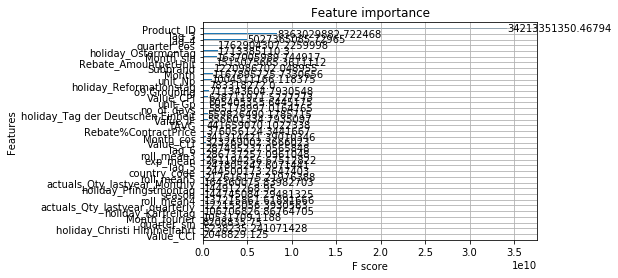

In [116]:
regressor = XGBRegressor(n_estimators = 100, n_jobs = 10,random_state = 123)
regressor.fit(X_train, y_train)
prediction_XG_S = regressor.predict(X_test)
print(1-(np.sum(np.abs(prediction_XG_S-y_test.values.ravel()))/np.sum(y_test)))
test_for_write['prediction_XG_S'] = prediction_XG_S
from xgboost import plot_importance
plot_importance(regressor,importance_type='gain')

# Parameter Tuning XGB

In [117]:
# #XGB Tuner

# tuner = XGBRegressionTuner(X_train, y_train, max_eval =100, cv = 3, eval_metric= mean_absolute_error, higher_is_better=False)

# tuned_model = tuner.optimize()
# tuned_model.fit(X_train,y_train)
# prediction_XGB_tuned_S = tuned_model.predict(X_test)
# print(1-(np.sum(np.abs(prediction_XGB_tuned_S-y_test.values.ravel()))/np.sum(y_test)))
# test_for_write['prediction_XGB_tuned_S'] = prediction_XGB_tuned_S
# test_for_write.head(2)


# RF Direct

In [118]:
from sklearn.ensemble import RandomForestRegressor
rf = RandomForestRegressor(n_estimators = 100, n_jobs = 10,random_state = 123)
rf.fit(X_train, y_train)
prediction_RF_S = rf.predict(X_test)
print(1-(np.sum(np.abs(prediction_RF_S-y_test.values.ravel()))/np.sum(y_test)))
test_for_write['prediction_RF_S'] = prediction_RF_S
test_for_write.head(2)

0.8211828819508107


Product_ID           o9 Grouping  Month  \
ts_id          month                                                     
60000000008417 2019-10-01  60000000008417  SENSODYNE CORE PASTE     10   
               2019-11-01  60000000008417  SENSODYNE CORE PASTE     11   

                           quarter  season country_code  actuals  \
ts_id          month                                               
60000000008417 2019-10-01        4  Autumn           GE     3452   
               2019-11-01        4  Autumn           GE     3817   

                           actuals_Qty_lastyear_Monthly  \
ts_id          month                                      
60000000008417 2019-10-01                          2925   
               2019-11-01                          4093   

                           actuals_Qty_lastyear_quarterly  lag_3  lag_4  \
ts_id          month                                                      
60000000008417 2019-10-01                            3583   2684   4425   
               2019-11-01                            3583   2629   2684   

                           lag_5  lag_6  Rebate%ContractPrice  \
ts_id          month                                            
60000000008417 2019-10-01   3016   2550                     0   
               2019-11-01   4425   3016                     0   

                           Rebate_LumpSum_FlatPhased  \
ts_id          month                                   
60000000008417 2019-10-01                          0   
               2019-11-01                          0   

                           Rebate_LumpSum_SalesPhased  Rebate_AmountperUnit  \
ts_id          month                                                          
60000000008417 2019-10-01                           0                     0   
               2019-11-01                           0                     0   

                           TAVG  no_of_days  unit_Gp  unit_Np  exp_mean  \
ts_id          month                                                      
60000000008417 2019-10-01    52           0        2        0       133   
               2019-11-01    41           0        2        0       132   

                           roll_mean3  roll_mean4  roll_mean5  Month_sin  \
ts_id          month                                                       
60000000008417 2019-10-01          96          91          89         -1   
               2019-11-01          93          91          87         -1   

                           Month_cos  Month_fourier  quarter_sin  quarter_cos  \
ts_id          month                                                            
60000000008417 2019-10-01          1             -0           -0            1   
               2019-11-01          1              0           -0            1   

                           quarter_fourier  holiday_Christi Himmelfahrt  \
ts_id          month                                                      
60000000008417 2019-10-01                1                            0   
               2019-11-01                1                            0   

                           holiday_Erster Mai  holiday_Erster Weihnachtstag  \
ts_id          month                                                          
60000000008417 2019-10-01                   0                             0   
               2019-11-01                   0                             0   

                           holiday_Karfreitag  holiday_Neujahr  \
ts_id          month                                             
60000000008417 2019-10-01                   0                0   
               2019-11-01                   0                0   

                           holiday_Ostermontag  holiday_Pfingstmontag  \
ts_id          month                                                    
60000000008417 2019-10-01                    0                      0   
               2019-11-01                    0                      0   

             

# Parameter Tuning RF

In [119]:
#from src.modelling.hyperparameter_tuning import RandomForestRegressionTuner
tuner = RandomForestRegressionTuner(X_train, y_train, max_eval =100, cv = 3, eval_metric= mean_absolute_error, higher_is_better=False)

In [120]:
tuned_model = tuner.optimize()
tuned_model.get_params()
tuned_model.fit(X_train,y_train)
prediction = tuned_model.predict(X_test)
test_for_write['prediction_RF_S_tuned'] = prediction
print(1-(np.sum(np.abs(prediction-y_test.values.ravel()))/np.sum(y_test)))
test_for_write1=test_for_write.reset_index(drop=False)
test_for_write1.to_csv("Germany_sensodyne_Dec_lag2.csv")
test_for_write1.head(3)

0.8532233472399321


,ts_id,month,Product_ID,o9 Grouping,Month,quarter,season,country_code,actuals,actuals_Qty_lastyear_Monthly,actuals_Qty_lastyear_quarterly,lag_3,lag_4,lag_5,lag_6,Rebate%ContractPrice,Rebate_LumpSum_FlatPhased,Rebate_LumpSum_SalesPhased,Rebate_AmountperUnit,TAVG,no_of_days,unit_Gp,unit_Np,exp_mean,roll_mean3,roll_mean4,roll_mean5,Month_sin,Month_cos,Month_fourier,quarter_sin,quarter_cos,quarter_fourier,holiday_Christi Himmelfahrt,holiday_Erster Mai,holiday_Erster Weihnachtstag,holiday_Karfreitag,holiday_Neujahr,holiday_Ostermontag,holiday_Pfingstmontag,holiday_Reformationstag,holiday_Tag der Deutschen Einheit,holiday_Zweiter Weihnachtstag,LOCATION,Value_CLI,Value_CPI,Value_CCI,Value_IF,Subbrand,Brand,prediction_XG_S,prediction_RF_S,prediction_RF_S_tuned
0,60000000008417,2019-10-01,60000000008417,SENSODYNE CORE PASTE,10,4,Autumn,GE,3452,2925,3583,2684,4425,3016,2550,0,0,0,0,52,0,2,0,133,96,91,89,-1,1,-0,-0,1,1,0,0,0,0,0,0,0,0,1,0,DEU,99,1,101,1,SENSODYNE CORE - OTHER,SENSODYNE CORE PASTE,52519,7307,4457
1,60000000008417,2019-11-01,60000000008417,SENSODYNE CORE PASTE,11,4,Autumn,GE,3817,4093,3583,2629,2684,4425,3016,0,0,0,0,41,0,2,0,132,93,91,87,-1,1,0,-0,1,1,0,0,0,0,0,0,0,0,0,0,DEU,99,1,101,1,SENSODYNE CORE - OTHER,SENSODYNE CORE PASTE,52848,8055,4625
2,60000000008417,2019-12-01,60000000008417,SENSODYNE CORE PASTE,12,4,Autumn,GE,3246,3732,3583,7017,2629,2684,4425,0,0,0,0,38,0,2,0,133,117,120,113,-0,1,1,-0,1,1,0,0,1,0,0,0,0,0,0,1,DEU,99,2,101,1,SENSODYNE CORE - OTHER,SENSODYNE CORE PASTE,54109,7972,5039


(1002, 74)
data_df (1002, 50)
data_df1 (887, 50)
train (818, 50)
test (69, 50)
['Product_ID', 'o9 Grouping', 'season', 'country_code', 'LOCATION', 'Subbrand', 'Brand']
0.5413080030647167


Tuning Random Forest...:   0%|                                                                 | 0/100 [00:00<?, ?it/s]

0.7954026201991501


0.8317274231429189


,ts_id,month,Product_ID,o9 Grouping,Month,quarter,season,country_code,actuals,actuals_Qty_lastyear_Monthly,actuals_Qty_lastyear_quarterly,lag_3,lag_4,lag_5,lag_6,Rebate%ContractPrice,Rebate_LumpSum_FlatPhased,Rebate_LumpSum_SalesPhased,Rebate_AmountperUnit,TAVG,no_of_days,unit_Gp,unit_Np,exp_mean,roll_mean3,roll_mean4,roll_mean5,Month_sin,Month_cos,Month_fourier,quarter_sin,quarter_cos,quarter_fourier,holiday_Christi Himmelfahrt,holiday_Erster Mai,holiday_Erster Weihnachtstag,holiday_Karfreitag,holiday_Neujahr,holiday_Ostermontag,holiday_Pfingstmontag,holiday_Reformationstag,holiday_Tag der Deutschen Einheit,holiday_Zweiter Weihnachtstag,LOCATION,Value_CLI,Value_CPI,Value_CCI,Value_IF,Subbrand,Brand,prediction_XG_S,prediction_RF_S,prediction_RF_S_tuned
0,60000000008417,2019-09-01,60000000008417,SENSODYNE CORE PASTE,9,3,Autumn,GE,7017,3867,3542,4425,3016,2550,2922,0,0,0,0,57,0,2,0,134,95,92,115,-1,-0,-1,-1,-0,-1,0,0,0,0,0,0,0,0,0,0,DEU,99,0,0,1,SENSODYNE CORE - OTHER,SENSODYNE CORE PASTE,9602,4296,3634
1,60000000008417,2019-10-01,60000000008417,SENSODYNE CORE PASTE,10,4,Autumn,GE,3452,2925,3583,2684,4425,3016,2550,0,0,0,0,52,0,2,0,133,96,91,89,-1,1,-0,-0,1,1,0,0,0,0,0,0,0,0,1,0,DEU,99,1,101,1,SENSODYNE CORE - OTHER,SENSODYNE CORE PASTE,8942,4222,3421
2,60000000008417,2019-11-01,60000000008417,SENSODYNE CORE PASTE,11,4,Autumn,GE,3817,4093,3583,2629,2684,4425,3016,0,0,0,0,41,0,2,0,132,93,91,87,-1,1,0,-0,1,1,0,0,0,0,0,0,0,0,0,0,DEU,99,1,101,1,SENSODYNE CORE - OTHER,SENSODYNE CORE PASTE,13991,4430,5092


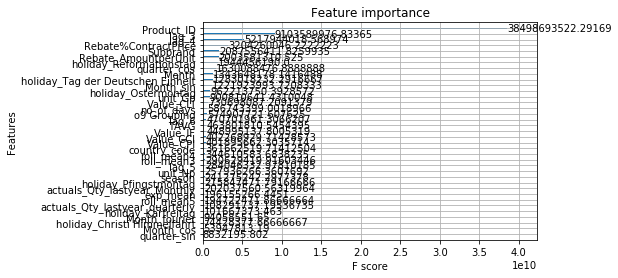

In [121]:
# creating ts_id :unique id for each product and banner combination

# nov as lag2
data_df = sales_dataset_final_GE5.copy()

data_df['ts_id'] = data_df.Product_ID.astype(str)
data_df.month = pd.to_datetime(data_df.month, yearfirst=True)
#data_df.drop(['Year'], axis=1,inplace=True)

print(data_df.shape)
data_df.head(3)

# setting data types

set_dtypes = {
'Product_ID':'str', 
#'Customer_Banner_No':'str',
'sub_brand':'str',
'o9 Grouping':'str',  
'actuals':'int', 
'Month':'int', 
'quarter':'int', 
'actuals_Qty_lastyear_Monthly':"float64",
'actuals_Qty_lastyear_quarterly':"float64",
'lag_3':'int', 
'lag_4':'int', 
'lag_5':'int', 
'lag_6':'int',
'season':'str', 
'country_code':'str', 
'TAVG':"float64", 
'holiday_Christi Himmelfahrt':'int',
'holiday_Erster Mai':'int', 
'holiday_Erster Weihnachtstag':'int',
'holiday_Karfreitag':'int', 
'holiday_Neujahr':'int', 
'holiday_Ostermontag':'int',
'holiday_Pfingstmontag':'int', 
'holiday_Reformationstag':'int',
'holiday_Tag der Deutschen Einheit':'int', 
'holiday_Zweiter Weihnachtstag':'int',
'Rebate%ContractPrice':'int', 
'Rebate_LumpSum_FlatPhased':'int',
'Rebate_LumpSum_SalesPhased':'int', 
'Rebate_AmountperUnit':'int', 
'no_of_days':'int',
'unit_Gp':"float64", 
'unit_Np':"float64", 
'ts_id':'str',
}

for col, dt in set_dtypes.items():
    data_df[col] = data_df[col].astype(dt)


# Train test split

data_df.drop(['Min_Stock_Days_lag3','lag3_Stock_quantity','Seg_Topical_Steroids','Seg_Topical_Antihistamines','Seg_Skin_Irritation', 'Seg_Drops', 'Seg_Systemic', 'Seg_Tablets','Seg_Systemic_Allergy', 'Seg_Wound Healing', 'BG_SkinIrritation','BG_SystemicAllergy', 'BG_WoundHealing', 'Core_A','Core_B','Core_c'],axis=1,inplace=True)
data_df.drop(['Year','sub_brand','sum_octlag2','sum_novlag2','sum_declag2','mean_octlag2', 'mean_novlag2', 'mean_declag2'],axis=1,inplace=True)

cut_off_date='2019-08-01'
data_max_date='2019-11-01'
print("data_df",data_df.shape)
data_df1=data_df[data_df.month<=data_max_date]
print("data_df1",data_df1.shape)


# train and test split
train = data_df1[data_df1.month<=cut_off_date]
test = data_df1[data_df1.month>cut_off_date]
print("train",train.shape)
print("test",test.shape)

train = train.set_index(['ts_id','month'])
test = test.set_index(['ts_id','month'])

X_train = train.drop(["actuals"],axis=1)
y_train = train['actuals']

X_test = test.drop(["actuals"],axis=1)
y_test = test['actuals']

cat_cols = X_train.select_dtypes('O').columns.tolist()
print(cat_cols)

# Encoding 

#catboost enccoding

encoder = ce.CatBoostEncoder(cols = cat_cols, drop_invariant=True, random_state=42)
X_train = encoder.fit_transform(X_train, y_train)
X_test = encoder.transform(X_test)

test_for_write = test.copy()



# XGB Regressor - direct

regressor = XGBRegressor(n_estimators = 100, n_jobs = 10,random_state = 123)
regressor.fit(X_train, y_train)
prediction_XG_S = regressor.predict(X_test)
print(1-(np.sum(np.abs(prediction_XG_S-y_test.values.ravel()))/np.sum(y_test)))
test_for_write['prediction_XG_S'] = prediction_XG_S
from xgboost import plot_importance
plot_importance(regressor,importance_type='gain')

# Parameter Tuning XGB

# #XGB Tuner

# tuner = XGBRegressionTuner(X_train, y_train, max_eval =100, cv = 3, eval_metric= mean_absolute_error, higher_is_better=False)

# tuned_model = tuner.optimize()
# tuned_model.fit(X_train,y_train)
# prediction_XGB_tuned_S = tuned_model.predict(X_test)
# print(1-(np.sum(np.abs(prediction_XGB_tuned_S-y_test.values.ravel()))/np.sum(y_test)))
# test_for_write['prediction_XGB_tuned_S'] = prediction_XGB_tuned_S
# test_for_write.head(2)




# RF Direct

from sklearn.ensemble import RandomForestRegressor
rf = RandomForestRegressor(n_estimators = 100, n_jobs = 10,random_state = 123)
rf.fit(X_train, y_train)
prediction_RF_S = rf.predict(X_test)
print(1-(np.sum(np.abs(prediction_RF_S-y_test.values.ravel()))/np.sum(y_test)))
test_for_write['prediction_RF_S'] = prediction_RF_S
test_for_write.head(2)

# Parameter Tuning RF

#from src.modelling.hyperparameter_tuning import RandomForestRegressionTuner
tuner = RandomForestRegressionTuner(X_train, y_train, max_eval =100, cv = 3, eval_metric= mean_absolute_error, higher_is_better=False)

tuned_model = tuner.optimize()
tuned_model.get_params()
tuned_model.fit(X_train,y_train)
prediction = tuned_model.predict(X_test)
test_for_write['prediction_RF_S_tuned'] = prediction
print(1-(np.sum(np.abs(prediction-y_test.values.ravel()))/np.sum(y_test)))
test_for_write1=test_for_write.reset_index(drop=False)
test_for_write1.to_csv("Germany_sensodyne_Nov_lag2.csv")
test_for_write1.head(3)

(1002, 74)
data_df (1002, 50)
data_df1 (864, 50)
train (795, 50)
test (69, 50)
['Product_ID', 'o9 Grouping', 'season', 'country_code', 'LOCATION', 'Subbrand', 'Brand']
0.6479711536665449


Tuning Random Forest...:   0%|                                                                 | 0/100 [00:00<?, ?it/s]

0.7622696270478496


0.8205461259508604


,ts_id,month,Product_ID,o9 Grouping,Month,quarter,season,country_code,actuals,actuals_Qty_lastyear_Monthly,actuals_Qty_lastyear_quarterly,lag_3,lag_4,lag_5,lag_6,Rebate%ContractPrice,Rebate_LumpSum_FlatPhased,Rebate_LumpSum_SalesPhased,Rebate_AmountperUnit,TAVG,no_of_days,unit_Gp,unit_Np,exp_mean,roll_mean3,roll_mean4,roll_mean5,Month_sin,Month_cos,Month_fourier,quarter_sin,quarter_cos,quarter_fourier,holiday_Christi Himmelfahrt,holiday_Erster Mai,holiday_Erster Weihnachtstag,holiday_Karfreitag,holiday_Neujahr,holiday_Ostermontag,holiday_Pfingstmontag,holiday_Reformationstag,holiday_Tag der Deutschen Einheit,holiday_Zweiter Weihnachtstag,LOCATION,Value_CLI,Value_CPI,Value_CCI,Value_IF,Subbrand,Brand,prediction_XG_S,prediction_RF_S,prediction_RF_S_tuned
0,60000000008417,2019-08-01,60000000008417,SENSODYNE CORE PASTE,8,3,Summer,GE,2629,3232,3542,3016,2550,2922,7273,0,0,0,0,66,0,2,0,135,81,113,113,-1,-1,-1,-1,-0,-1,0,0,0,0,0,0,0,0,0,0,DEU,99,0,0,1,SENSODYNE CORE - OTHER,SENSODYNE CORE PASTE,5449,5576,7498
1,60000000008417,2019-09-01,60000000008417,SENSODYNE CORE PASTE,9,3,Autumn,GE,7017,3867,3542,4425,3016,2550,2922,0,0,0,0,57,0,2,0,134,95,92,115,-1,-0,-1,-1,-0,-1,0,0,0,0,0,0,0,0,0,0,DEU,99,0,0,1,SENSODYNE CORE - OTHER,SENSODYNE CORE PASTE,3359,4879,6259
2,60000000008417,2019-10-01,60000000008417,SENSODYNE CORE PASTE,10,4,Autumn,GE,3452,2925,3583,2684,4425,3016,2550,0,0,0,0,52,0,2,0,133,96,91,89,-1,1,-0,-0,1,1,0,0,0,0,0,0,0,0,1,0,DEU,99,1,101,1,SENSODYNE CORE - OTHER,SENSODYNE CORE PASTE,2878,4970,6424


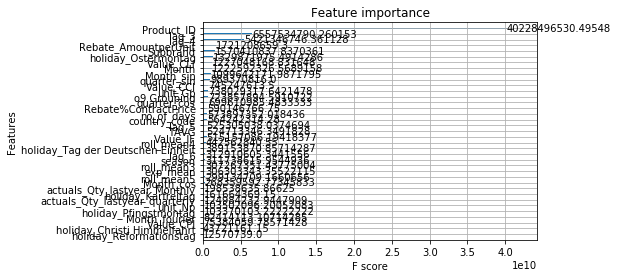

In [122]:
# creating ts_id :unique id for each product and banner combination


data_df = sales_dataset_final_GE5.copy()
data_df.rename(columns={'Customer Banner_No':'Customer_Banner_No'},inplace= True)
data_df['ts_id'] = data_df.Product_ID.astype(str)
data_df.month = pd.to_datetime(data_df.month, yearfirst=True)
#data_df.drop(['Year'], axis=1,inplace=True)

print(data_df.shape)
data_df.head(3)

# setting data types

set_dtypes = {
'Product_ID':'str', 
#'Customer_Banner_No':'str',
'sub_brand':'str',
'o9 Grouping':'str',  
'actuals':'int', 
'Month':'int', 
'quarter':'int', 
'actuals_Qty_lastyear_Monthly':"float64",
'actuals_Qty_lastyear_quarterly':"float64",
'lag_3':'int', 
'lag_4':'int', 
'lag_5':'int', 
'lag_6':'int',
'season':'str', 
'country_code':'str', 
'TAVG':"float64", 
'holiday_Christi Himmelfahrt':'int',
'holiday_Erster Mai':'int', 
'holiday_Erster Weihnachtstag':'int',
'holiday_Karfreitag':'int', 
'holiday_Neujahr':'int', 
'holiday_Ostermontag':'int',
'holiday_Pfingstmontag':'int', 
'holiday_Reformationstag':'int',
'holiday_Tag der Deutschen Einheit':'int', 
'holiday_Zweiter Weihnachtstag':'int',
'Rebate%ContractPrice':'int', 
'Rebate_LumpSum_FlatPhased':'int',
'Rebate_LumpSum_SalesPhased':'int', 
'Rebate_AmountperUnit':'int', 
'no_of_days':'int',
'unit_Gp':"float64", 
'unit_Np':"float64", 
'ts_id':'str',
}

for col, dt in set_dtypes.items():
    data_df[col] = data_df[col].astype(dt)


# Train test split
data_df.drop(['Year','sub_brand','sum_octlag2','sum_novlag2','sum_declag2','mean_octlag2', 'mean_novlag2', 'mean_declag2'],axis=1,inplace=True)

data_df.drop(['Min_Stock_Days_lag3','lag3_Stock_quantity','Seg_Topical_Steroids','Seg_Topical_Antihistamines','Seg_Skin_Irritation', 'Seg_Drops', 'Seg_Systemic', 'Seg_Tablets','Seg_Systemic_Allergy', 'Seg_Wound Healing', 'BG_SkinIrritation','BG_SystemicAllergy', 'BG_WoundHealing', 'Core_A','Core_B','Core_c'],axis=1,inplace=True)

cut_off_date='2019-07-01'
data_max_date='2019-10-01'
print("data_df",data_df.shape)
data_df1=data_df[data_df.month<=data_max_date]
print("data_df1",data_df1.shape)


# train and test split
train = data_df1[data_df1.month<=cut_off_date]
test = data_df1[data_df1.month>cut_off_date]
print("train",train.shape)
print("test",test.shape)

train = train.set_index(['ts_id','month'])
test = test.set_index(['ts_id','month'])

X_train = train.drop(["actuals"],axis=1)
y_train = train['actuals']

X_test = test.drop(["actuals"],axis=1)
y_test = test['actuals']

cat_cols = X_train.select_dtypes('O').columns.tolist()
print(cat_cols)

# Encoding 

#catboost enccoding

encoder = ce.CatBoostEncoder(cols = cat_cols, drop_invariant=True, random_state=42)
X_train = encoder.fit_transform(X_train, y_train)
X_test = encoder.transform(X_test)

test_for_write = test.copy()



# XGB Regressor - direct

regressor = XGBRegressor(n_estimators = 100, n_jobs = 10,random_state = 123)
regressor.fit(X_train, y_train)
prediction_XG_S = regressor.predict(X_test)
print(1-(np.sum(np.abs(prediction_XG_S-y_test.values.ravel()))/np.sum(y_test)))
test_for_write['prediction_XG_S'] = prediction_XG_S
from xgboost import plot_importance
plot_importance(regressor,importance_type='gain')

# Parameter Tuning XGB

# #XGB Tuner

# tuner = XGBRegressionTuner(X_train, y_train, max_eval =100, cv = 3, eval_metric= mean_absolute_error, higher_is_better=False)

# tuned_model = tuner.optimize()
# tuned_model.fit(X_train,y_train)
# prediction_XGB_tuned_S = tuned_model.predict(X_test)
# print(1-(np.sum(np.abs(prediction_XGB_tuned_S-y_test.values.ravel()))/np.sum(y_test)))
# test_for_write['prediction_XGB_tuned_S'] = prediction_XGB_tuned_S
# test_for_write.head(2)




# RF Direct

from sklearn.ensemble import RandomForestRegressor
rf = RandomForestRegressor(n_estimators = 100, n_jobs = 10,random_state = 123)
rf.fit(X_train, y_train)
prediction_RF_S = rf.predict(X_test)
print(1-(np.sum(np.abs(prediction_RF_S-y_test.values.ravel()))/np.sum(y_test)))
test_for_write['prediction_RF_S'] = prediction_RF_S
test_for_write.head(2)

# Parameter Tuning RF

#from src.modelling.hyperparameter_tuning import RandomForestRegressionTuner
tuner = RandomForestRegressionTuner(X_train, y_train, max_eval =100, cv = 3, eval_metric= mean_absolute_error, higher_is_better=False)

tuned_model = tuner.optimize()
tuned_model.get_params()
tuned_model.fit(X_train,y_train)
prediction = tuned_model.predict(X_test)
test_for_write['prediction_RF_S_tuned'] = prediction
print(1-(np.sum(np.abs(prediction-y_test.values.ravel()))/np.sum(y_test)))
test_for_write1=test_for_write.reset_index(drop=False)
test_for_write1.to_csv("Germany_sensodyne_Oct_lag2.csv")
test_for_write1.head(3)

# Fenstil Modelling Germany

In [ ]:
print(sales_dataset_final_GE6["Product_ID"].unique())
data_df = sales_dataset_final_GE6.copy()
data_df.rename(columns={'Customer Banner_No':'Customer_Banner_No'},inplace= True)

data_df['ts_id'] = data_df.Product_ID.astype(str)
data_df.month = pd.to_datetime(data_df.month, yearfirst=True)

print(data_df.shape)

data_df.head(3)

# Setting Data Types


In [ ]:
set_dtypes = {
'Product_ID':'str', 
'sub_brand':'str',
'o9 Grouping':'str',  
'actuals':'int', 
'Month':'int', 
'quarter':'int', 
'actuals_Qty_lastyear_Monthly':"float64",
'actuals_Qty_lastyear_quarterly':"float64",
'lag_3':'int', 
'lag_4':'int', 
'lag_5':'int', 
'lag_6':'int',
'season':'str', 
'country_code':'str', 
'TAVG':"float64", 
'holiday_Christi Himmelfahrt':'int',
'holiday_Erster Mai':'int', 
'holiday_Erster Weihnachtstag':'int',
'holiday_Karfreitag':'int', 
'holiday_Neujahr':'int', 
'holiday_Ostermontag':'int',
'holiday_Pfingstmontag':'int', 
'holiday_Reformationstag':'int',
'holiday_Tag der Deutschen Einheit':'int', 
'holiday_Zweiter Weihnachtstag':'int',
'Seg_Topical_Steroids':'int',
'Seg_Topical_Antihistamines':'int',
'Seg_Skin_Irritation':'int',
'Seg_Drops':'int',
'Seg_Systemic':'int',
'Seg_Tablets':'int',
'Seg_Systemic_Allergy':'int',
'Seg_Wound Healing':'int',
'BG_SkinIrritation':'int',
'BG_SystemicAllergy':'int',
'BG_WoundHealing':'int',
'Core_A':'int',
'Core_B':'int',
'Core_c':'int',
'lag3_Stock_quantity':"float64", 
'Min_Stock_Days_lag3':"float64",  
    
'ts_id':'str',
}

for col, dt in set_dtypes.items():
    data_df[col] = data_df[col].astype(dt)


In [ ]:
data_df.drop(['unit_Np','unit_Gp','Rebate_AmountperUnit','Rebate_LumpSum_SalesPhased','Rebate_LumpSum_FlatPhased','Rebate%ContractPrice','no_of_days'], axis=1,inplace=True)
data_df.drop(['Year','sub_brand','sum_octlag2','sum_novlag2','sum_declag2','mean_octlag2', 'mean_novlag2', 'mean_declag2'],axis=1,inplace=True)


cut_off_date='2019-09-01'
data_max_date='2019-12-01'
print("data_df",data_df.shape)
data_df1=data_df[data_df.month<=data_max_date]
print("data_df1",data_df1.shape)


# train and test split
train = data_df1[data_df1.month<=cut_off_date]
test = data_df1[data_df1.month>cut_off_date]
print("train",train.shape)
print("test",test.shape)

In [ ]:
train = train.set_index(['ts_id','month'])
test = test.set_index(['ts_id','month'])

X_train = train.drop(["actuals"],axis=1)
y_train = train['actuals']

X_test = test.drop(["actuals"],axis=1)
y_test = test['actuals']

cat_cols = X_train.select_dtypes('O').columns.tolist()
print(cat_cols)

# Encoding

In [ ]:
#catboost enccoding

encoder = ce.CatBoostEncoder(cols = cat_cols, drop_invariant=True, random_state=42)
X_train = encoder.fit_transform(X_train, y_train)
X_test = encoder.transform(X_test)

test_for_write = test.copy()

# XGB Regressor - direct

In [ ]:

regressor = XGBRegressor(n_estimators = 100, n_jobs = 10,random_state = 123)
regressor.fit(X_train, y_train)
prediction_XG_F = regressor.predict(X_test)
print(1-(np.sum(np.abs(prediction_XG_F-y_test.values.ravel()))/np.sum(y_test)))
test_for_write['prediction_XG_F'] = prediction_XG_F
from xgboost import plot_importance
plot_importance(regressor,importance_type='gain')

# # XGB Regressor - direct- tunning

In [ ]:

# tuner = XGBRegressionTuner(X_train, y_train, max_eval =100, cv = 3, eval_metric= mean_absolute_error, higher_is_better=False)
# tuned_model = tuner.optimize()
# tuned_model.fit(X_train,y_train)
# prediction_XGB_tuned_F = tuned_model.predict(X_test)
# print(1-(np.sum(np.abs(prediction_XGB_tuned_F-y_test.values.ravel()))/np.sum(y_test)))
# test_for_write['prediction_XGB_tuned_F'] = prediction_XGB_tuned_F

# Rf direct

In [ ]:
from sklearn.ensemble import RandomForestRegressor
rf = RandomForestRegressor(n_estimators = 100, n_jobs = 10,random_state = 123)
rf.fit(X_train, y_train)

prediction_RF_F = rf.predict(X_test)
test_for_write['prediction_RF_F'] = prediction_RF_F
print(1-(np.sum(np.abs(prediction_RF_F-y_test.values.ravel()))/np.sum(y_test)))



# Parameter Tuning RF

In [ ]:
#from src.modelling.hyperparameter_tuning import RandomForestRegressionTuner
tuner = RandomForestRegressionTuner(X_train, y_train, max_eval =100, cv = 3, eval_metric= mean_absolute_error, higher_is_better=False)

tuned_model = tuner.optimize()
tuned_model.get_params()
tuned_model.fit(X_train,y_train)
prediction_tuned_RF_F = tuned_model.predict(X_test)
test_for_write['prediction_tuned_RF_F'] = prediction_tuned_RF_F

print(1-(np.sum(np.abs(prediction_tuned_RF_F-y_test.values.ravel()))/np.sum(y_test)))
test_for_write2=test_for_write.reset_index(drop=False)
test_for_write2.to_csv("Germany_declag2_fenstil.csv")
test_for_write2.head(3)

In [ ]:
# creating ts_id :unique id for each product and banner combination

#nov as lag2
print(sales_dataset_final_GE6["Product_ID"].unique())
data_df = sales_dataset_final_GE6.copy()
data_df.rename(columns={'Customer Banner_No':'Customer_Banner_No'},inplace= True)

data_df['ts_id'] = data_df.Product_ID.astype(str)
data_df.month = pd.to_datetime(data_df.month, yearfirst=True)

print(data_df.shape)

data_df.head(3)

# Setting Data Types


set_dtypes = {
'Product_ID':'str', 
'sub_brand':'str',
'o9 Grouping':'str',  
'actuals':'int', 
'Month':'int', 
'quarter':'int', 
'actuals_Qty_lastyear_Monthly':"float64",
'actuals_Qty_lastyear_quarterly':"float64",
'lag_3':'int', 
'lag_4':'int', 
'lag_5':'int', 
'lag_6':'int',
'season':'str', 
'country_code':'str', 
'TAVG':"float64", 
'holiday_Christi Himmelfahrt':'int',
'holiday_Erster Mai':'int', 
'holiday_Erster Weihnachtstag':'int',
'holiday_Karfreitag':'int', 
'holiday_Neujahr':'int', 
'holiday_Ostermontag':'int',
'holiday_Pfingstmontag':'int', 
'holiday_Reformationstag':'int',
'holiday_Tag der Deutschen Einheit':'int', 
'holiday_Zweiter Weihnachtstag':'int',
'Seg_Topical_Steroids':'int',
'Seg_Topical_Antihistamines':'int',
'Seg_Skin_Irritation':'int',
'Seg_Drops':'int',
'Seg_Systemic':'int',
'Seg_Tablets':'int',
'Seg_Systemic_Allergy':'int',
'Seg_Wound Healing':'int',
'BG_SkinIrritation':'int',
'BG_SystemicAllergy':'int',
'BG_WoundHealing':'int',
'Core_A':'int',
'Core_B':'int',
'Core_c':'int',
'lag3_Stock_quantity':"float64", 
'Min_Stock_Days_lag3':"float64",  
    
'ts_id':'str',
}

for col, dt in set_dtypes.items():
    data_df[col] = data_df[col].astype(dt)

data_df.drop(['Year','sub_brand','sum_octlag2','sum_novlag2','sum_declag2','mean_octlag2', 'mean_novlag2', 'mean_declag2'],axis=1,inplace=True)

data_df.drop(['unit_Np','unit_Gp','Rebate_AmountperUnit','Rebate_LumpSum_SalesPhased','Rebate_LumpSum_FlatPhased','Rebate%ContractPrice','no_of_days'], axis=1,inplace=True)
cut_off_date='2019-08-01'
data_max_date='2019-11-01'
print("data_df",data_df.shape)
data_df1=data_df[data_df.month<=data_max_date]
print("data_df1",data_df1.shape)


# train and test split
train = data_df1[data_df1.month<=cut_off_date]
test = data_df1[data_df1.month>cut_off_date]
print("train",train.shape)
print("test",test.shape)

train = train.set_index(['ts_id','month'])
test = test.set_index(['ts_id','month'])

X_train = train.drop(["actuals"],axis=1)
y_train = train['actuals']

X_test = test.drop(["actuals"],axis=1)
y_test = test['actuals']

cat_cols = X_train.select_dtypes('O').columns.tolist()
print(cat_cols)

# Encoding

#catboost enccoding

encoder = ce.CatBoostEncoder(cols = cat_cols, drop_invariant=True, random_state=42)
X_train = encoder.fit_transform(X_train, y_train)
X_test = encoder.transform(X_test)

test_for_write = test.copy()

# XGB Regressor - direct


regressor = XGBRegressor(n_estimators = 100, n_jobs = 10,random_state = 123)
regressor.fit(X_train, y_train)
prediction_XG_F = regressor.predict(X_test)
print(1-(np.sum(np.abs(prediction_XG_F-y_test.values.ravel()))/np.sum(y_test)))
test_for_write['prediction_XG_F'] = prediction_XG_F
from xgboost import plot_importance
plot_importance(regressor,importance_type='gain')

# # XGB Regressor - direct- tunning


# tuner = XGBRegressionTuner(X_train, y_train, max_eval =100, cv = 3, eval_metric= mean_absolute_error, higher_is_better=False)
# tuned_model = tuner.optimize()
# tuned_model.fit(X_train,y_train)
# prediction_XGB_tuned_F = tuned_model.predict(X_test)
# print(1-(np.sum(np.abs(prediction_XGB_tuned_F-y_test.values.ravel()))/np.sum(y_test)))
# test_for_write['prediction_XGB_tuned_F'] = prediction_XGB_tuned_F



# Rf direct

from sklearn.ensemble import RandomForestRegressor
rf = RandomForestRegressor(n_estimators = 100, n_jobs = 10,random_state = 123)
rf.fit(X_train, y_train)

prediction_RF_F = rf.predict(X_test)
test_for_write['prediction_RF_F'] = prediction_RF_F
print(1-(np.sum(np.abs(prediction_RF_F-y_test.values.ravel()))/np.sum(y_test)))





# Parameter Tuning RF

#from src.modelling.hyperparameter_tuning import RandomForestRegressionTuner
tuner = RandomForestRegressionTuner(X_train, y_train, max_eval =100, cv = 3, eval_metric= mean_absolute_error, higher_is_better=False)

tuned_model = tuner.optimize()
tuned_model.get_params()
tuned_model.fit(X_train,y_train)
prediction_tuned_RF_F = tuned_model.predict(X_test)
test_for_write['prediction_tuned_RF_F'] = prediction_tuned_RF_F

print(1-(np.sum(np.abs(prediction_tuned_RF_F-y_test.values.ravel()))/np.sum(y_test)))
test_for_write2=test_for_write.reset_index(drop=False)
test_for_write2.to_csv("Germany_Novlag2_fenstil.csv")
test_for_write2.head(3)

In [ ]:
# creating ts_id :unique id for each product and banner combination

#nov as lag2
print(sales_dataset_final_GE6["Product_ID"].unique())
data_df = sales_dataset_final_GE6.copy()
data_df.rename(columns={'Customer Banner_No':'Customer_Banner_No'},inplace= True)

data_df['ts_id'] = data_df.Product_ID.astype(str)
data_df.month = pd.to_datetime(data_df.month, yearfirst=True)

print(data_df.shape)

data_df.head(3)

# Setting Data Types


set_dtypes = {
'Product_ID':'str', 
'sub_brand':'str',
'o9 Grouping':'str',  
'actuals':'int', 
'Month':'int', 
'quarter':'int', 
'actuals_Qty_lastyear_Monthly':"float64",
'actuals_Qty_lastyear_quarterly':"float64",
'lag_3':'int', 
'lag_4':'int', 
'lag_5':'int', 
'lag_6':'int',
'season':'str', 
'country_code':'str', 
'TAVG':"float64", 
'holiday_Christi Himmelfahrt':'int',
'holiday_Erster Mai':'int', 
'holiday_Erster Weihnachtstag':'int',
'holiday_Karfreitag':'int', 
'holiday_Neujahr':'int', 
'holiday_Ostermontag':'int',
'holiday_Pfingstmontag':'int', 
'holiday_Reformationstag':'int',
'holiday_Tag der Deutschen Einheit':'int', 
'holiday_Zweiter Weihnachtstag':'int',
'Seg_Topical_Steroids':'int',
'Seg_Topical_Antihistamines':'int',
'Seg_Skin_Irritation':'int',
'Seg_Drops':'int',
'Seg_Systemic':'int',
'Seg_Tablets':'int',
'Seg_Systemic_Allergy':'int',
'Seg_Wound Healing':'int',
'BG_SkinIrritation':'int',
'BG_SystemicAllergy':'int',
'BG_WoundHealing':'int',
'Core_A':'int',
'Core_B':'int',
'Core_c':'int',
'lag3_Stock_quantity':"float64", 
'Min_Stock_Days_lag3':"float64",  
    
'ts_id':'str',
}

for col, dt in set_dtypes.items():
    data_df[col] = data_df[col].astype(dt)

data_df.drop(['Year','sub_brand','sum_octlag2','sum_novlag2','sum_declag2','mean_octlag2', 'mean_novlag2', 'mean_declag2'],axis=1,inplace=True)

data_df.drop(['unit_Np','unit_Gp','Rebate_AmountperUnit','Rebate_LumpSum_SalesPhased','Rebate_LumpSum_FlatPhased','Rebate%ContractPrice','no_of_days'], axis=1,inplace=True)
cut_off_date='2019-07-01'
data_max_date='2019-10-01'
print("data_df",data_df.shape)
data_df1=data_df[data_df.month<=data_max_date]
print("data_df1",data_df1.shape)


# train and test split
train = data_df1[data_df1.month<=cut_off_date]
test = data_df1[data_df1.month>cut_off_date]
print("train",train.shape)
print("test",test.shape)

train = train.set_index(['ts_id','month'])
test = test.set_index(['ts_id','month'])

X_train = train.drop(["actuals"],axis=1)
y_train = train['actuals']

X_test = test.drop(["actuals"],axis=1)
y_test = test['actuals']

cat_cols = X_train.select_dtypes('O').columns.tolist()
print(cat_cols)

# Encoding

#catboost enccoding

encoder = ce.CatBoostEncoder(cols = cat_cols, drop_invariant=True, random_state=42)
X_train = encoder.fit_transform(X_train, y_train)
X_test = encoder.transform(X_test)

test_for_write = test.copy()

# XGB Regressor - direct


regressor = XGBRegressor(n_estimators = 100, n_jobs = 10,random_state = 123)
regressor.fit(X_train, y_train)
prediction_XG_F = regressor.predict(X_test)
print(1-(np.sum(np.abs(prediction_XG_F-y_test.values.ravel()))/np.sum(y_test)))
test_for_write['prediction_XG_F'] = prediction_XG_F
from xgboost import plot_importance
plot_importance(regressor,importance_type='gain')

# # XGB Regressor - direct- tunning


# tuner = XGBRegressionTuner(X_train, y_train, max_eval =100, cv = 3, eval_metric= mean_absolute_error, higher_is_better=False)
# tuned_model = tuner.optimize()
# tuned_model.fit(X_train,y_train)
# prediction_XGB_tuned_F = tuned_model.predict(X_test)
# print(1-(np.sum(np.abs(prediction_XGB_tuned_F-y_test.values.ravel()))/np.sum(y_test)))
# test_for_write['prediction_XGB_tuned_F'] = prediction_XGB_tuned_F



# Rf direct

from sklearn.ensemble import RandomForestRegressor
rf = RandomForestRegressor(n_estimators = 100, n_jobs = 10,random_state = 123)
rf.fit(X_train, y_train)

prediction_RF_F = rf.predict(X_test)
test_for_write['prediction_RF_F'] = prediction_RF_F
print(1-(np.sum(np.abs(prediction_RF_F-y_test.values.ravel()))/np.sum(y_test)))





# Parameter Tuning RF

#from src.modelling.hyperparameter_tuning import RandomForestRegressionTuner
tuner = RandomForestRegressionTuner(X_train, y_train, max_eval =100, cv = 3, eval_metric= mean_absolute_error, higher_is_better=False)

tuned_model = tuner.optimize()
tuned_model.get_params()
tuned_model.fit(X_train,y_train)
prediction_tuned_RF_F = tuned_model.predict(X_test)
test_for_write['prediction_tuned_RF_F'] = prediction_tuned_RF_F

print(1-(np.sum(np.abs(prediction_tuned_RF_F-y_test.values.ravel()))/np.sum(y_test)))
test_for_write2=test_for_write.reset_index(drop=False)
test_for_write2.to_csv("Germany_Octlag2_fenstil.csv")
test_for_write2.head(3)